<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/dtp_stat/dpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Вводная часть**

**Исследование данных о дорожно-транспортных происшествиях (ДТП)**

Исследования массива данных, предоставленных проектом «Карта ДТП». Это некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. Это платформа сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.

Задача стояла максимально свободно: Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Ход исследования**:

- **Загрузка и парсинг данных** (Исходные данные хранятся в отдельных датасетах по субъектам РФ в формате json)
- **Подготовка данных** (Проверка на пропуски и дубликаты, создание вспомогательных колонок, объединение близких по смыслу значений)
- **Исследовательский анализ и визуализация** (Основные показатели ДТП по всей выборке. Графики, распределения, диаграммы различных показателей ДТП по срезам)
- **Выявление факторов, при которых наболее высокая вероятность погибнуть, попав ДТП** (Внешние факторы, небезолпасность транспортных средств, нарушения ПДД)
- **Проверка гипотез** (Кто чаще нарушает - мужчины или женщины, пешеходы или водители; кто чаше попадает в ДТП - новички или опытные; в какие дни и месяцы происходит больше ДТП; что опаснее - дождь или снегопадт и другие)
- **Построение карты очагов аварийности** (Определение мест, в которых происходит много ДТП. Динамика аварийности в этих местах по годам)

Выводы данного анализа основаны на результатах, полученных при обработке датасет по всей России с 2015 года по сентябрь 2024. Это данные о 1,5 млн ДТП, всего порядка 8 млн. записей о самих ДТП, ТС и участниках ДТП. При расчете на датаесете отдельных регионов или другом временном промежутке результаты вычислений, а значит и выводы могут быть другими.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import math as mth
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import datetime
import pytz

In [2]:
#tz = pytz.timezone('Europe/Moscow')
tz = pytz.timezone('Europe/Samara')
start = datetime.datetime.now(tz)

pd.options.display.max_colwidth = 9000
pd.set_option('future.no_silent_downcasting', True)

In [3]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/dtp/

/content/drive/My Drive/Colab Notebooks/dtp


# **Загрузка данных**

**В данном разделе проходит загрузка данных. Парсинг из формата json (если надо), либо объединение данных из распарсенных ранее датасектов по отдельным регионам в один датасет**

## *Процедуры и функции загрузки*

In [4]:
#процедура скачивания датасетов json с сайта dtp-stat.ru/opendata
#и сохрание их в локальной папке для дальнейшего парсинга
def dowload_json():
  import requests
  import re
  from urllib.parse import urlparse, urljoin
  from bs4 import BeautifulSoup

  dtp_stat_url = 'https://dtp-stat.ru/opendata'
  data_save_path = 'datasets/json/'
  #data_save_path = 'd:/'

  responce = requests.get(dtp_stat_url)
  if responce.status_code == 200:
    soup = BeautifulSoup(responce.content, "html.parser")
    file_links = soup.find_all('a', href=re.compile("\.geojson$"))
    for link in file_links:
        jsonlink = link['href']
        path, filename = os.path.split(jsonlink)
        if not os.path.isfile(data_save_path + filename):
            jsonfile_responce = requests.get(jsonlink)
            if jsonfile_responce.status_code == 200:
              with open(data_save_path + filename, "wb") as file:
                  file.write(jsonfile_responce.content)
                  file.close()
                  print(f'Загрузка файла {filename} в папку {data_save_path}')
            else:
                print(f'Не загружается файл {jsonlink}')
        else:
            print(f'{filename} - а такой файл уже есть в локальной папке!')
  else:
    print(f'Не открывается url {dtp_stat_url}')

In [5]:
#Парсер json данных о ДТП с сайта https://dtp-stat.ru/opendata
#Парсинг осуществляется построчным перебором записей в json файле, что очень долго =(
#Парсер переводит данные в три датасета - по дтп, по ТС и по людям
#Данные сохраняются в формат cvs для последующего использования
def dtp_json_parser(filename):
    import warnings
    warnings.filterwarnings("ignore")
    #-------------- Чтение json данных из фала -----------

    if not os.path.isfile(filename):
        print('Нет такого файла - ', filename)
        return

    path, filename_out = os.path.split(filename)
    path = path + '/'
    filename_out = filename_out.split('.')[0]
    with open(filename, 'r', encoding='utf-8') as file:
        jdata = json.load(file)

    # ------------- Объявление датасетов для принятия данных -----------
    data = pd.DataFrame(columns=['dtp_id', 'date_time', 'okrug', 'oblast', 'region', 'address', 'lat', 'lng', 'nearby',
                            'light', 'weather', 'road_conditions', 'category', 'severity',
                            'dead_count', 'injured_count', 'participants_count', 'cars_count', 'participant_categories'])
    cars = pd.DataFrame(columns=['car_id', 'dtp_id', 'year', 'brand', 'color', 'model', 'category'])
    partic = pd.DataFrame(columns=['partic_id', 'car_id', 'dtp_id', 'role', 'gender', 'violations',
                            'health_status', 'years_of_driving_experience'])

    #-------------- Разбор json данных -----------------
    d = 1
    c = 1
    p = 1
    print(datetime.datetime.now(tz).strftime('%H:%M:%S'), 'Начинаю обработку файла', filename)
    #print('Обработано тысяч записей ДТП: ', end='')

    for jj in jdata['features']:
        dtp = jj['properties']

        #Добавление ДТП
        data.loc[d] = {'dtp_id': dtp['id'], 'date_time': dtp['datetime'],
                   'okrug':'ПФО', 'parent_region': dtp['parent_region'], 'region': dtp['region'], 'address': dtp['address'],
                   'lat': dtp['point']['lat'], 'lng': dtp['point']['long'], 'nearby' : '; '.join(dtp['nearby']),
                   'light' : dtp['light'], 'weather' : '; '.join(dtp['weather']), 'road_conditions' : '; '.join(dtp['road_conditions']),
                   'category': dtp['category'], 'severity' : dtp['severity'], 'dead_count': dtp['dead_count'],
                   'injured_count': dtp['injured_count'], 'participants_count': dtp['participants_count'],
                   'participant_categories' : '; '.join(dtp['participant_categories'])}

        #Добавление траснпортного средства
        cars_in_dtp = 0
        for cc in dtp['vehicles']:
            cars.loc[c] = {'car_id' : c, 'dtp_id' : dtp['id'], 'year' : cc['year'], 'brand' : cc['brand'],
                           'color' : cc['color'], 'model' : cc['model'], 'category' : cc['category']}
            #Добавление людей из ТС
            for pp in cc['participants']:
                partic.loc[p] = {'partic_id' : p, 'car_id' : c, 'dtp_id' : dtp['id'], 'role' : pp['role'],
                                 'gender' : pp['gender'], 'violations' : '; '.join(pp['violations']),
                                 'health_status' : pp['health_status'],
                                 'years_of_driving_experience' : pp['years_of_driving_experience']}
                p +=1 #счетчик людей
            c +=1 #счетчик ТС
            cars_in_dtp +=1

        data.loc[d,'cars_count'] = cars_in_dtp

        #Добавление людей без ТС
        for pp in dtp['participants']:
            partic.loc[p] = {'partic_id' : p, 'car_id' : 0, 'dtp_id' : dtp['id'], 'role' : pp['role'],
                             'gender' : pp['gender'], 'violations' : '; '.join(pp['violations']),
                                 'health_status' : pp['health_status'], 'years_of_driving_experience' : None}
            p +=1 #счетчик людей

        d +=1 #счетчик ДТП
        if d % 1000 == 0: print("\r" + 'Обработано тысяч записей ДТП: ' + str(d//1000), end='')

        #if d > 100: break #брейк для отладки =)
    #------------ конец разбора json ----------------

    data['cars_count'] = data['cars_count'].astype('int')
    print('..все!')
    print('Получено записей о ДТП -', len(data))
    print('Получено записей о ТС, участвоваваших в ДТП -', len(cars))
    print('Получено записей о людях, участвовавших в ДТП -', len(partic))

    # ----------- Запись данных в CSV ----------------

    if len(data) < 111: filename_out = 'test-' + filename_out
    data.to_csv(csv_path + filename_out + '-data.csv', index=False)
    partic.to_csv(csv_path + filename_out + '-partic.csv', index=False)
    cars.to_csv(csv_path + filename_out + '-cars.csv', index=False)
    print(datetime.datetime.now(tz).strftime('%H:%M:%S'), 'Данные сохранены по адрeсу:', csv_path + filename_out + '-xxxx.csv')
    print('--------------')

In [6]:
#Парсер json данных о ДТП с сайта https://dtp-stat.ru/opendata
#Парсинг осуществляется "разворачиванеим" json полей сразу в новые таблицы
#Работает значительно быстрее построчного перебора =)
def load_data_json(regions):
    j_all_reg = []
    for reg_filename in regions:
        print(f'Загружаю данные из файла {reg_filename}.geojson')
        with open(json_path + reg_filename + '.geojson', 'r', encoding='utf-8') as file:
            jdata = json.load(file)
            j_all_reg = j_all_reg + jdata['features']

    print('Начинаю формирование таблицы ДТП')
    dtps = pd.json_normalize(j_all_reg)
    dtps.columns = dtps.columns.str.replace('properties.', '')
    dtps = dtps.rename(columns = {'id' : 'dtp_id', 'point.lat' : 'lat', 'point.long' : 'lng', 'datetime' : 'date_time'})

    print('Начинаю формирование таблицы ТС')
    tc_ex = dtps[['dtp_id', 'vehicles']].explode(['vehicles']).reset_index()
    tc = pd.json_normalize(tc_ex['vehicles'])
    tc['dtp_id'] = tc_ex['dtp_id']
    tc = tc.dropna(subset='category')
    tc = tc.reset_index()
    tc = tc.rename(columns = {'index' : 'car_id'})
    tc['car_id'] = tc['car_id'] + 1 #начинаем с 1, чтобы 0 было у пешеходов, которые без машины

    print('Начинаю формирование таблицы участники из ТС')
    ppl_ex = tc[['dtp_id', 'car_id', 'participants']].explode(['participants']).reset_index()
    people= pd.json_normalize(ppl_ex['participants'])
    people['dtp_id'] = ppl_ex['dtp_id']
    people['car_id'] = ppl_ex['car_id']
    people = people.reset_index(drop = True)

    print('Добавляю участников без ТС')
    wlk_ex = dtps[['dtp_id', 'participants']].explode(['participants']).reset_index()
    walker = pd.json_normalize(wlk_ex['participants'])
    walker['dtp_id'] = wlk_ex['dtp_id']
    walker['car_id'] = 0
    walker = walker.dropna(subset='role')

    people = pd.concat([people, walker])
    people = people.reset_index(drop=True)
    people['partic_id'] = people.index + 1 # начинаем также с 1

    dtps = dtps.drop(columns=['type', 'geometry.type', 'geometry.coordinates', 'scheme', 'vehicles', 'participants'])
    tc = tc.drop(columns='participants')

    print('Обработка полей с массивами')
    people['violations'] = people['violations'].fillna('')
    people['violations'] = people['violations'].apply(lambda x: '; '.join(x))

    people['car_id'] = people['car_id'].fillna(0)

    dtps['tags'] = dtps['tags'].fillna('')
    dtps['tags'] = dtps['tags'].apply(lambda x: '; '.join(x))

    dtps['nearby'] = dtps['nearby'].fillna('')
    dtps['nearby'] = dtps['nearby'].apply(lambda x: '; '.join(x))

    dtps['weather'] = dtps['weather'].fillna('')
    dtps['weather'] = dtps['weather'].apply(lambda x: '; '.join(x))


    dtps['road_conditions'] = dtps['road_conditions'].fillna('')
    dtps['road_conditions'] = dtps['road_conditions'].apply(lambda x: '; '.join(x))

    dtps['participant_categories'] = dtps['participant_categories'].fillna('')
    dtps['participant_categories'] = dtps['participant_categories'].apply(lambda x: '; '.join(x))

    print('ФСЕ!!!')
    return dtps, tc, people

In [7]:
#Парсер json данных о ДТП с сайта https://dtp-stat.ru/opendata
#Парсинг осуществляется "разворачиванеим" json полей сразу в новые таблицы,
#но теперь не всех json сразу, а по одому, с объединением в единый датафрейм
#в конце каждого развертывания. Такой способ менее требователен к памяти
def load_data_json_byregion(regions):
    #j_all_reg = []
    dtps_all = pd.DataFrame(columns=[])
    tc_all = pd.DataFrame(columns=[])
    people_all = pd.DataFrame(columns=[])
    i = 1
    l = len(regions)
    for reg_filename in regions:
        print(f'Загружаю данные из файла {reg_filename}.geojson [{i} / {l}]')
        with open(json_path + reg_filename + '.geojson', 'r', encoding='utf-8') as file:
            jdata = json.load(file)
            #j_all_reg = j_all_reg + jdata['features']

            print('\r' + f'Начинаю формирование таблицы ДТП', end='')
            dtps = pd.json_normalize(jdata['features'])
            dtps.columns = dtps.columns.str.replace('properties.', '')
            dtps = dtps.rename(columns = {'id' : 'dtp_id', 'point.lat' : 'lat', 'point.long' : 'lng', 'datetime' : 'date_time'})
            dtps['dtp_id'] = dtps['dtp_id'].astype('string')
            dtps['dtp_id'] = str(i) + '_' + dtps['dtp_id']

            print('\r' + f'Начинаю формирование таблицы ТС', end='')
            tc_ex = dtps[['dtp_id', 'vehicles']].explode(['vehicles']).reset_index()
            tc = pd.json_normalize(tc_ex['vehicles'])
            tc['dtp_id'] = tc_ex['dtp_id']
            tc = tc.dropna(subset='category')
            tc = tc.reset_index()
            tc = tc.rename(columns = {'index' : 'car_id'})
            tc['car_id'] = tc['car_id'] + 1 #начинаем с 1, чтобы 0 было у пешеходов, которые без машины
            tc['car_id'] = tc['car_id'].astype('string')
            tc['car_id'] = str(i) + '_' + tc['car_id']

            print('\r' + f'Начинаю формирование таблицы участники из ТС', end='')
            ppl_ex = tc[['dtp_id', 'car_id', 'participants']].explode(['participants']).reset_index()
            people= pd.json_normalize(ppl_ex['participants'])
            people['dtp_id'] = ppl_ex['dtp_id']
            people['car_id'] = ppl_ex['car_id']
            people = people.reset_index(drop = True)

            print('\r' + f'Добавляю участников без ТС', end='')
            wlk_ex = dtps[['dtp_id', 'participants']].explode(['participants']).reset_index()
            walker = pd.json_normalize(wlk_ex['participants'])
            walker['dtp_id'] = wlk_ex['dtp_id']
            walker['car_id'] = 0
            walker = walker.dropna(subset='role')

            people = pd.concat([people, walker])
            people = people.reset_index(drop=True)
            people['partic_id'] = people.index + 1 # начинаем также с 1
            people['partic_id'] = people['partic_id'].astype('string')
            people['partic_id'] = str(i) + '_' + people['partic_id']

            dtps = dtps.drop(columns=['type', 'geometry.type', 'geometry.coordinates', 'scheme', 'vehicles', 'participants'])
            tc = tc.drop(columns='participants')

            print('\r' + f'Обработка полей с массивами', end='')
            people['violations'] = people['violations'].fillna('')
            people['violations'] = people['violations'].apply(lambda x: '; '.join(x))

            people['car_id'] = people['car_id'].fillna(0)

            dtps['tags'] = dtps['tags'].fillna('')
            dtps['tags'] = dtps['tags'].apply(lambda x: '; '.join(x))

            dtps['nearby'] = dtps['nearby'].fillna('')
            dtps['nearby'] = dtps['nearby'].apply(lambda x: '; '.join(x))

            dtps['weather'] = dtps['weather'].fillna('')
            dtps['weather'] = dtps['weather'].apply(lambda x: '; '.join(x))


            dtps['road_conditions'] = dtps['road_conditions'].fillna('')
            dtps['road_conditions'] = dtps['road_conditions'].apply(lambda x: '; '.join(x))

            dtps['participant_categories'] = dtps['participant_categories'].fillna('')
            dtps['participant_categories'] = dtps['participant_categories'].apply(lambda x: '; '.join(x))

        print('\r' + f'По файлу {reg_filename}.geojson ФСЕ!!! ', end='')
        print('Объединяю данные в общий датасет')
        dtps_all = pd.concat([dtps_all, dtps])
        tc_all = pd.concat([tc_all, tc])
        people_all = pd.concat([people_all, people])
        i +=1
    dtps_all = dtps_all.reset_index(drop = True)
    tc_all = tc_all.reset_index(drop = True)
    people_all = people_all.reset_index(drop = True)
    print('Фсе!')
    return dtps_all, tc_all, people_all

In [8]:
def load_data_csv(regions):
#Загрузка данных из csv файлов, ранее сохраненных после парсинга json

  data = pd.DataFrame(columns=[])
  cars = pd.DataFrame(columns=[])
  partic = pd.DataFrame(columns=[])

  for i in range(0, len(regions)):
    filename = csv_path + regions[i] + '-data.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)
    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']

    data = pd.concat([data, new_base])

    filename = csv_path + regions[i] + '-cars.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)

    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']
    new_base['car_id'] = new_base['car_id'].astype('string')
    new_base['car_id'] = str(i+1) + '_' + new_base['car_id']

    cars = pd.concat([cars, new_base])

    filename = csv_path + regions[i] + '-partic.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)

    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']
    new_base['car_id'] = new_base['car_id'].astype('string')
    new_base['car_id'] = str(i+1) + '_' + new_base['car_id']
    new_base['partic_id'] = new_base['partic_id'].astype('string')
    new_base['partic_id'] = str(i+1)  + '_' + new_base['partic_id']

    partic = pd.concat([partic, new_base])

    print(f'Добавлены данные по региону {regions[i]}')
  data = data.rename(columns = {'oblast' : 'parent_region'}) # наименование колонки с областями
  print('Фсе!')
  return data, cars, partic

## *Параметры управления загрузкой данных*

In [9]:
#пути к папкам с данными
json_path = 'datasets/json/'
csv_path = 'datasets/'

In [10]:
# ------------ Северо-Запад ------
regions_SZFO = ('respublika-kareliia', 'respublika-komi', 'arkhangelskaia-oblast',
                'nenetskii-avtonomnyi-okrug', 'vologodskaia-oblast', 'kaliningradskaia-oblast',
                'leningradskaia-oblast', 'murmanskaia-oblast', 'novgorodskaia-oblast',
                'pskovskaia-oblast', 'sankt-peterburg')
# ----------- Центр  -------------
regions_CFO = ('belgorodskaia-oblast', 'brianskaia-oblast', 'vladimirskaia-oblast',
               'voronezhskaia-oblast', 'ivanovskaia-oblast', 'kaluzhskaia-oblast',
               'kostromskaia-oblast', 'kurskaia-oblast', 'lipetskaia-oblast',
               'moskovskaia-oblast', 'moskva', 'orlovskaia-oblast',
               'riazanskaia-oblast', 'smolenskaia-oblast', 'tambovskaia-oblast',
               'tverskaia-oblast', 'tulskaia-oblast', 'iaroslavskaia-oblast')
# ----------- Кавказ -------------
regions_KFO = ('respublika-dagestan', 'respublika-ingushetiia', 'kabardino-balkarskaia-respublika',
               'karachaevo-cherkesskaia-respublika', 'respublika-severnaia-osetiia-alaniia', 'chechenskaia-respublika',
               'stavropolskii-krai')
# ----------- Юг ----------------
regions_YFO = ('respublika-adygeia-adygeia', 'respublika-kalmykiia', 'respublika-krym',
               'krasnodarskii-krai', 'astrakhanskaia-oblast', 'vologodskaia-oblast',
               'rostovskaia-oblast', 'sevastopol')
# ----------- Приволжье ----------------
regions_PFO = ('samarskaia-oblast', 'saratovskaia-oblast', 'ulianovskaia-oblast' ,
               'penzenskaia-oblast', 'orenburgskaia-oblast', 'chuvashskaia-respublika-chuvashiia',
               'respublika-bashkortostan', 'respublika-marii-el', 'respublika-mordoviia',
               'respublika-tatarstan-tatarstan', 'kirovskaia-oblast', 'nizhegorodskaia-oblast',
               'permskii-krai', 'udmurtskaia-respublika')
#--------------- Урал --------------
regions_UFO = ('kurganskaia-oblast', 'sverdlovskaia-oblast', 'tiumenskaia-oblast',
               'khanty-mansiiskii-avtonomnyi-okrug-iugra', 'cheliabinskaia-oblast',
               'iamalo-nenetskii-avtonomnyi-okrug')
#--------------- Сибирь --------------
regions_SFO = ('altaiskii-krai', 'respublika-tyva', 'respublika-khakasiia',
               'respublika-altai', 'krasnoiarskii-krai', 'irkutskaia-oblast',
               'kemerovskaia-oblast-kuzbass', 'novosibirskaia-oblast',
               'omskaia-oblast', 'tomskaia-oblast')
#--------------- Дальний восток --------------
regions_DFO = ('respublika-buriatiia', 'respublika-sakha-iakutiia', 'zabaikalskii-krai',
               'kamchatskii-krai', 'primorskii-krai', 'khabarovskii-krai',
               'amurskaia-oblast', 'magadanskaia-oblast', 'sakhalinskaia-oblast',
               'evreiskaia-avtonomnaia-oblast', 'chukotskii-avtonomnyi-okrug')

# ----- Самарская обл, ПРФО для тестов и быстрых прогонов ------
#regions = ('samarskaia-oblast', )
#regions = ('pfo', )
#regions = regions_PFO

# ---- От Западных границ до Поволжья -----------
#regions = regions_SZFO + regions_CFO + regions_KFO + regions_YFO
#regions = ('szfo', 'cfo', 'kfo', 'yfo')

# ---- Поволжье и до Дальнего Востока-----------
#regions = regions_PFO + regions_UFO + regions_SFO + regions_DFO
#regions = ('pfo', 'ufo', 'sfo', 'dfo')

#----- ВСЯ РОССИЯ! ----------
regions = ('szfo', 'cfo', 'kfo', 'yfo', 'pfo', 'ufo', 'sfo', 'dfo')

In [11]:
#-------- Цикл парсинга из json файлов в csv по регионам -------
#for reg in regions:
#  dtp_json_parser(json_path + reg + '.geojson')

# ------- или по отдельности вручную ---------
#dtp_json_parser(json_path + 'samarskaia-oblast'+ '.geojson')

In [12]:
%%time
#------------- Загрузка данных из json в одну общую таблицу, которая потом парсится целиком
#------------ возможно, самый быстрый, но требует много памяти
#data, cars, partic = load_data_json(regions)

#------------- Загрузка из json блоками и парсинг по областям, с последущим объединенеим
#------------  требует меньше памяти
#data, cars, partic = load_data_json_byregion(regions)

#-------------- Загрузка из csv ранее распарсенных данных ----------
#-------------- самый быстрый и нетребовательный к ресурсам способ,
#-------------- но надо иметь сохраненные ранне распарсенные датасеты
data, cars, partic = load_data_csv(regions)

Добавлены данные по региону szfo
Добавлены данные по региону cfo
Добавлены данные по региону kfo
Добавлены данные по региону yfo
Добавлены данные по региону pfo
Добавлены данные по региону ufo
Добавлены данные по региону sfo
Добавлены данные по региону dfo
Фсе!
CPU times: user 1min 2s, sys: 11.5 s, total: 1min 13s
Wall time: 1min 44s


In [13]:
#----------------- Сохраним распарсенные из json датасеты для дальнейшего использования ----------------
#data.to_csv(csv_path + 'yfo-data.csv', index=False)
#partic.to_csv(csv_path + 'yfo-partic.csv', index=False)
#cars.to_csv(csv_path + 'yfo-cars.csv', index=False)

# **Подготовка данных**

**В данном разделе проходит подготовка данных - оценка размера датасета, доли пропусков, количество дубликатов, добалвление новых колонок, замена пропусков на "3аглушки", приведеление похожих по смыслу значений к единому виду**

## *Общие данные по ДТП*

In [14]:
data.head()

dtp_id                               tags  \
0  1_1_2870191  Дорожно-транспортные происшествия   
1  1_1_2870193  Дорожно-транспортные происшествия   
2  1_1_2870202  Дорожно-транспортные происшествия   
3  1_1_2870216  Дорожно-транспортные происшествия   
4  1_1_2870229  Дорожно-транспортные происшествия   

                                         light        lat        lng  \
0                          Светлое время суток  64.588920  30.598994   
1  В темное время суток, освещение отсутствует  64.542944  30.670137   
2                          Светлое время суток  64.593652  30.620645   
3                                      Сумерки  64.619941  30.665635   
4                          Светлое время суток  64.584062  30.605893   

                                                                             nearby  \
0                        Многоквартирные жилые дома; Выезд с прилегающей территории   
1                                                                               NaN   
2  Многоквартирные жилые дома; Нерегулируемый перекрёсток равнозначных улиц (дорог)   
3                                                                               NaN   
4                        Многоквартирные жилые дома; Выезд с прилегающей территории   

        region                               address          weather  \
0  Костомукшка                                   NaN  Пасмурно; Дождь   
1  Костомукшка                                   NaN         Пасмурно   
2  Костомукшка            г Костомукша, ул Дружбы, 9             Ясно   
3  Костомукшка  г Костомукша, КОСТОМУКША - ГОК, 2 км             Ясно   
4  Костомукшка         г Костомукша, снт Калевала, 3         Пасмурно   

            category            date_time severity  dead_count  injured_count  \
0  Наезд на пешехода  2023-08-31 12:10:00   Легкий           0              1   
1     Съезд с дороги  2023-08-13 20:40:00   Легкий           0              1   
2       Столкновение  2023-08-07 15:40:00  Тяжёлый           0              1   
3     Съезд с дороги  2023-08-06 03:00:00  Тяжёлый           0              1   
4  Наезд на пешехода  2023-08-05 11:30:00   Легкий           0              1   

        parent_region  \
0  Республика Карелия   
1  Республика Карелия   
2  Республика Карелия   
3  Республика Карелия   
4  Республика Карелия   

                                                                 road_conditions  \
0                                                                         Мокрое   
1                                                                         Мокрое   
2                                                                          Сухое   
3  Сухое; Отсутствие, плохая различимость горизонтальной разметки проезжей части   
4                                                                         Мокрое   

   participants_count       participant_categories  
0                   2      Все участники; Пешеходы  
1                   1                Все участники  
2                   2  Все участники; Мотоциклисты  
3                   2                Все участники  
4                   2      Все участники; Пешеходы

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1492848 entries, 0 to 102445
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   dtp_id                  1492848 non-null  string 
 1   tags                    1492848 non-null  object 
 2   light                   1492848 non-null  object 
 3   lat                     1482178 non-null  float64
 4   lng                     1482178 non-null  float64
 5   nearby                  1125086 non-null  object 
 6   region                  1492848 non-null  object 
 7   address                 1419171 non-null  object 
 8   weather                 1492848 non-null  object 
 9   category                1492848 non-null  object 
 10  date_time               1492848 non-null  object 
 11  severity                1492848 non-null  object 
 12  dead_count              1492848 non-null  int64  
 13  injured_count           1492848 non-null  int64  
 14  parent_r

Доля пропусков по колонкам

In [16]:
data.isna().sum() / len(data)

dtp_id                    0.000000
tags                      0.000000
light                     0.000000
lat                       0.007147
lng                       0.007147
nearby                    0.246349
region                    0.000000
address                   0.049353
weather                   0.000000
category                  0.000000
date_time                 0.000000
severity                  0.000000
dead_count                0.000000
injured_count             0.000000
parent_region             0.000000
road_conditions           0.000000
participants_count        0.000000
participant_categories    0.000000
dtype: float64

Дубликаты

In [17]:
print(f"Полных дубликатов {data.duplicated().sum()}, дубликатов в dtp_id {data['dtp_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в dtp_id 0


In [18]:
print(f'В датасете данные с {data["date_time"].min()} по {data["date_time"].max()}')

В датасете данные с 2015-01-01 00:01:00 по 2024-09-30 23:47:00


Записи в которых нет ни погибших ни пострадавших. По идее, не должно быть таких... но встечается.

In [19]:
data[(data['dead_count'] + data['injured_count'] == 0)]

dtp_id                               tags  \
127887  5_7_2477936  Дорожно-транспортные происшествия   
25050   6_2_2596661  Дорожно-транспортные происшествия   
155791  7_9_2602067  Дорожно-транспортные происшествия   
69993   8_6_2604652  Дорожно-транспортные происшествия   

                                              light        lat         lng  \
127887                          Светлое время суток  56.148896   54.397645   
25050      В темное время суток, освещение включено  56.791813   60.573206   
155791  В темное время суток, освещение отсутствует  56.091700   72.385600   
69993                           Светлое время суток  50.595572  137.064936   

                                                                                                                             nearby  \
127887                                                                                                                          NaN   
25050   Административные здания; АЗС; Остановка общественного транспорта; Регулируемый перекресток; Регулируемый пешеходный переход   
155791                                                                                                                          NaN   
69993                             Многоквартирные жилые дома; Остановка общественного транспорта; Нерегулируемый пешеходный переход   

                      region  \
127887         Краснокамский   
25050           Екатеринбург   
155791     Тюкалинский район   
69993   Комсомольск-на-Амуре   

                                                  address   weather  \
127887  Нефтекамск-Янаул(Кувакино,Султыево,Айбуляк), 6 км      Ясно   
25050            г Екатеринбург, ул Начдива Онуфриева, 62  Пасмурно   
155791                                                NaN     Дождь   
69993        г Комсомольск-на-Амуре, ул Ленинградская, 75      Ясно   

                                                                                                         category  \
127887                                                                                             Съезд с дороги   
25050                   Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы   
155791  Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность   
69993                                                                                              Съезд с дороги   

                  date_time severity  dead_count  injured_count  \
127887  2020-09-26 13:55:00   Легкий           0              0   
25050   2021-07-15 01:47:00   Легкий           0              0   
155791  2021-07-28 22:30:00   Легкий           0              0   
69993   2021-08-02 14:20:00   Легкий           0              0   

                  parent_region  \
127887  Республика Башкортостан   
25050      Свердловская область   
155791           Омская область   
69993          Хабаровский край   

                                                   road_conditions  \
127887                                                       Сухое   
25050                                                        Сухое   
155791                                                      Мокрое   
69993   Сухое; Отсутствие временных ТСОД в местах проведения работ   

        participants_count participant_categories  
127887                   4          Все участники  
25050                    1          Все участники  
155791                   1          Все участники  
69993                    1          Все участники

In [20]:
dtp_0pactik = data[(data['dead_count'] == 0) & (data['injured_count'] == 0)]['dtp_id'].unique()
partic[partic['dtp_id'].isin(dtp_0pactik)]

role gender  \
92589   Водитель    NaN   
438140  Водитель    NaN   
191953  Водитель    NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                       violations  \
92589   Нарушение требований сигналов светофора; Управление ТС лицом, не имеющим права на управление ТС; Оставление места ДТП; Несоблюдение требований ОСАГО; Отказ водителя от прохождения медицинского освидетельствования на состояние опьянения; Неповиновение или сопротивление находящемуся при исполнении служебных обязанностей сотруднику правоохранительных органов или военнослужащему при остановке или задержании ТС   
438140                                                                                                                                                         Управление ТС в состоянии алкогольного опьянения; Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут водитель); Несоблюдение требований ОСАГО; Невыполнение требований обеспечения безопасности при начале движения   
191953                                                                                                                                                                                                                                                                                                                                                                         Нарушение правил расположения ТС на проезжей части   

       health_status  years_of_driving_experience       dtp_id car_id  \
92589   Не пострадал                          NaN  6_2_2596661    6_0   
438140  Не пострадал                          NaN  7_9_2602067    7_0   
191953  Не пострадал                          NaN  8_6_2604652    8_0   

        partic_id  
92589   6_2_66791  
438140  7_9_57047  
191953  8_6_37482

In [21]:
cars[cars['dtp_id'].isin(dtp_0pactik)]

Empty DataFrame
Columns: [car_id, year, brand, color, model, category, dtp_id]
Index: []

Создание новых колонок для дальнейшего анализа

In [22]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data['date'] = data['date_time'].dt.date
data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month
data['day'] = data['date_time'].dt.day
data['weekday'] = data['date_time'].dt.weekday
data['hour'] = data['date_time'].dt.hour
data['severity_id'] = data['severity'].replace({'Легкий': 1, 'Тяжёлый': 2, 'С погибшими': 3}).infer_objects(copy=False)

Замена пропусков на 'заглушки'

In [23]:
data['address'] = data['address'].fillna('Не заполнено')
data.loc[data['address'] == '', 'address'] = 'Не заполнено'
data['nearby'] = data['nearby'].fillna('Не заполнено')
data.loc[data['nearby'] == '', 'nearby'] = 'Не заполнено'
data['lat'] = data['lat'].fillna(56) #целое число гдето в середине ПФО - потом легче отфильтровать
data['lng'] = data['lng'].fillna(44)

Приведение к одному виду похожых категориальных значений

In [24]:
#замена отдельных фраз внутри ячейки
data['nearby'] = data['nearby'].replace({'ё': 'е',
        'иного детского учреждения': 'иной детской организации',
        'Иное образовательное учреждение' : 'Иная образовательная организация',
        'Лечебные учреждения' : 'Медицинские (лечебные) организации',
        'Мост, эстакада, путепровод' : 'Мост',
        'Эстакада, путепровод' : 'Мост',
        'иное детское \(в т.ч. дошкольное\) учреждение': 'иная детская (в т.ч. дошкольная) организация'
                    }
        , regex=True)

#замена всей ячейки
data.loc[data['nearby'].str.contains('Мост'), 'nearby'] =  'Мост, эстакада, путепровод'
data.loc[data['nearby'].str.contains('торговый объект'), 'nearby'] = 'Крупный торговый объект'
data.loc[data['nearby'].str.contains('Остановка'), 'nearby'] = 'Остановка'
data.loc[data['nearby'].str.contains('Ледовая переправа'), 'nearby'] = 'Ледовая переправа'


data.loc[data['category'].str.contains('Наезд на лицо'), 'category'] = 'Наезд на сотрудника служб'
data.loc[data['category'].str.contains('Возгорание'), 'category'] = 'Возгорание'

In [25]:
#sorted(set('; '.join(data['nearby'].unique()).split('; ')))

## *Данные по транспортным средствам*

In [26]:
cars.head()

car_id    year            brand         color  \
0  1_1_1  2006.0              ВАЗ         Серый   
1  1_1_2  2021.0          RENAULT         Белый   
2  1_1_3  2021.0  Прочие марки ТС  Многоцветный   
3  1_1_4  2013.0        CHEVROLET         Серый   
4  1_1_5  2002.0              ВАЗ         Серый   

                                                        model  \
0                   ВАЗ 2111, 21110 (универсал), 21113, 21114   
1                                                       Logan   
2                                    Прочие марки и модели ТС   
3                                                        Niva   
4   Жигули  ВАЗ-2108, 09 и модификации                          

                   category       dtp_id  
0  В-класс (малый) до 3,9 м  1_1_2870191  
1  В-класс (малый) до 3,9 м  1_1_2870193  
2                 Мотоциклы  1_1_2870202  
3  В-класс (малый) до 3,9 м  1_1_2870202  
4  В-класс (малый) до 3,9 м  1_1_2870216

In [27]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2359731 entries, 0 to 152014
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   car_id    string 
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
 6   dtp_id    string 
dtypes: float64(1), object(4), string(2)
memory usage: 144.0+ MB


Доля пропусков по колонкам

In [28]:
cars.isna().sum() / len(cars)

car_id      0.000000
year        0.040119
brand       0.035508
color       0.023037
model       0.035517
category    0.000000
dtp_id      0.000000
dtype: float64

Дубликаты

In [29]:
print(f"Полных дубликатов {cars.duplicated().sum()}, дубликатов в car_id {cars['car_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в car_id 0


Замена пропусков на 'заглушки'

In [30]:
cars['year'] = cars['year'].fillna(0)
cars['brand'] = cars['brand'].fillna('Прочие марки ТС')
cars.loc[cars['brand'] == '', 'brand'] = 'Прочие марки ТС'
cars['color'] = cars['color'].fillna('Не заполнено')
cars.loc[cars['color'] == '', 'color'] = 'Не заполнено'
cars['model'] = cars['model'].fillna('Прочие марки ТС')
cars.loc[cars['model'] == '', 'model'] = 'Прочие марки ТС'

Приведение к одному виду похожых категориальных значений

In [31]:
#замена отдельных фраз внутри ячейки
cars['category'] = cars['category'].replace({'  ': ' ',
        '^A-класс': 'Легковые автомобили A-класс',
        '^B-класс': 'Легковые автомобили B-класс',
        '^C-класс': 'Легковые автомобили C-класс',
        '^D-класс': 'Легковые автомобили D-класс',
        '^E-класс': 'Легковые автомобили E-класс',
        '^S-класс': 'Легковые автомобили S-класс',
        #А, В, С, Е - русскими
        '^А-класс': 'Легковые автомобили A-класс',
        '^В-класс': 'Легковые автомобили B-класс',
        '^С-класс': 'Легковые автомобили C-класс',
        '^Е-класс': 'Легковые автомобили E-класс',
        '^Одноэтажные': 'Автобусы Одноэтажные',
        '^Квадрицикл': 'Квадроцикл',
        ' \(без типа\)': '',
                   }
        , regex=True)

cars.loc[cars['category'].str.contains('Не установлено (без типа)'), 'category'] =  'Не установлено'
cars.loc[cars['category'].str.contains('Прочие Типы ТС'), 'category'] =  'Прочие'
cars.loc[cars['category'].str.contains('Иные ТС'), 'category'] =  'Прочие'
cars.loc[cars['category'].str.contains('Иные дорожно-строительные'), 'category'] =  'Прочая спецтехника'
cars.loc[cars['category'].str.contains('Спецтехника'), 'category'] =  'Прочая спецтехника'


<ipython-input-31-41f5cf4f3b5e>:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cars.loc[cars['category'].str.contains('Не установлено (без типа)'), 'category'] =  'Не установлено'


In [32]:
#sorted(set(cars['category'].unique()))

Сокращаем количество моделей

In [33]:
cars['model'].nunique()

2852

In [34]:
#удаление лишних пробелов
cars['model'] = cars['model'].str.strip()
cars['model'] = cars['model'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
cars['model'] = cars['model'].replace({
         ' и модификации': '',
         'Жигули ВАЗ-' : 'ВАЗ ',
         'Нива ' : 'ВАЗ ',
         'Ока ВАЗ-' : 'ВАЗ ',
                   }
        , regex=True)

#замена всей ячейки
cars.loc[cars['model'].str.contains('Патриот'), 'model'] =  'Patriot'
cars.loc[cars['model'].str.contains('Гранта'), 'model'] =  'Granta'
cars.loc[cars['model'].str.contains('Веста'), 'model'] =  'Vesta'
cars.loc[cars['model'].str.contains('Ларгус'), 'model'] =  'Largus'
cars.loc[cars['model'].str.contains('Прочие модели', case=False), 'model'] =  'Прочие модели'
cars.loc[cars['model'].str.contains('Прочи модели', case=False), 'model'] =  'Прочие модели'
cars.loc[cars['model'].str.contains('Прочие марки', case=False), 'model'] =  'Прочие модели'

Итого моделей

In [35]:
cars['model'].nunique()

2354

In [36]:
#sorted(set(cars['model'].unique()))

Количество участвовавших в ДТП ТС. Нет в исходных данных!

In [37]:
if 'cars_count' not in data.columns:
  cars_in_dtp = cars.groupby('dtp_id', as_index=False)['car_id'].count()
  cars_in_dtp = cars_in_dtp.rename(columns = {'car_id' : 'cars_count'})
  data = pd.merge(data, cars_in_dtp, how='left', left_on = 'dtp_id', right_on ='dtp_id', right_index = False)
  data['cars_count'] = data['cars_count'].fillna(0)
  data['cars_count'] = data['cars_count'].astype('int')
  cars_in_dtp = None

## *Данные по людям*

In [38]:
partic.head()

role   gender  \
0  Водитель  Мужской   
1  Водитель  Женский   
2  Водитель  Мужской   
3  Водитель  Мужской   
4  Пассажир  Мужской   

                                                                                                                                                                                                                                          violations  \
0                                                                                                                                                                  Другие нарушения ПДД водителем; Непредоставление преимущества в движении пешеходу   
1                                                                                                                                                                                               Несоответствие скорости конкретным условиям движения   
2  Выезд на полосу встречного движения; Управление ТС лицом, не имеющим права на управление ТС; Эксплуатация незарегистрированного ТС; Несоблюдение требований ОСАГО; Отсутствие у водителя документов, предусмотренных законодательными и иными НПА   
3                                                                                                                                                                                                                     Другие нарушения ПДД водителем   
4                                                                                                                                                                                                                                                NaN   

                                                                                      health_status  \
0                                                                                      Не пострадал   
1  Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара   
2                                       Раненый, находящийся (находившийся) на стационарном лечении   
3                                                                                      Не пострадал   
4                                       Раненый, находящийся (находившийся) на стационарном лечении   

   years_of_driving_experience       dtp_id car_id partic_id  
0                         22.0  1_1_2870191  1_1_1     1_1_1  
1                          2.0  1_1_2870193  1_1_2     1_1_2  
2                          NaN  1_1_2870202  1_1_3     1_1_3  
3                         27.0  1_1_2870202  1_1_4     1_1_4  
4                          NaN  1_1_2870216  1_1_5     1_1_5

In [39]:
partic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3672623 entries, 0 to 249330
Data columns (total 8 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   role                         object 
 1   gender                       object 
 2   violations                   object 
 3   health_status                object 
 4   years_of_driving_experience  float64
 5   dtp_id                       string 
 6   car_id                       string 
 7   partic_id                    string 
dtypes: float64(1), object(4), string(3)
memory usage: 252.2+ MB


Доля пропусков по колонкам

In [40]:
partic.isna().sum() / len(partic)

role                           0.000000
gender                         0.025348
violations                     0.509414
health_status                  0.001748
years_of_driving_experience    0.443542
dtp_id                         0.000000
car_id                         0.000000
partic_id                      0.000000
dtype: float64

Дубликаты

In [41]:
print(f"Полных дубликатов {partic.duplicated().sum()}, дубликатов в partic_id {partic['partic_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в partic_id 0


Замена пропусков на 'заглушки'

In [42]:
partic['gender'] = partic['gender'].fillna('Не заполнено')
partic.loc[partic['gender'] == '', 'gender'] = 'Не заполнено'
partic['violations'] = partic['violations'].fillna('Не заполнено')
partic.loc[partic['violations'] == '', 'violations'] = 'Не заполнено'
partic['health_status'] = partic['health_status'].fillna('Не заполнено')
partic.loc[partic['health_status'] == '', 'health_status'] = 'Не заполнено'
partic['years_of_driving_experience'] = partic['years_of_driving_experience'].fillna(0)
partic['years_of_driving_experience'] = partic['years_of_driving_experience'].astype('int')

Приведение к одному виду похожых категориальных значений

In [43]:
#удаление лишних пробелов
partic['health_status'] = partic['health_status'].str.strip()
partic['health_status'] = partic['health_status'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
partic['health_status'] = partic['health_status'].replace({
         'медицинское учреждение': 'мед. организацию',
         'телесные повреждения' : 'травмы',
                   }
        , regex=True)

In [44]:
#sorted(set('; '.join(partic['health_status'].unique()).split('; ')))

In [45]:
#удаление лишних пробелов
partic['violations'] = partic['violations'].str.strip()
partic['violations'] = partic['violations'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
partic['violations'] = partic['violations'].replace({
        '\xa0': ' ',
        'ё' : 'е',
        'лишенного права управления ТС от прохождении медицинского' : 'лишенного права управления ТС, от прохождении медицинского',
        ' \(не применяется с 12.2020\)' : '',
        'Движение вдоль проезжей части' : 'Ходьба вдоль проезжей части',
        '/, [А-Б]/' : '/; [А-Б]/',
        '\(' : '',
        '\)' : ''
                   }
        , regex=True)

#замена всей ячейки
partic.loc[partic['violations'].str.contains('Другие нарушения ПДД водителем', case=False), 'violations'] =  'Иные нарушения'
partic.loc[partic['role'].str.contains('Пешеход, перед ДТП', case=False), 'role'] =  'Пешеход'

In [46]:
#sorted(set('; '.join(partic['violations'].unique()).split('; ')))

Иcходы ДТП приводим к трем результатам в отдельной колонке

In [47]:
partic['result'] = partic['health_status']
partic.loc[partic['result'].str.contains('Не пострадал'), 'result'] = 'Не пострадал'
partic.loc[partic['result'].str.contains('Раненый'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('телесные повреждения'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('травмы'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('Скончался'), 'result'] = 'Погиб'

Кодирование нарушений ПДД по словарю

Думал так уменьшить затрачиваемую память, и без этого справляется.
Возможно, понадобится при формированиии датасета для DataLens - там ограничение на файл csv в 200 мб

In [48]:
#partic['viol-back'] = partic['violations']
#partic['violations'] = partic['viol-back']

In [49]:
#partic['violations'] = partic['violations'] + '; '
#vset = sorted(set('; '.join(partic['violations'].unique()).split('; ')))
#del vset[0]
#vset = [x + ';' for x in vset]
#code_viol = dict(zip([f'v{x:05};' for x in range(1, len(vset)+1)], vset))
#viol_code = dict(zip(code_viol.values(), code_viol.keys()))

In [50]:
#%%time
#partic['violations'] = partic['violations'].replace(viol_code, regex=True)

In [51]:
#sorted(set('; '.join(partic['violations'].unique()).split('; ')))

## *Проверка целостности связей датасетов*

Перекресные проверки на вхождение дтп без ТС и участников, ТС без дтп, ТС без участников, участников без дтп, участников без ТС

In [52]:
data.name = 'ДТП'
cars.name = 'Мaшины'
partic.name = 'Люди'

In [53]:
for i in [data, cars, partic]:
    for k in  [data, cars, partic]:
        if i.name == k.name : continue
        print(i[~i['dtp_id'].isin(k['dtp_id'])]['dtp_id'].count(), 'значений dtp_id из таблицы', i.name, 'нет в таблице', k.name)
i = k = None

12379 значений dtp_id из таблицы ДТП нет в таблице Мaшины
1808 значений dtp_id из таблицы ДТП нет в таблице Люди
0 значений dtp_id из таблицы Мaшины нет в таблице ДТП
0 значений dtp_id из таблицы Мaшины нет в таблице Люди
0 значений dtp_id из таблицы Люди нет в таблице ДТП
11459 значений dtp_id из таблицы Люди нет в таблице Мaшины


ТС, у которых указано ДТП, в которых нет ТС. Не должно быть таких!

In [54]:
cars[cars['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]

Empty DataFrame
Columns: [car_id, year, brand, color, model, category, dtp_id]
Index: []

Есть ДТП без ТС. Это могут быть наезды на пешеходов со скрывшимися водителями

In [55]:
partic_0cars = partic[partic['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]

Водители, попавшие в ДТП, для которых нет ТС в базе

In [56]:
len(partic_0cars[partic_0cars['role'] == "Водитель"]['partic_id'])

767

Для визуальной оценки: Три случайных ДТП, в которых водители почему-то без ТС (просто чтобы визуально посмотреть, что это за ДТП)

In [57]:
rnd_partic_0cars_dtpid = partic_0cars[partic_0cars['role'] == "Водитель"].sample(n=3)['dtp_id']

In [58]:
data[data['dtp_id'].isin(rnd_partic_0cars_dtpid)]

dtp_id                               tags  \
183755   2_3_2589015  Дорожно-транспортные происшествия   
892682   5_7_2611251  Дорожно-транспортные происшествия   
1416634  8_3_2589750  Дорожно-транспортные происшествия   

                                               light        lat         lng  \
183755                           Светлое время суток  55.506059   41.501391   
892682                           Светлое время суток  53.610363   55.952017   
1416634  В темное время суток, освещение отсутствует  51.024904  111.932316   

                                                         nearby  \
183755   Нерегулируемый перекресток неравнозначных улиц (дорог)   
892682                                  Крупный торговый объект   
1416634                     Жилые дома индивидуальной застройки   

                     region                         address   weather  \
183755   Меленковский район  с Бутылицы, ул Вокзальная, 124      Ясно   
892682          Стерлитамак       г Стерлитамак, ул Мира, 3      Ясно   
1416634    Улетовский район                    Не заполнено  Пасмурно   

               category  ... participants_count participant_categories  \
183755     Столкновение  ...                  3          Все участники   
892682     Столкновение  ...                  3          Все участники   
1416634  Съезд с дороги  ...                  1          Все участники   

               date  year month day  weekday hour severity_id  cars_count  
183755   2021-06-27  2021     6  27        6   19           2           0  
892682   2021-08-19  2021     8  19        3   12           1           0  
1416634  2021-06-29  2021     6  29        1   22           1           0  

[3 rows x 26 columns]

In [59]:
cars[cars['dtp_id'].isin(rnd_partic_0cars_dtpid)]

Empty DataFrame
Columns: [car_id, year, brand, color, model, category, dtp_id]
Index: []

In [60]:
partic[partic['dtp_id'].isin(rnd_partic_0cars_dtpid)]

role        gender  \
97158   Водитель  Не заполнено   
97159   Пассажир  Не заполнено   
97160   Водитель  Не заполнено   
394231  Водитель  Не заполнено   
394232  Водитель  Не заполнено   
394233  Пассажир  Не заполнено   
78086   Водитель  Не заполнено   

                                                                                                                                                                                                          violations  \
97158                                                                                                                                                                                                   Не заполнено   
97159                                                                                                                                                                                                   Не заполнено   
97160                                                                                                                       Несоблюдение очередности проезда; Управление ТС лицом, не имеющим права на управление ТС   
394231                                                                                                                                                                                                  Не заполнено   
394232  Неправильный выбор дистанции; Управление ТС в состоянии алкогольного опьянения; Нарушение правил перевозки детей не использование детских сидений либо удерживающих устройств; Несоблюдение требований ОСАГО   
394233                                                                                                                                                                                                  Не заполнено   
78086                                                                                                                          Управление ТС лицом, не имеющим права на управление ТС; Несоблюдение требований ОСАГО   

                                                                                              health_status  \
97158                                                                                          Не пострадал   
97159                                           Раненый, находящийся (находившийся) на стационарном лечении   
97160                                                                                          Не пострадал   
394231                                                                                         Не пострадал   
394232                                                                                         Не пострадал   
394233     Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара   
78086   Получил травмы с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)   

        years_of_driving_experience       dtp_id car_id  partic_id  \
97158                             0  2_3_2589015    2_0  2_3_45265   
97159                             0  2_3_2589015    2_0  2_3_45266   
97160                             0  2_3_2589015    2_0  2_3_45267   
394231                            0  5_7_2611251    5_0  5_7_89849   
394232                            0  5_7_2611251    5_0  5_7_89850   
394233                            0  5_7_2611251    5_0  5_7_89851   
78086                             0  8_3_2589750    8_0  8_3_27965   

              result  
97158   Не пострадал  
97159      Пострадал  
97160   Не пострадал  
394231  Не пострадал  
394232  Не пострадал  
394233     Пострадал  
78086      Пострадал

У водители, пострадавших в ДТП, для которых нет ТС в базе, также не заполнен пол... Видимо, это какието ошибки при вводе в базу. К счастью, их мало =)

Обратная проверка - ТС с номером ДТП, для которых в датасете пострадавших есть водители без ТС. Не должно быть таких

In [61]:
cars[cars['dtp_id'].isin(partic_0cars[partic_0cars['role'] == "Водитель"]['dtp_id'])]

Empty DataFrame
Columns: [car_id, year, brand, color, model, category, dtp_id]
Index: []

In [62]:
partic_0cars = None

In [63]:
# Сохраним обработанный объединенный датасет
#data.to_csv(csv_path + 'allrf-data-r.csv', index=False)
#partic.to_csv(csv_path + 'allrf-partic-r.csv', index=False)
#cars.to_csv(csv_path + 'allrf-cars-r.csv', index=False)

## *Промежуточные итоги*

*При подготовке данных: проверили на дубликаты, заменили пропуски заглушками, создали новые колонки, привели к общему виду похожие по смыслу значения в отдельных категориальных колонках, сократили количество уникальных значений отдельных категориальных в клонках. Ни одной записи не было удалено!*

# **Процедуры и функции**

**В этом разделе собраны все использующе процедуры и функции**

In [64]:
# Z-критерий проверки равенства пропорций
# Из курса Яндекс.Практиум
# С доработкой односторонних гипотез
def z_krit(a1, a2, n1, n2, alt = 'two'):
    #alt - ‘two’, ‘smaller’, ‘larger’
    p1 = a1 / n1
    p2 = a2 / n2
    p_combined = (a1 + a2) / (n1 + n2)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    distr = stats.norm(0,1)
#    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'two':   p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'larger':   p_value = (1 - distr.cdf(z_value)) * 2
    if alt == 'smaller':   p_value = (1 - distr.cdf(-z_value)) * 2

    if p_value > 1: p_value = 1

    return p_value

In [65]:
#процедура расчета z-критерия для всей переданной в процедуру таблицы
def zkrit_to_all (dd):
    l = len(dd)
    for i in range(0, l):
        print('\r' + f'Выполнено - {str(round(100 * (i + 1) /l, 2))} %', end='')
        dd.loc[i, 'zkrit_dead'] = z_krit(dd.loc[i, 'dead_count'], all_dead_count,
            dd.loc[i, 'participants_count'],  all_participants_count, 'larger')
        dd.loc[i, 'zkrit_injured'] = z_krit(dd.loc[i, 'injured_count'], all_injured_count,
            dd.loc[i, 'participants_count'],  all_participants_count, 'larger')
    print()

In [66]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange'):
    return ['background-color: '+color if val < 0.05 else 'background-color: none' for val in s]

In [67]:
#вывод красивой таблицы факторов повышенной смертности
def factor_dead_table(dd):
  if 'type' in dd:
    dd.loc[dd['type'] == 'road_conditions', 'type'] = 'Сосояние дороги'
    dd.loc[dd['type'] == 'nearby', 'type'] = 'Соседство с'
    dd.loc[dd['type'] == 'weather', 'type'] = 'Погода'
    dd.loc[dd['type'] == 'category', 'type'] = 'Категория ТС'
    dd.loc[dd['type'] == 'brand', 'type'] = 'Марка'
    dd.loc[dd['type'] == 'violations', 'type'] = 'Нарушение ПДД'
    dd.loc[dd['type'] == 'role', 'type'] = 'Роль в ДТП'
    dd.loc[dd['type'] == 'participant_categories', 'type'] = 'Категория'
    dd.loc[dd['type'] == 'years_of_driving_experience', 'type'] = 'Стаж'

  return dd.rename(columns = {'oblast' : 'Область', 'region' : 'Регион', 'factor' : 'Фактор', 'type' : 'Тип', 'model' : 'Модель', 'brand' : 'Марка', 'category' : 'Категория', 'cars_count' : 'колво ТС',
                              'dtp_count' : 'колво ДТП', 'dtp_per' : '% от всех ДТП', 'participants_count' : 'Участников', 'dead_count' : 'Погибло',
                              'dead_per' : '% от всех погибших', 'dead_p' : 'Вероятность', 'zkrit_dead' : 'Z-критерий'})\
        .style.apply(highlight_stat, subset='Z-критерий')\
        .format({'колво ДТП': '{:.0f}'.format, '% от всех ДТП': '{:,.2f}'.format, 'Участников': '{:.0f}'.format, 'Погибло': '{:.0f}'.format, '% от всех погибших': '{:,.2f}'.format, 'Вероятность': '{:,.2f}'.format, 'Z-критерий': '{:.4f}'.format})


In [68]:
#График динамики факторов
def factor_dynamics(dd, col='', fact = ''):

    fig, ax = plt.subplots(figsize=(15,8))

    dd['dead_p'] = round( 100 * dd['dead_count'] / dd['participants_count'] , 2 )
    dd['injured_p'] = dd['injured_count'] / dd['participants_count']


    col = col.replace('weather', 'Погода').replace('road_conditions', 'Состояние дороги')\
             .replace('nearby', 'Соседство с').replace('brand', 'Марка').replace('model', 'Модель')\
             .replace('violations', 'Нарушение ПДД').replace('role', 'Роль').replace('years_of_driving_experience', 'Стаж')

    kline_data = dd.reset_index()
    model = LinearRegression()
    kline_x = kline_data[['year']]
    kline_y = kline_data['dead_p']
    model.fit(kline_x, kline_y)
    y_pred = model.predict(kline_x)
    k_label = ' (тенденция ' + str(round(model.coef_[0], 3)) + ')'


    ax1 = dd['dtp_id'].plot(label='ДТП', color='tab:blue')
    ax1 = dd['dead_count'].plot(label='Погибло', color='tab:red', linewidth = 3)
    ax1 = dd['injured_count'].plot(label='Ранено', color='tab:orange')
    ax1.set_xlabel('Годы', fontsize=14 )
    ax1.set_ylabel('Количество', fontsize= 16 )
    ax1.legend(loc='upper right')

    ax2 = ax.twinx ()
    ax2.plot(kline_x, y_pred, color='black', linewidth = 1, linestyle = 'dotted')

    if col == '':
        ax2 = dd['dead_p'].plot(label='Вероятность погибнуть' + k_label, color='black', linewidth = 2, linestyle = 'dashed')
    else:
        ax2 = dd['dead_p'].plot(label='Вероятность погибнуть при наличии фактора' + k_label, color='black', linewidth = 2, linestyle = 'dashed')

    ax2.set_ylabel('Вероятность (%)', color='black', fontsize=16 )
    ax2.axline((2015, dead_p), (2024, dead_p), linewidth=1, color='black', linestyle = '--')
    ax2.text(2015, dead_p, 'Средняя вероятность погибнуть, попав в ДТП - ' + str(dead_p) + '%')
    ax2.legend(loc='upper left')
    plt.title('Динамика фактора ' + col + ' - ' + fact)
    if col == '': plt.title('Динамика по годам')
    plt.show()

In [69]:
# Расчет факторов по основному датасету
def factors(col='road_conditions'):
    f_set = set('; '.join(data[col].unique()).split('; '))
    fd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    l = len(f_set)
    i = 0
    print(f'Фактор {col} уникальных значений {l}')
    for ff in f_set:
        print('\r' + f'Выполнено - {str(round(100 * (i + 1) /l, 2))} %', end='')
        i +=1
        if ff == '': continue
        fd.loc[ff] = (data[data[col].str.contains(ff, case=False, flags=0, na=False, regex=False)]
                     .agg({'dtp_id': 'count',
                           'dead_count' : 'sum',
                           'injured_count' : 'sum',
                           'participants_count' : 'sum'}))
    print('-------------')
    fd['type'] = col
    fd = fd.reset_index()
    fd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return fd

In [70]:
# Расчет факторов по датасету с ТС
def cars_factors(col = 'brand', dlim = 100):
    dd = cars.groupby(col, as_index = False)['dtp_id'].count()
    cars_set = set(dd.query('dtp_id > @dlim')[col])
    if col == 'category': cars_set = set(cars[col]).union(group_car_cat)
    cd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    l = len(cars_set)
    i = 0
    print(f'Фактор {col} уникальных значений {l}')
    for cc in cars_set:
        if cc == '' : continue
        print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
        i +=1
        if cars[col].dtypes == 'float64': dtps = cars[cars[col] == cc]['dtp_id']
        if cars[col].dtypes == 'O': dtps = cars[cars[col].str.contains(cc, case=False, flags=0, na=False, regex=False)]['dtp_id']
        cd.loc[str(cc)] = data[data['dtp_id'].isin(dtps)].agg({'dtp_id': 'count',
                                                               'dead_count' : 'sum',
                                                               'injured_count' : 'sum',
                                                               'participants_count' : 'sum'})
    print('-------------')
    cd['type'] = col
    cd = cd.reset_index()
    cd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return cd

In [71]:
# Расчет факторов по датасету с людьми
def partic_factors(col = 'violations'):
    if col == 'violations' : violat_set = set('; '.join(partic[col].unique()).split('; ')).union(group_violat)
    else: violat_set = partic[col].unique()
    vd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    l = len(violat_set)
    i = 0
    print(f'Фактор {col} уникальных значений {l}')
    for vv in violat_set:
        if vv == '' : continue
        print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
        i +=1
        dtps = partic[partic[col].str.contains(vv, case=False, flags=0, na=False, regex=False)]['dtp_id']
        vd.loc[vv] = data[data['dtp_id'].isin(dtps)].agg({'dtp_id': 'count',
                                                          'dead_count' : 'sum',
                                                          'injured_count' : 'sum',
                                                          'participants_count' : 'sum'})
    print('-------------')
    vd['type'] = col
    vd = vd.reset_index()
    vd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return vd

In [72]:
# Расчет коэффициента тенденции ( + роста / - спад )
def k_linear(x = [[1]], y = [1]):
    model = LinearRegression()
    model.fit(x, y)
    return round(model.coef_[0], 3)

In [73]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [74]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [75]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) > 30)
  l2 = (len(d_test2) > 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
    print()
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test2)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)


# **Исследовательский анализ данных**

**В этом разделе проводится основные статистические проказатели ДТП в целом по всей выборке, а также различны визуалазации данных - графики, диагранны, распределения и прочее**

## *Общая статистика по ДТП, скончавшимся и травмированным по всей выборке*

In [76]:
all_dtp_count = data['dtp_id'].count()
all_cars_count = data['cars_count'].sum()
all_dead_count = data['dead_count'].sum()
all_injured_count = data['injured_count'].sum()
all_participants_count = data['participants_count'].sum()
all_dead_dtp = data.query('dead_count > 0')['dtp_id'].count()
all_injured_dtp = data.query('injured_count > 0')['dtp_id'].count()
all_days = data['date'].nunique()

dead_p = round(100 * all_dead_count / all_participants_count, 2)
injured_p = round(100 * all_injured_count / all_participants_count, 2)

dead_dtp_p = round(100 * all_dead_dtp / all_dtp_count, 2)
injured_dtp_p = round(100 * all_injured_dtp / all_dtp_count, 2)

dead_in_1dtp = all_dead_count / all_dtp_count
injured_in_1dtp = all_injured_count / all_dtp_count
cars_in_1dtp = all_cars_count / all_dtp_count

dtp_in_1day = all_dtp_count / all_days
dead_in_1day = all_dead_count / all_days
injured_in_1day = all_injured_count / all_days
cars_in_1day = all_cars_count / all_days


print('Всего ДТП', all_dtp_count)
print('Всего ТС', all_cars_count)
print('Всего участников', all_participants_count)
print('Всего пострадавших', all_injured_count)
print('Всего погибших', all_dead_count)
print('---')
print('Доля погибших от всех людей, попавших в ДТП (%):', dead_p)
print('Доля травмированных от всех людей, попавших в ДТП (%):', injured_p)
print('---')
print('Доля смертельных ДТП (%):', dead_dtp_p)
print('Доля ДТП с травмированными (%):', injured_dtp_p)
print('---')
print('На одно ДТП приходится погибших:', round(dead_in_1dtp, 3))
print('На одно ДТП приходится травмированных:', round(injured_in_1dtp, 3))
print('В одном ДТП участвуют ТС:', round(cars_in_1dtp, 3))
print('---')
print('В среднем каждый день случается', round(dtp_in_1day, 3), 'ДТП')
print('В среднем каждый день травмируется', round(injured_in_1day, 3), 'человек')
print('В среднем каждый день погибает', round(dead_in_1day, 3), 'человек')
print('В среднем каждый день в ДТП попадает', round(cars_in_1day, 3), 'ТС')

Всего ДТП 1492848
Всего ТС 2359731
Всего участников 3684749
Всего пострадавших 1887105
Всего погибших 166804
---
Доля погибших от всех людей, попавших в ДТП (%): 4.53
Доля травмированных от всех людей, попавших в ДТП (%): 51.21
---
Доля смертельных ДТП (%): 9.49
Доля ДТП с травмированными (%): 94.04
---
На одно ДТП приходится погибших: 0.112
На одно ДТП приходится травмированных: 1.264
В одном ДТП участвуют ТС: 1.581
---
В среднем каждый день случается 419.222 ДТП
В среднем каждый день травмируется 529.937 человек
В среднем каждый день погибает 46.842 человек
В среднем каждый день в ДТП попадает 662.66 ТС


## *Самые самые*

Максимальное количество погибших в одном ДТП

In [77]:
data[data['dead_count'] == data['dead_count'].max()][['dead_count', 'date_time', 'region', 'address', 'category']]

dead_count           date_time            region       address  \
664057          20 2017-08-25 07:30:00  Темрюкский район  Не заполнено   

             category  
664057  Опрокидывание

Максимальное количество раненых в одном ДТП

In [78]:
data[data['injured_count'] == data['injured_count'].max()][['injured_count', 'date_time', 'region', 'address', 'category']]

injured_count           date_time    region       address  \
1325146            106 2024-06-06 07:34:00  Кемерово  Не заполнено   

             category  
1325146  Столкновение

Максимальное количество ТС в одном ДТП

In [79]:
maxcar_id = cars.groupby('dtp_id', as_index=False)['car_id'].count().sort_values(by='car_id', ascending=False).head(1)
data[data['dtp_id'] == maxcar_id['dtp_id'].values[0]][['cars_count', 'date_time', 'region', 'address', 'category']]

cars_count           date_time              region  \
91976          26 2024-01-08 14:45:00  Новгородский район   

                                                                 address  \
91976  М-11 Нева Москва - Санкт-Петербург (основное направление), 525 км   

                   category  
91976  Наезд на препятствие

## *Всякие красивые графики =)*

In [80]:
#Сегментация
#query_str = 'region == "Сызранский район"'
#query_str = 'year > 2000'
#seg_dtp_id = set(data.query(query_str)['dtp_id'])
#[partic['dtp_id'].isin(seg_dtp_id)]

### Динамика основных показателей ДТП

**Аналогичный график будет ниже часто использоваться. На графике цветными линиями показаны динамика количества ДТП, раненых и погибших, а также вероятность погибнуть, попав в ДТП**

 Черная горизонтальная линия - средний уровень вероятности погибнуть, попав в ДТП, по всей выборке. Здесь и далее имеется ввиду вероятность при уже случившемся ДТП. Определяется как [все погибшие] / [все участники]. Черная жирная пунктирная линия - динамика вероятности погибнуть по годам. Если задан фактор - то это динамика веротяности погибнуть, попав в ДТП, при определенном факторе. Тонка черная линия из точек показывает общую тенденцию вероятности погибнуть, попав в ДТП - растет или падает. В легенде прописан коэффициент тенеднции: отрицательный - падает, положительный - растет.

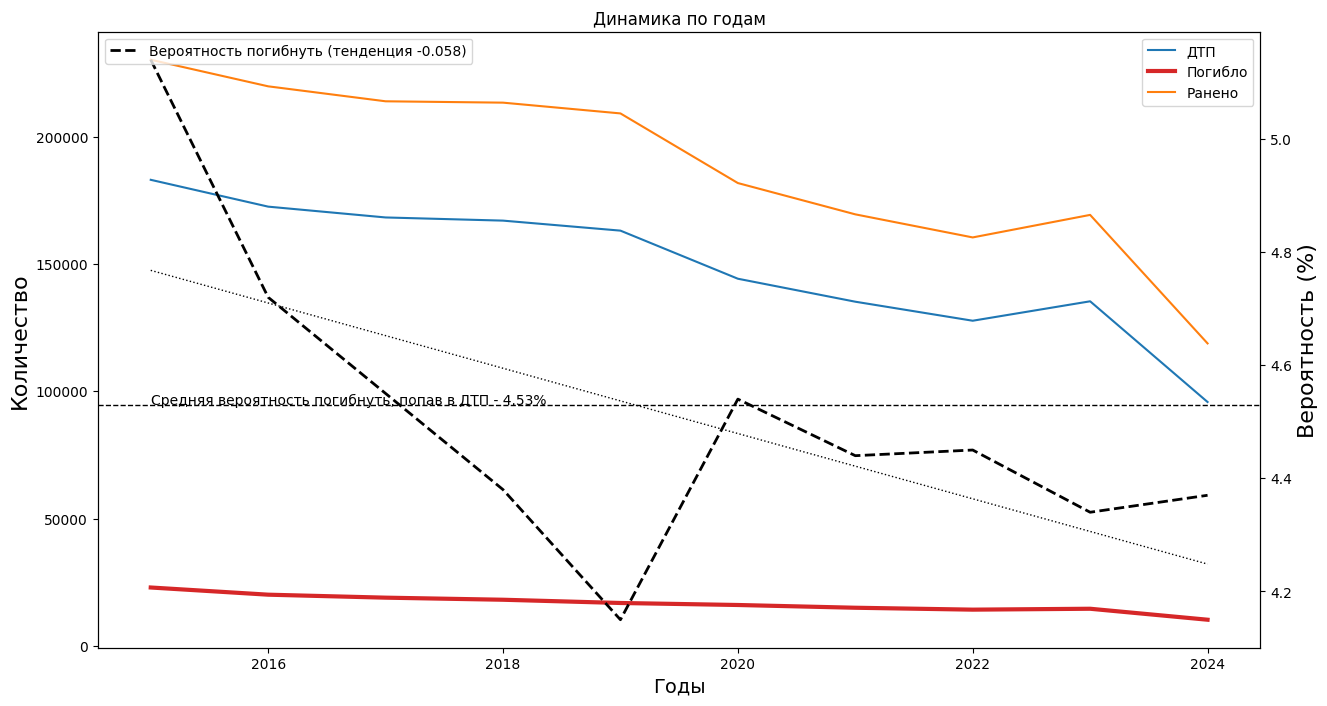

In [81]:
dd = data.groupby('year').agg({'dtp_id': 'count',
                               'dead_count' : 'sum',
                               'injured_count' : 'sum',
                               'participants_count' : 'sum'})

factor_dynamics(dd)

Основные показателеи ДТП в последние 9 лет имеют тенденцию на снижение. Это не может не радовать.

Динамика основных показателей по дням

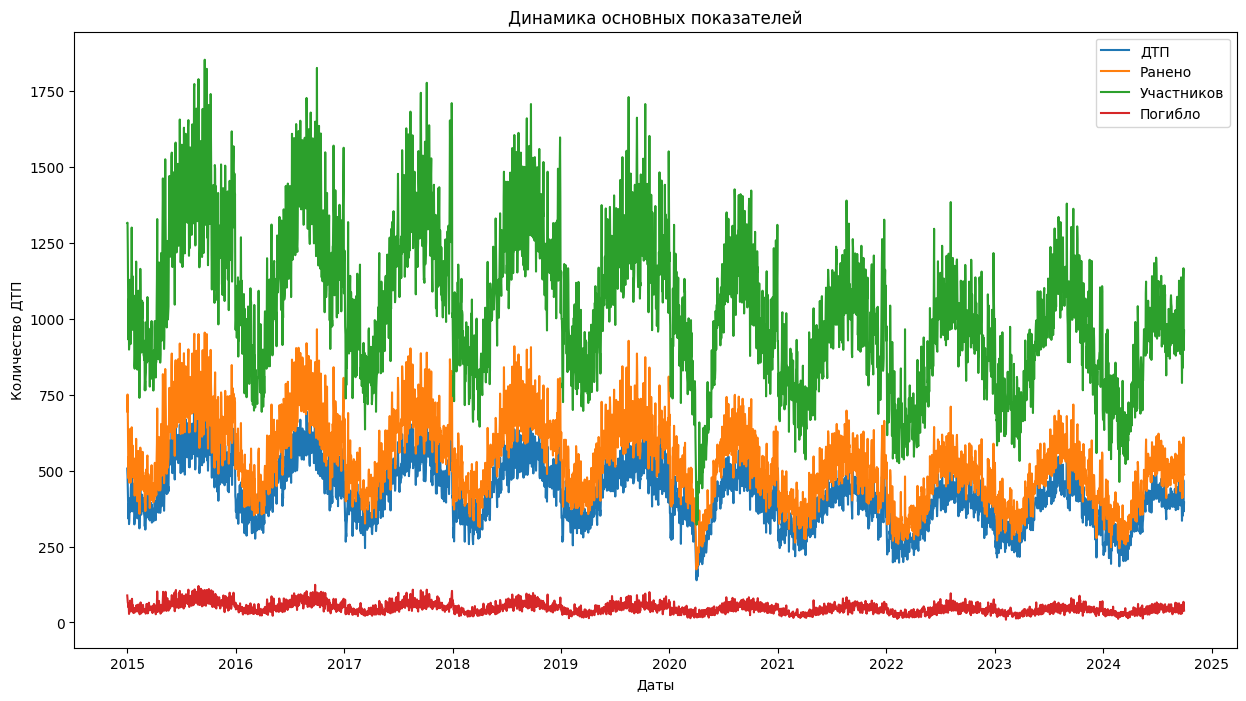

In [82]:
plt.figure(figsize=(15,8))
dd = data.groupby('date').agg({'dtp_id': 'count',
                               'injured_count' : 'sum',
                               'participants_count' : 'sum',
                               'dead_count' : 'sum'})
plt.plot(dd, label = ['ДТП', 'Ранено', 'Участников', 'Погибло'])
plt.title('Динамика основных показателей')
plt.ylabel('Количество ДТП')
plt.xlabel('Даты')
plt.legend()
plt.show()

Динамика основных показателей по дням не очень наглядна, но видна некоторая периодичность. Похоже, есть различия в количестве ДТП по месяцам / дням недели.

Интересно, что на графике примерно в первой трети 2020 года виден относительно глубокий "провал". Скорее всего, это последствия ограничений на перемещение в начале эпидемии COVID-19

### Распределение ДТП по месяцам и дням недели

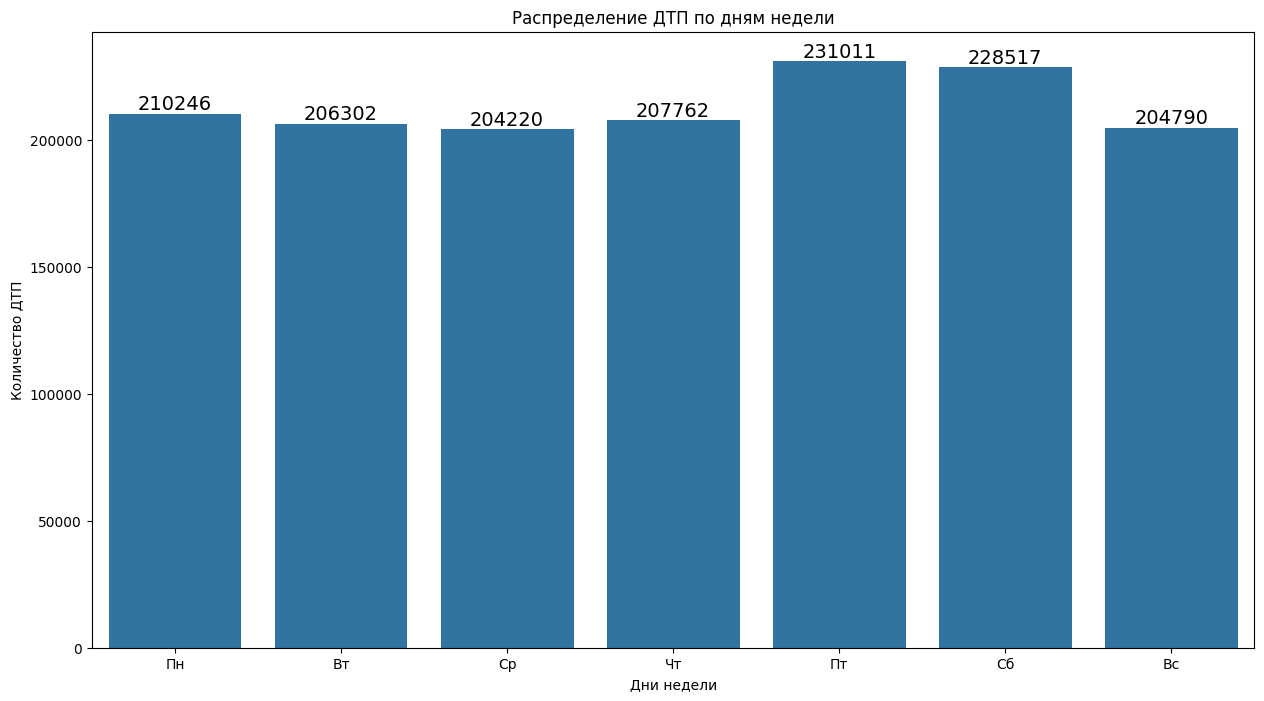

In [83]:
plt.figure(figsize=(15,8))
dd = data.groupby('weekday', as_index=False)['dtp_id'].count().sort_values(by='weekday', ascending=True)
dd['weekday'] = dd['weekday'].replace({0: 'Пн', 1 : 'Вт', 2 : 'Ср', 3 : 'Чт', 4 : 'Пт', 5 : 'Сб', 6 : 'Вс'})
ax = sns.barplot(x=dd['weekday'], y=dd['dtp_id'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=14,label_type='edge', color='black')
plt.title('Распределение ДТП по дням недели')
plt.ylabel('Количество ДТП')
plt.xlabel('Дни недели')
plt.show()

В пятницу и субботу происходит больше ДТП, чем в другие дни

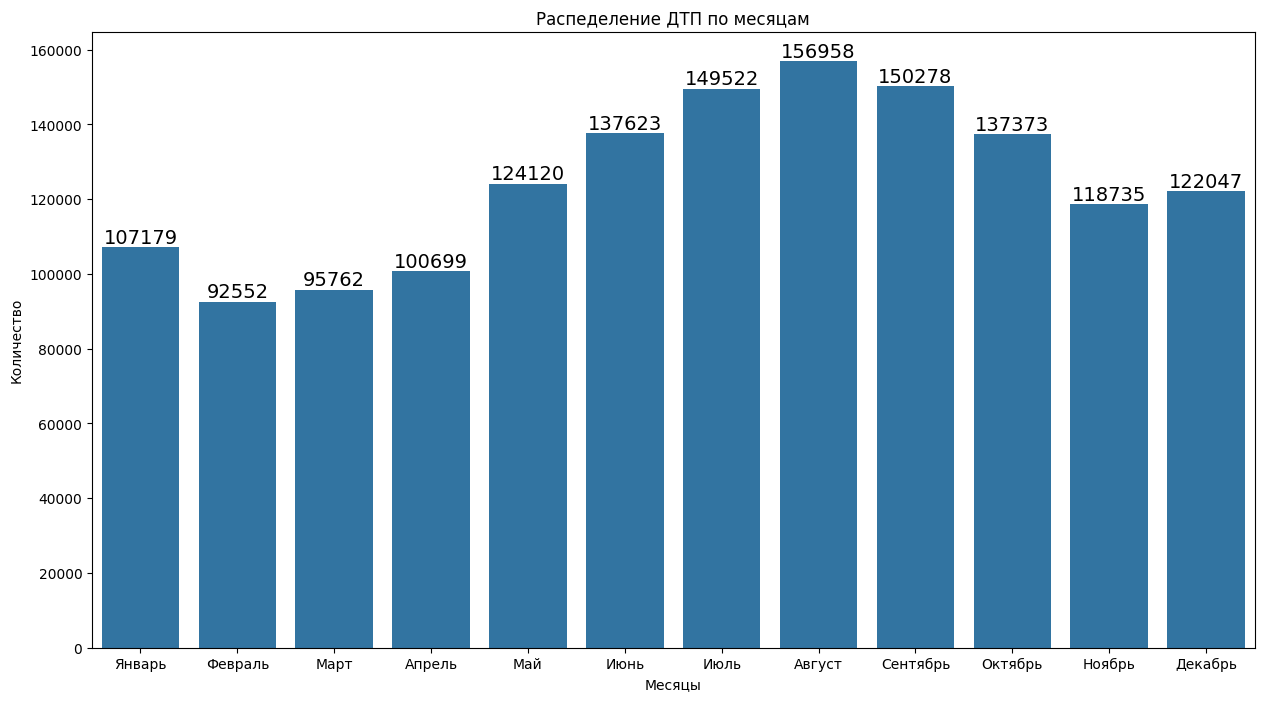

In [84]:
plt.figure(figsize=(15,8))
dd = data.groupby('month', as_index=False)['dtp_id'].count().sort_values(by='month', ascending=True)
dd['month'] = dd['month'].replace({1: 'Январь', 2 : 'Февраль', 3 : 'Март', 4 : 'Апрель',
                                   5 : 'Май', 6 : 'Июнь', 7 : 'Июль', 8 : 'Август',
                                   9 : 'Сентябрь', 10 : 'Октябрь', 11 : 'Ноябрь', 12 : 'Декабрь'})
ax = sns.barplot(x=dd['month'], y=dd['dtp_id'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=14,label_type='edge', color='black')
plt.title('Распеделение ДТП по месяцам')
plt.ylabel('Количество')
plt.xlabel('Месяцы')
plt.show()

В летние и осенние месяцы ДТП происходит заметно больше, чем зимой и весной

### Территории антилидеры по количеству ДТП, раненых и погибших

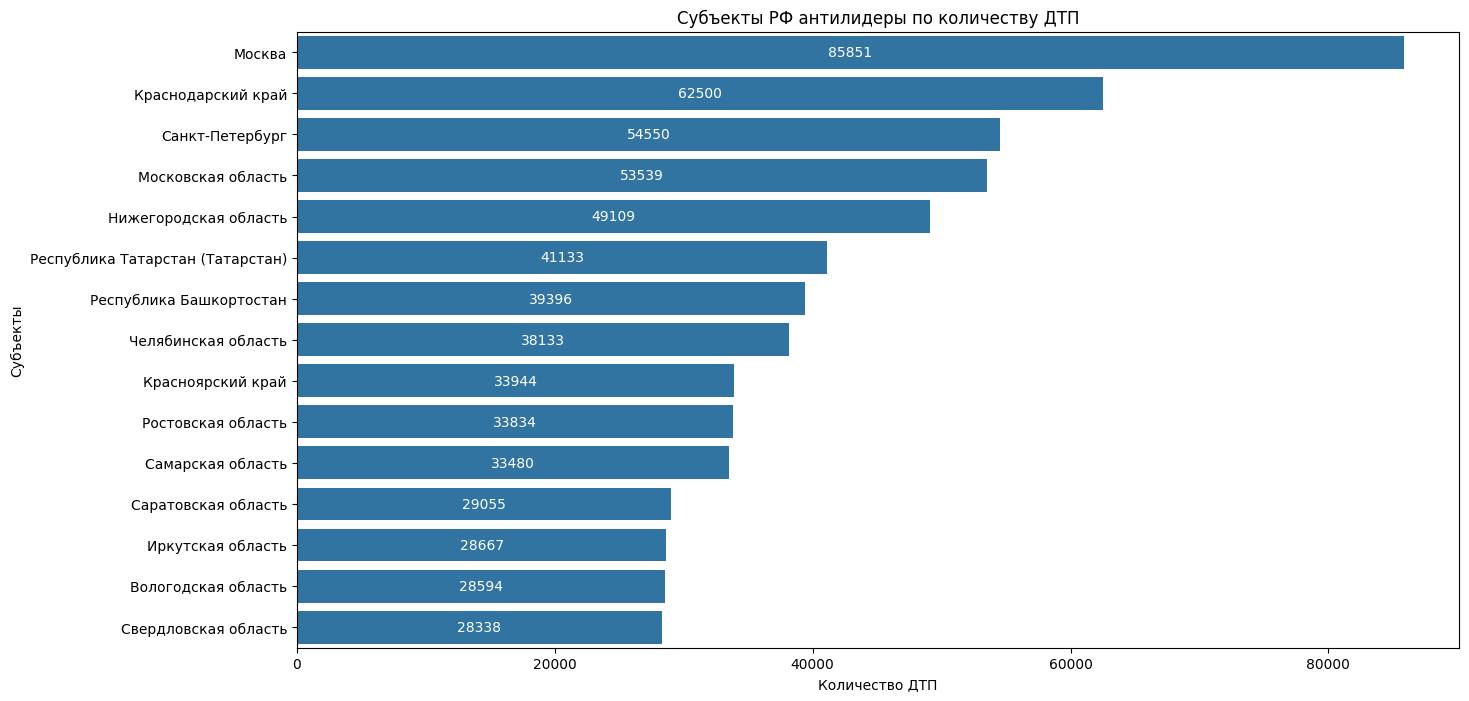

In [85]:
plt.figure(figsize=(15,8))
dd = data.groupby('parent_region', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False).head(15)
ax = sns.barplot(x=dd['dtp_id'], y=dd['parent_region'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Субъекты РФ антилидеры по количеству ДТП')
plt.ylabel('Субъекты')
plt.xlabel('Количество ДТП')
plt.show()

Москва и московская область более чем в два раза превосходят второго и третьего антилидера - Краснодарский край и Санкт-Петербург

Территории антилидеры с разбивкой по количеству раненых и погибших

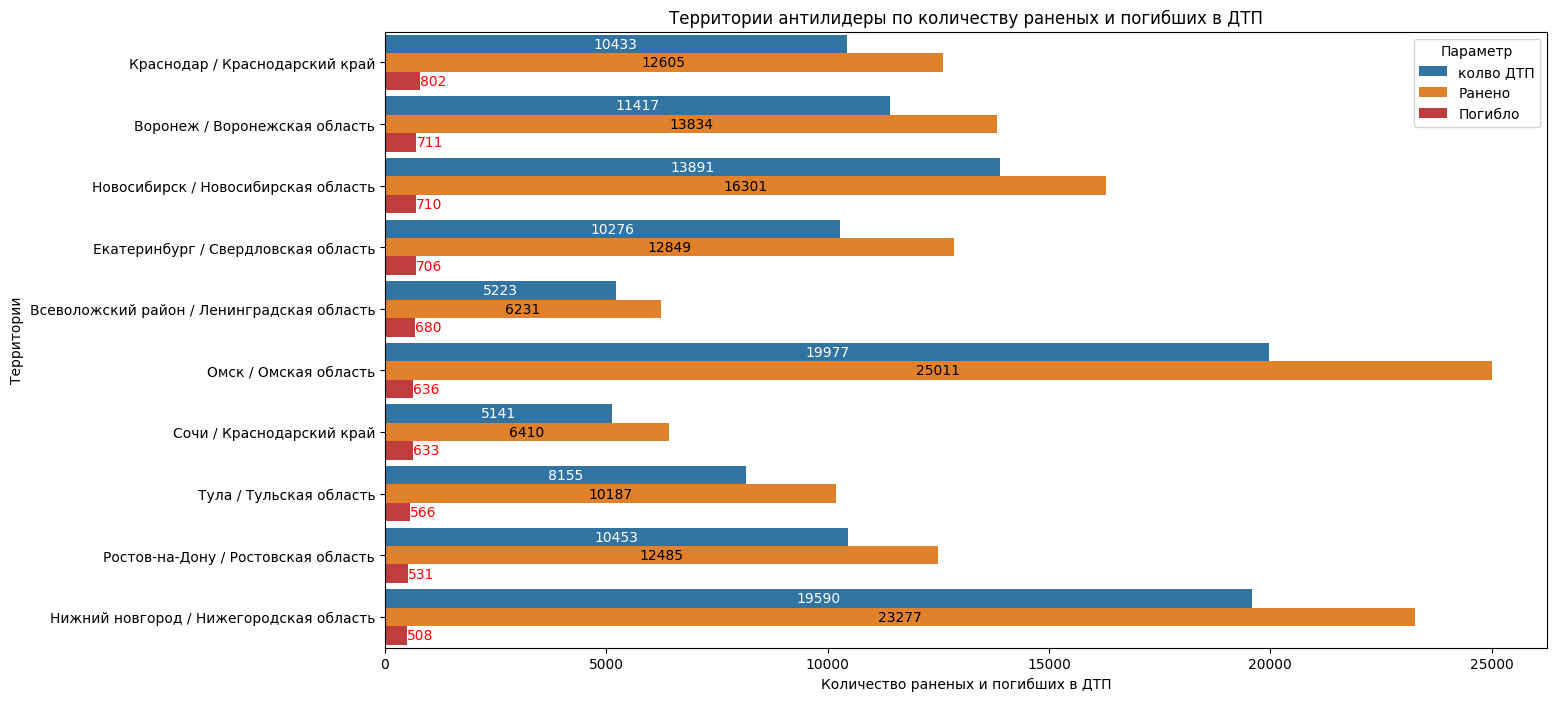

In [86]:
plt.figure(figsize=(15,8))

dd = data.groupby(['parent_region', 'region'], as_index=False)\
  .agg({'dtp_id' : 'count', 'injured_count' : 'sum', 'dead_count' : 'sum'})\
  .sort_values(by='dead_count', ascending=False).head(10)
dd['region'] = dd['region'] + ' / ' + dd['parent_region']
dd = dd.drop(columns = 'parent_region')

dd = dd.rename(columns={'dtp_id' : 'колво ДТП', 'injured_count' : 'Ранено', 'dead_count' : 'Погибло'})
dd = dd.melt(id_vars="region", var_name="Параметр").reset_index(drop=True)

color = ['tab:blue', 'tab:orange', 'tab:red']

ax = sns.barplot(y='region', x='value', hue="Параметр", palette = color, width=0.9, data=dd)
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')
ax.bar_label(ax.containers[1], fontsize=10, label_type='center', color='black')
ax.bar_label(ax.containers[2], fontsize=10, label_type='edge', color='red')

plt.title('Территории антилидеры по количеству раненых и погибших в ДТП')
plt.ylabel('Территории')
plt.xlabel('Количество раненых и погибших в ДТП')
plt.show()

Краснодар (уже отдельно, а не в составе края) - лидер по количеству погибших, причем с значительным отрывом. Затем в антирейтинге регионов с наибольшим количеством жертв ДТП идут Воронеж, Новосибирск, Екатеринбург

### Доли последстий и результатов ДТП

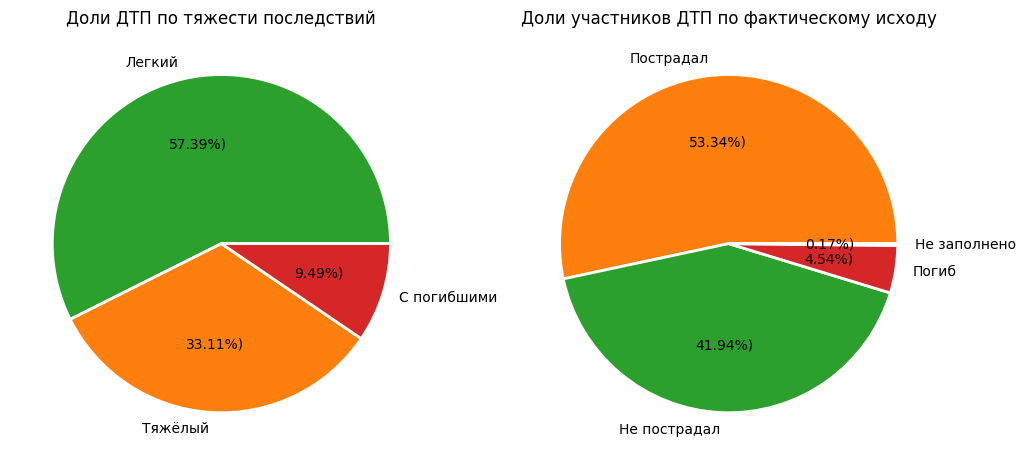

In [87]:
f, ax = plt.subplots(1, 2, figsize=(12,8))

dd = data['severity'].value_counts().reset_index()
dd['color'] = dd['severity'].replace({'С погибшими' : 'tab:red',
                    'Тяжёлый' : 'tab:orange',
                    'Легкий' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=False)

ax[0].pie(x = dd['count'], labels = dd['severity'], colors = dd['color'], wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
ax[0].set_title('Доли ДТП по тяжести последствий')

dd = partic['result'].value_counts().reset_index()
dd['color'] = dd['result'].replace({'Погиб' : 'tab:red',
                    'Пострадал' : 'tab:orange',
                    'Не пострадал' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=False)
ax[1].pie(x = dd['count'], labels = dd['result'], colors = dd['color'], wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
ax[1].set_title('Доли участников ДТП по фактическому исходу')


plt.show()

В каждом 10 ДТП гибнут люди. Каждый 20 участник дорожного движения, попавший в ДТП, погибает.

### Распределение ДТП по маркам участвовавших в них ТС

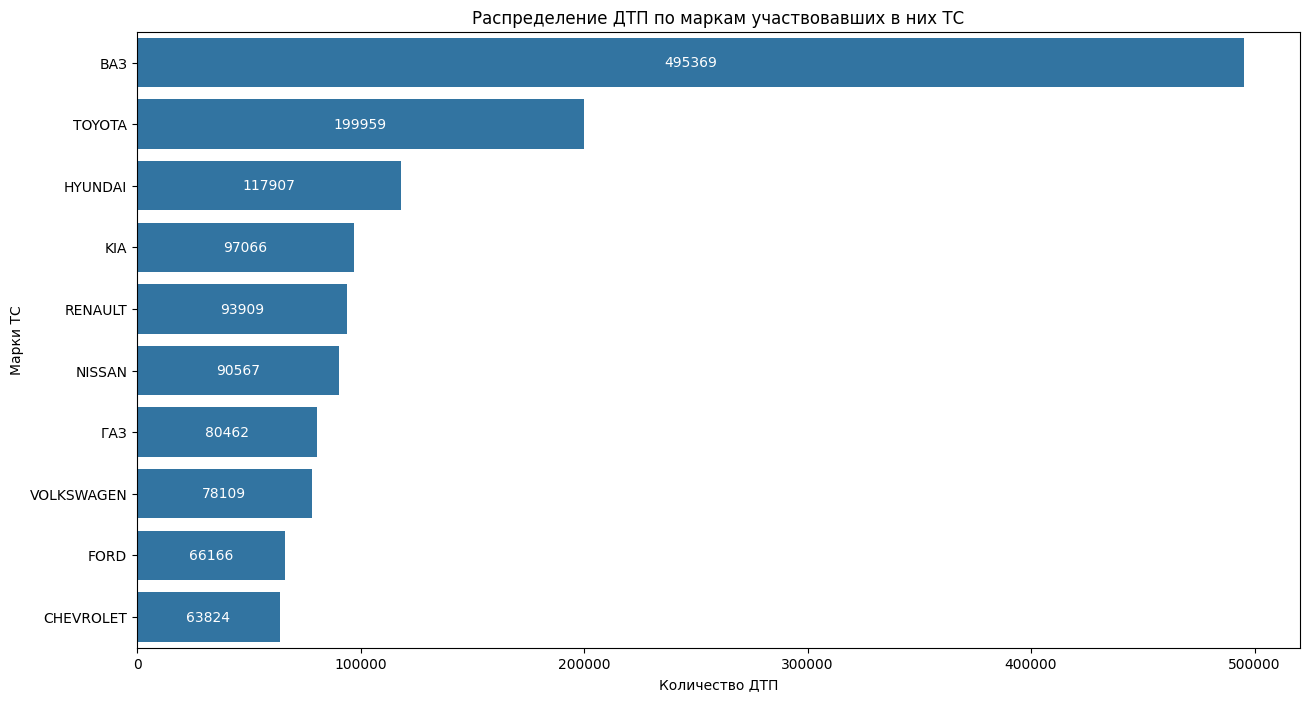

In [88]:
plt.figure(figsize=(15,8))
dd = cars.query('brand != "Прочие марки ТС"')\
      .groupby('brand', as_index=False)['dtp_id'].count()\
      .sort_values(by='dtp_id', ascending=False).head(10)

ax = sns.barplot(x=dd['dtp_id'], y=dd['brand'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Распределение ДТП по маркам участвовавших в них ТС')
plt.ylabel('Марки ТС')
plt.xlabel('Количество ДТП')
plt.show()

В лидерах ВАЗ - очевидно, потому что автомобилей из Тольятти на российских дорогах больше всего

### Модели ТС, наиболее часто попадающие в ДТП

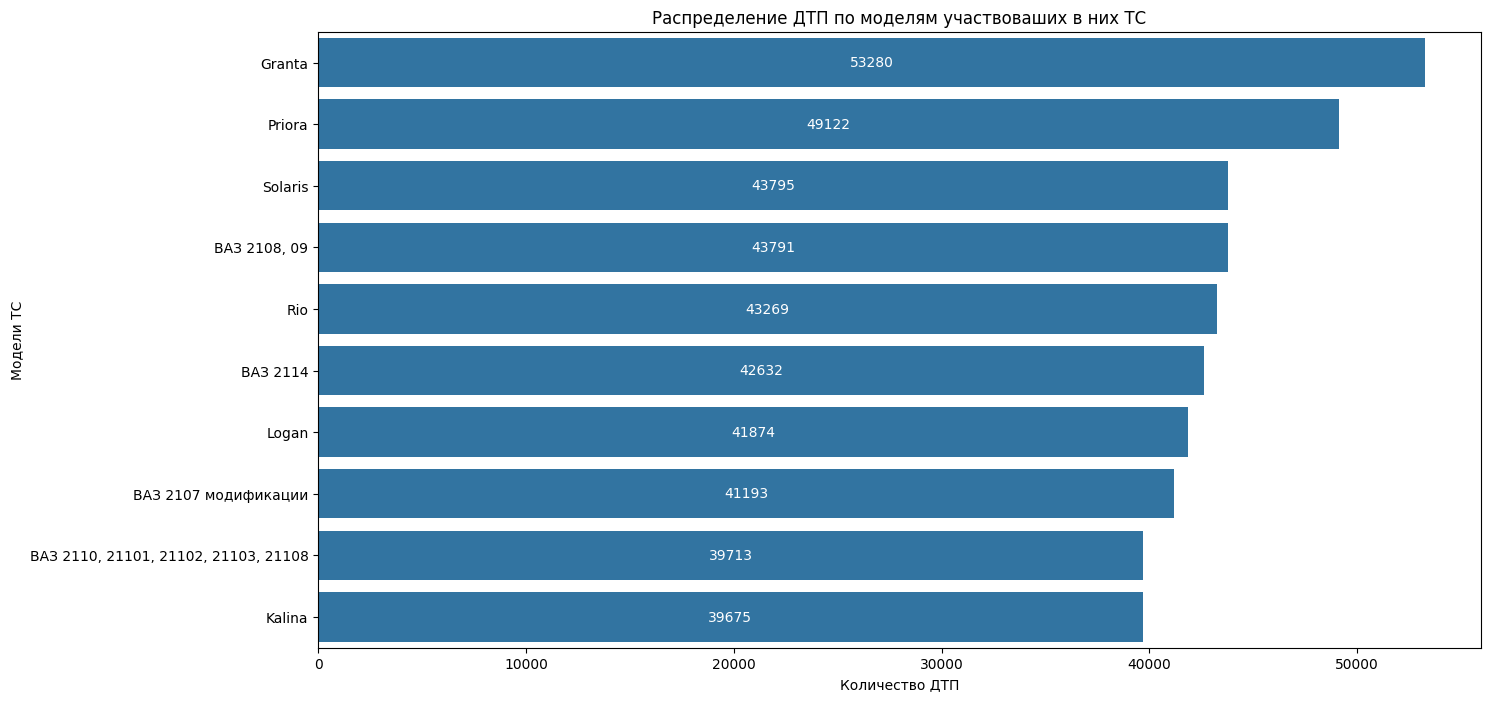

In [89]:
plt.figure(figsize=(15,8))
dd = cars.query('model != "Прочие модели"')\
    .groupby('model', as_index=False)['dtp_id'].count()\
    .sort_values(by='dtp_id', ascending=False).head(10)

ax = sns.barplot(x=dd['dtp_id'], y=dd['model'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Распределение ДТП по моделям участвоваших в них ТС')
plt.ylabel('Модели ТС')
plt.xlabel('Количество ДТП')
plt.show()

Распределение ДТП по моделям также в пользу ВАЗовских машин, а также тройки самых распространных иномарок - Rio, Solaris, Logan

### Распределение ДТП по количеству участвовавших в них ТС

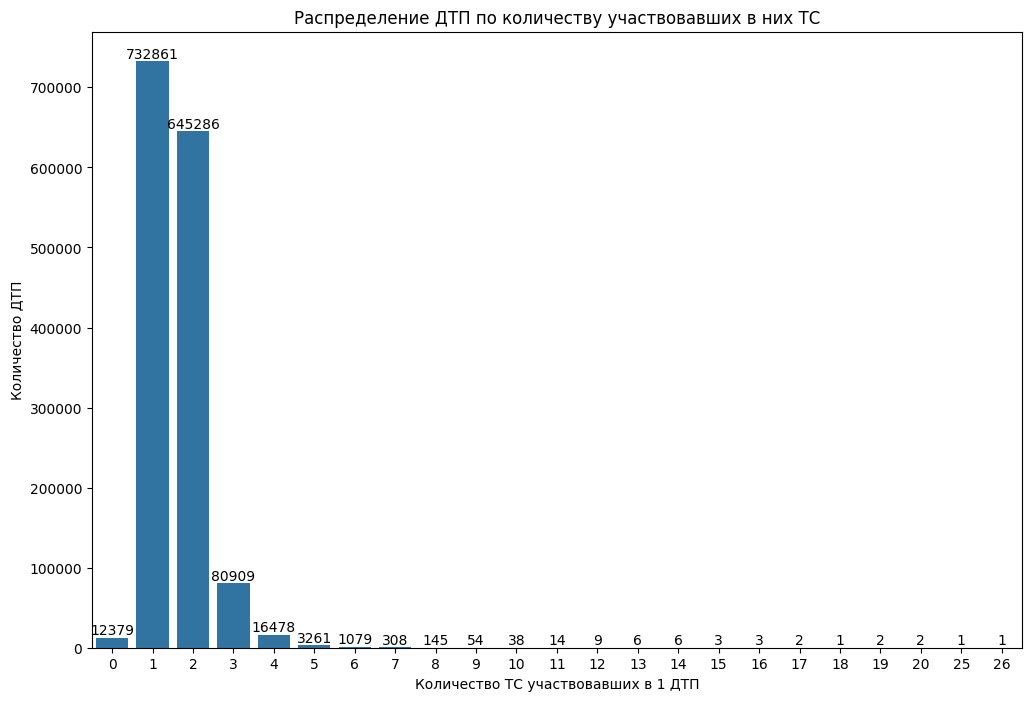

In [90]:
plt.figure(figsize=(12,8))
dd = data.groupby('cars_count', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False)
ax = sns.barplot(x=dd['cars_count'], y=dd['dtp_id'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10,label_type='edge', color='black')

plt.title('Распределение ДТП по количеству участвовавших в них ТС')
plt.ylabel('Количество ДТП')
plt.xlabel('Количество ТС участвовавших в 1 ДТП')
plt.show()

Чаще всего в ДТП участвуют 1-2 транспортное средство.

Есть и ДТП без ТС. Скорее всего, это наезд на пешехода, после которого, видимо, водители скрылись и их так и не нашли

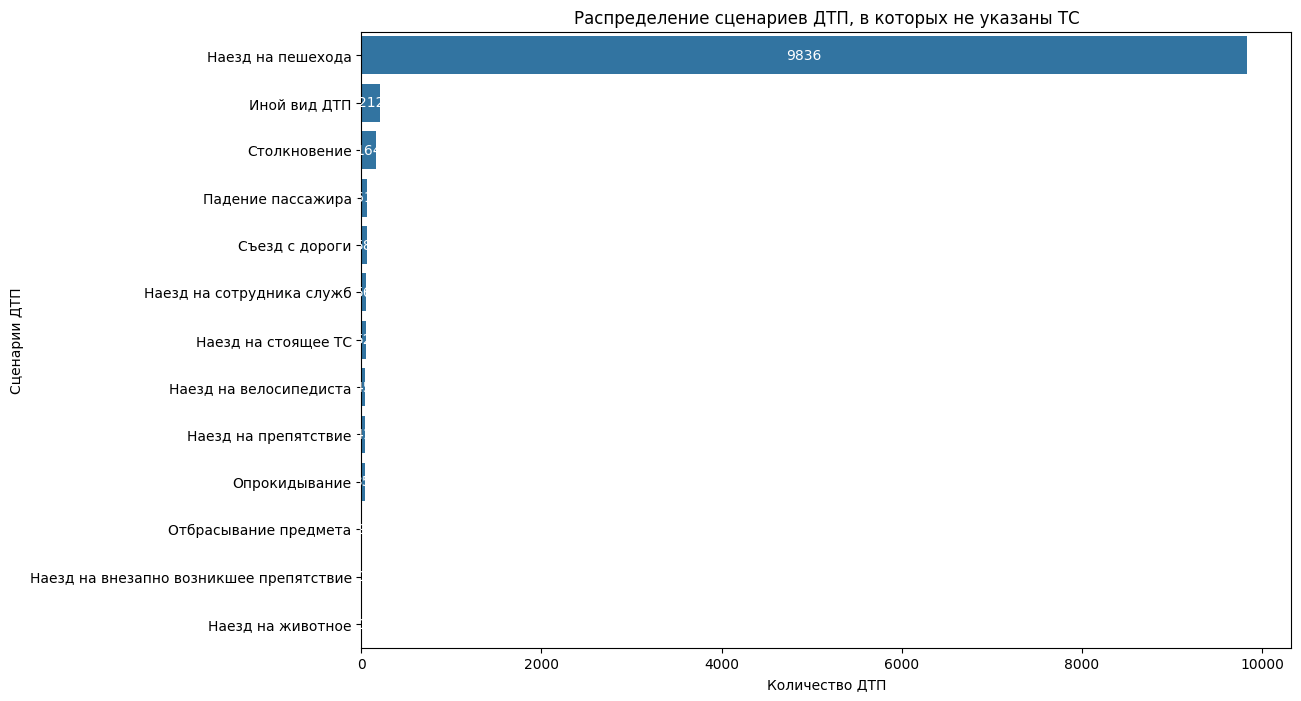

In [91]:
plt.figure(figsize=(12,8))
partic_0cars = set(partic[partic['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]['dtp_id'])
dd = data[data['dtp_id'].isin(partic_0cars)].groupby('category', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False)
ax = sns.barplot(x=dd['dtp_id'], y=dd['category'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10 ,label_type='center', color='white')

plt.title('Распределение сценариев ДТП, в которых не указаны ТС')
plt.ylabel('Сценарии ДТП')
plt.xlabel('Количество ДТП')
plt.show()


Действительно 80% ДТП, в которых не указано ТС - наезды на пешеходов.

### Распределение раненых и погибших по сценариям ДТП

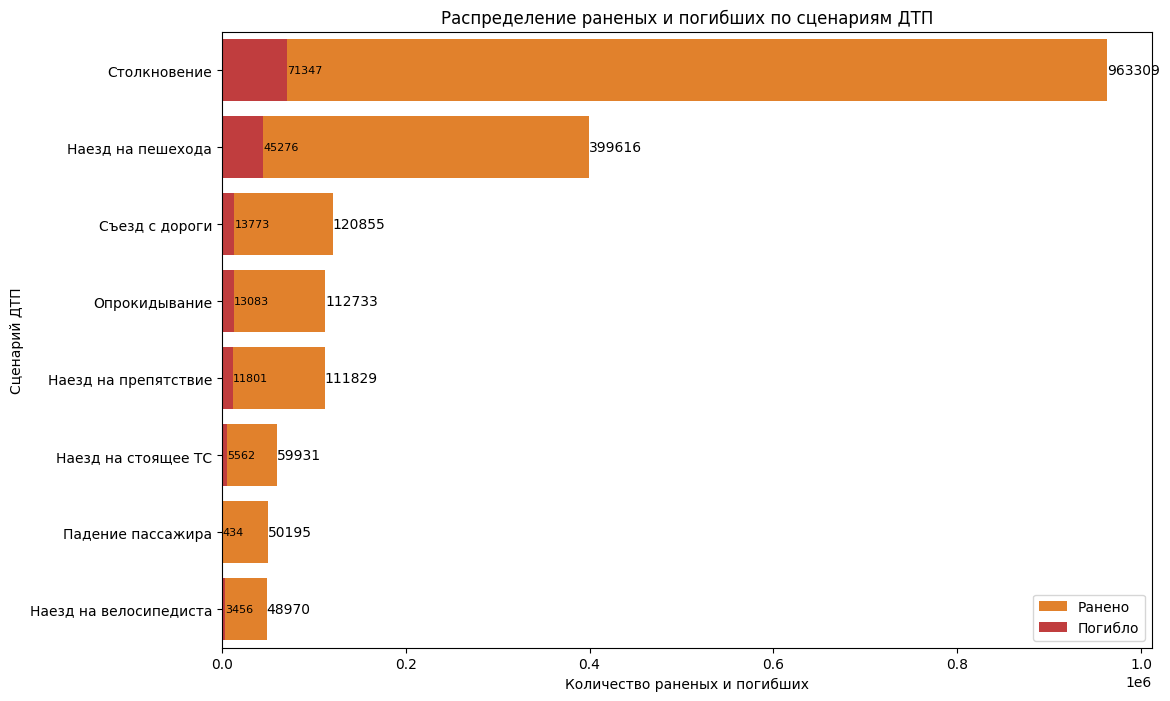

In [92]:
plt.figure(figsize=(12,8))
dd = data.groupby('category', as_index=False)\
  .agg({'injured_count' : 'sum', 'dead_count' : 'sum'})\
  .sort_values(by='injured_count', ascending=False).head(8)
dd = dd.rename(columns={'injured_count' : 'Ранено', 'dead_count' : 'Погибло'})

ax = sns.barplot(x="Ранено",  y="category", data=dd, color='tab:orange', label = "Ранено")
ax = sns.barplot(x="Погибло",  y="category", data=dd, color='tab:red', label = "Погибло")
ax.bar_label(ax.containers[0], fontsize=10 ,label_type='edge', color='black')
ax.bar_label(ax.containers[1], fontsize=8 ,label_type='edge', color='black')
plt.title('Распределение раненых и погибших по сценариям ДТП')
plt.ylabel('Сценарий ДТП')
plt.xlabel('Количество раненых и погибших')
plt.legend()
plt.show()

Столкновения и наезды на пещеходов - самые частые сценарии ДТП

### Рядом с какими объектами больше всего происходит ДТП

In [93]:
%%time
obj = pd.DataFrame(columns=['nearby', 'dtp_count'])
all_obj = set('; '.join(data['nearby'].unique()).split('; '))
i = 0
l = len(all_obj)
print(f'Всего видов объектов {l}')
for o in all_obj:
    print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
    if o == 'Не заполнено' : continue
    if o == 'Иной объект' : continue
    obj.loc[i, 'nearby'] = o
    obj.loc[i, 'dtp_count'] = data.query('nearby.str.contains(@o, regex=False)')['dtp_id'].nunique()
    i +=1
print()

Всего видов объектов 50
Выполнено - 96.0 %
CPU times: user 28.3 s, sys: 146 ms, total: 28.4 s
Wall time: 28.7 s


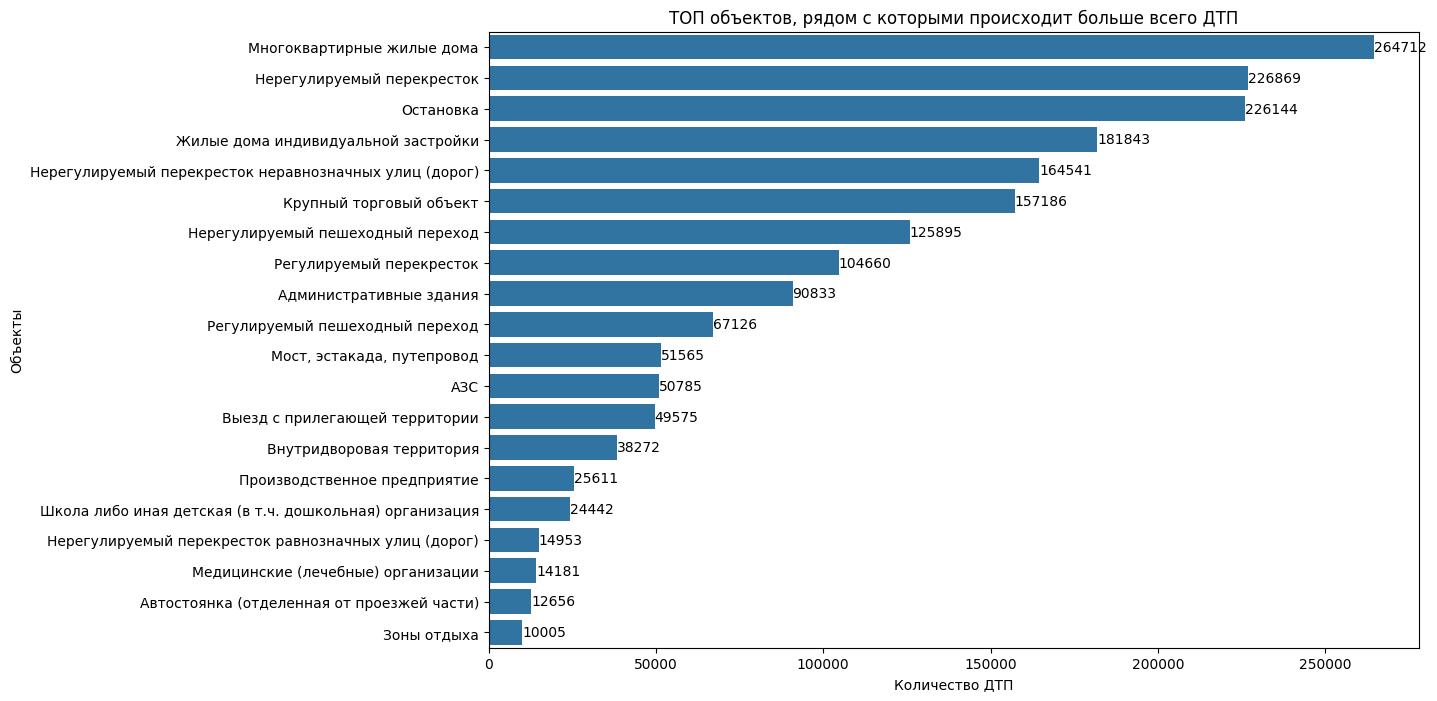

In [94]:
obj = obj.sort_values(by = 'dtp_count', ascending=False).head(20)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=obj['dtp_count'], y=obj['nearby'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('ТОП объектов, рядом с которыми происходит больше всего ДТП')
plt.ylabel('Объекты')
plt.xlabel('Количество ДТП')
plt.show()

В ТОПе мест, где проиходит ДТП жилые дома, остановки общественного транспортра и перекрестки. Примечателно, что на нерегулируемых перекрестках ДТП проиходит в два раза больше, чем на регулируемых.

### При каком состоянии дорог происходит больше всего ДТП

In [95]:
%%time
rc = pd.DataFrame(columns=['road_conditions', 'dtp_count'])
all_rc = set('; '.join(data['road_conditions'].unique()).split('; '))
i = 0
l = len(all_rc)
print(f'Всего видов состояний дороги {l}')
for r in all_rc:
    print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
    if r == 'Не заполнено' : continue
    if r == 'Иные недостатки' : continue
    rc.loc[i, 'road_conditions'] = r
    rc.loc[i, 'dtp_count'] = data.query('road_conditions.str.contains(@r, regex=False)')['dtp_id'].nunique()
    i +=1
print()

Всего видов состояний дороги 41
Выполнено - 97.56 %
CPU times: user 20.7 s, sys: 174 ms, total: 20.9 s
Wall time: 21.2 s


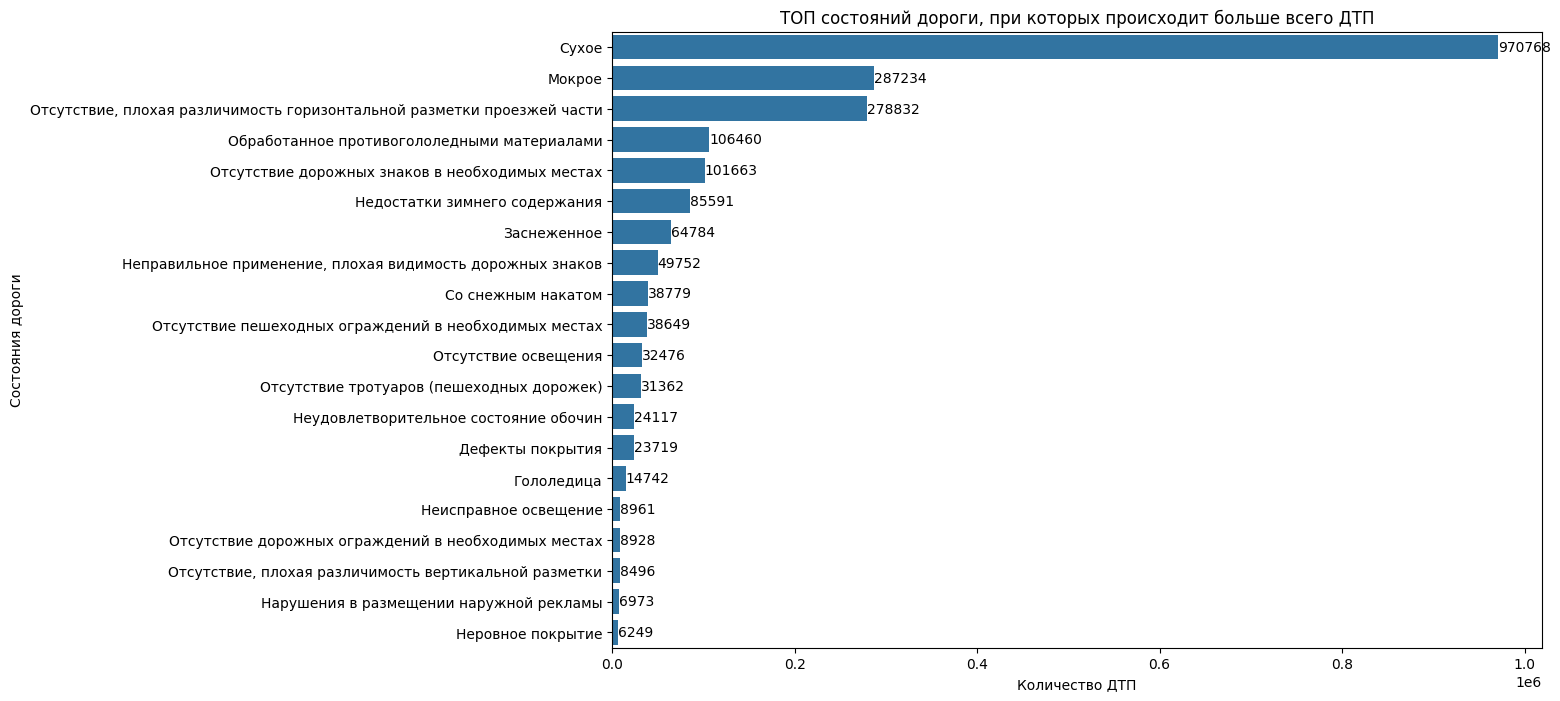

In [96]:
rc = rc.sort_values(by = 'dtp_count', ascending=False).head(20)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=rc['dtp_count'], y=rc['road_conditions'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('ТОП состояний дороги, при которых происходит больше всего ДТП')
plt.ylabel('Состояния дороги')
plt.xlabel('Количество ДТП')
plt.show()

Подавлющее количество ДТП происходит на сухой дороге. Стоит отметить, что очень много ДТП происходит там, где не видно дорожную разметку, либо нет дорожных знаков.

### Доля мужчин и женщин в различных ролях ДТП

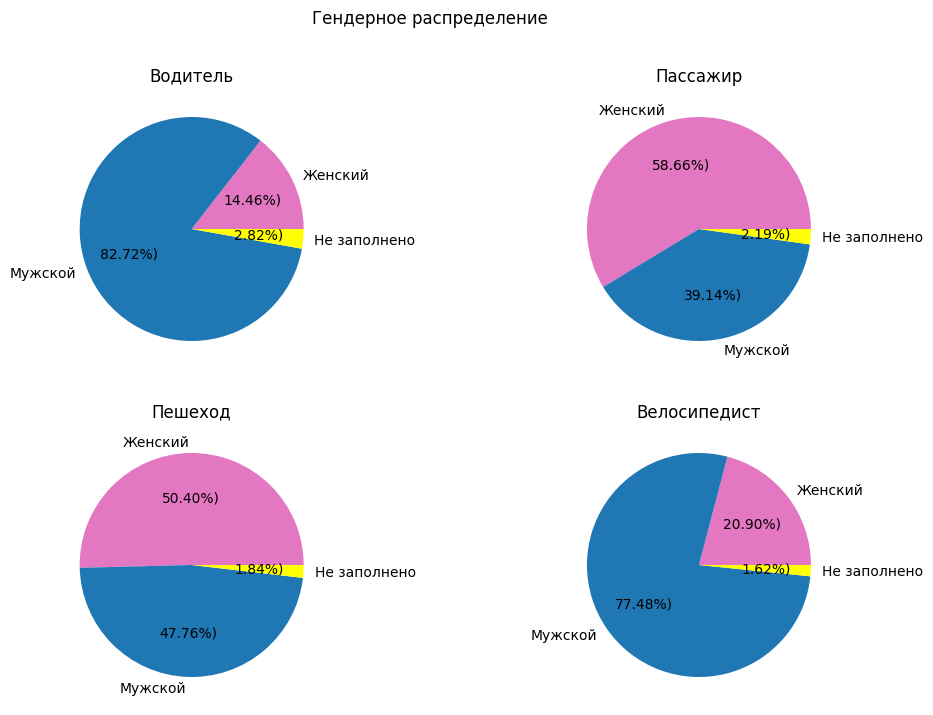

In [97]:
roles = ('Водитель', 'Пешеход', 'Пассажир', 'Велосипедист')
f, ax = plt.subplots(2, 2, figsize=(12,8))
x = 0
y = 0
colors = ['tab:pink', 'tab:blue', 'yellow']
labels = ['Женский', 'Мужской', 'Не заполнено']
for r in roles:
    dd = partic.query('role.str.match(@r)').groupby('gender')['partic_id'].count()
    ax[x, y].pie(x = dd, labels = labels,  autopct=lambda p : '{:.2f}%)'.format(p), colors = colors)
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0

plt.suptitle('Гендерное распределение')
plt.show()

Водителей больше мужчин, а пассажиров - женщин. При этом для пешеходов гендерное разделение практические одинакое.

### Доля исходов для различных ролей участников ДТП

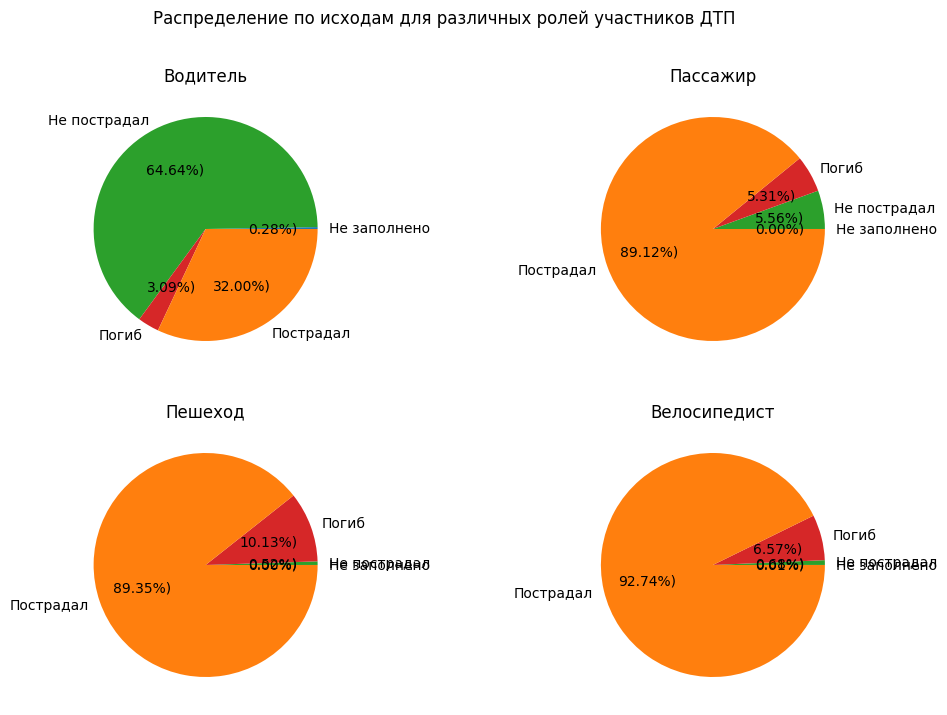

In [98]:
f, ax = plt.subplots(2, 2, figsize=(12,8))
x = 0
y = 0
#colors = ['tab:red', 'tab:orange', 'tab:green', 'yellow']
labels = ['Погиб', 'Пострадал', 'Не пострадал', 'Не заполнено']
for r in roles:
    dd = partic.query('role.str.match(@r)')\
        .groupby('result', as_index = False)['partic_id'].count().sort_values(by = 'result')

    dd['color'] = dd['result'].replace({'Погиб' : 'tab:red',
                    'Пострадал' : 'tab:orange',
                    'Не пострадал' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=True)

    ax[x, y].pie(x = dd['partic_id'], labels = dd['result'], colors = dd['color'], autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0

plt.suptitle('Распределение по исходам для различных ролей участников ДТП')
plt.show()

Интересно, что среди водителей больше всего со статусом "Не пострадал". Наверно, это связно с тем, что водители должны остаться на месте ДТП, а пассажиры/пешеходы могут и уйти. Или их не включают в протокол, если не пострадали

### Водители с каким стажем чаще попадают в ДТП

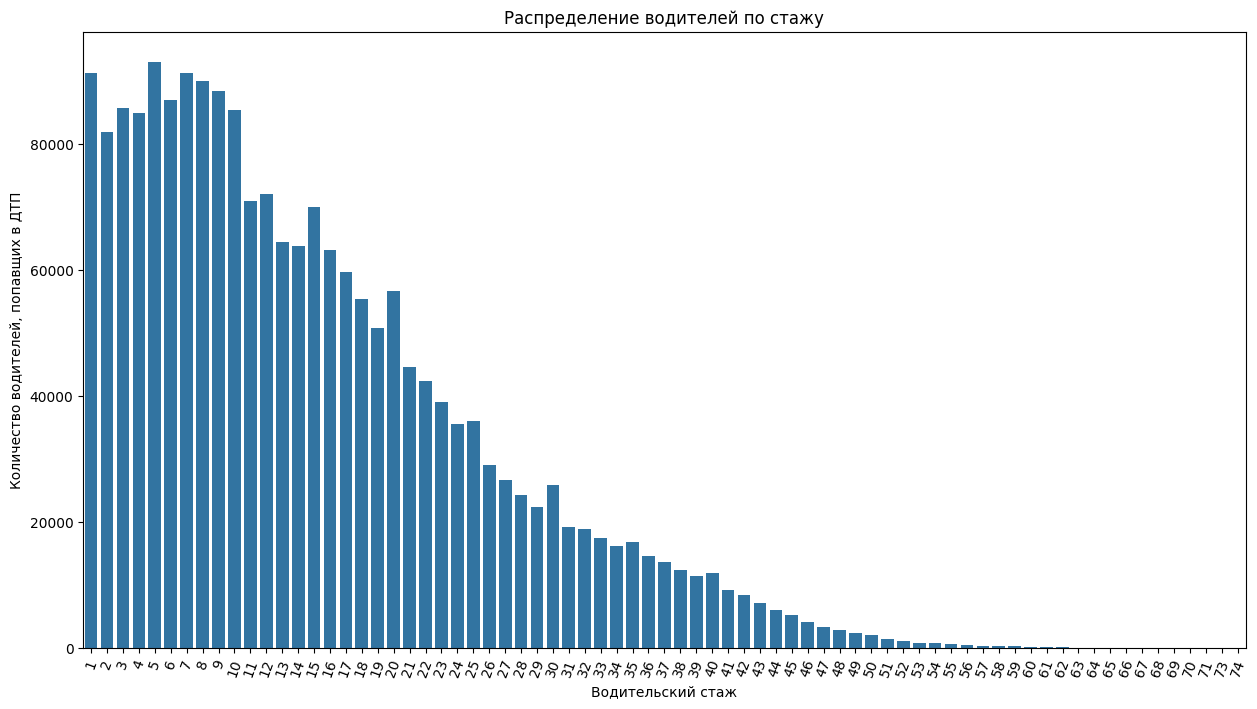

In [99]:
plt.figure(figsize=(15,8))

dd = partic[partic['years_of_driving_experience'] > 0].groupby('years_of_driving_experience', as_index = False)['partic_id'].count()
ax = sns.barplot(x=dd['years_of_driving_experience'], y=dd['partic_id'], color='tab:blue')
plt.xticks(rotation=70)
plt.title('Распределение водителей по стажу')
plt.ylabel('Количество водителей, попавщих в ДТП')
plt.xlabel('Водительский стаж')
plt.show()

Значительный спад количества ДТП в зависимости от водительсткого стажа наблюдается только у водителей со стажем более 10 лет. В первые годы водители попадают в ДТП примерно с одинаковой частотой. Но заметно, что в 2-4 годы водители попадают в ДТП чуть меньше.

### Доля нарушителей среди различных ролей участников ДТП

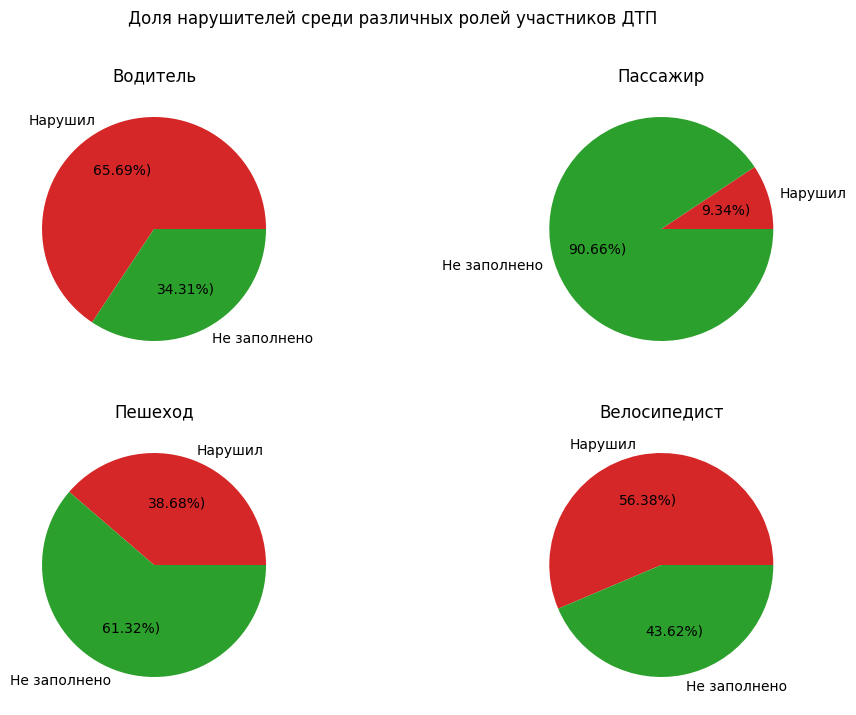

In [100]:
f, ax = plt.subplots(2, 2, figsize=(12,8))

colors = ['tab:red', 'tab:green', 'yellow']
x = 0
y = 0
for r in roles:
    p1 = partic.query('(role.str.match(@r)) & (violations != "Не заполнено")')['partic_id'].count()
    p2 = len(partic.query('role.str.match(@r)')) - p1
    ax[x, y].pie(x = [p1, p2], labels = ['Нарушил', 'Не заполнено'],  colors = colors, autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0
plt.suptitle('Доля нарушителей среди различных ролей участников ДТП')
plt.show()

Интересно, что у пассажиров тоже бывают нарушения
Посмотрим, что это за нарушения

In [101]:
partic.query('role == "Пассажир" & violations != "Не заполнено"')\
    .groupby('violations', as_index=False)['partic_id'].count()\
    .sort_values(by='partic_id', ascending=False).head(15)

violations  \
10                                                                                       Нарушение правил применения ремней безопасности пассажиром   
8                                                                                             Нарушение правил пользования общественным транспортом   
0                                                                                                                                    Иные нарушения   
9                                                                                                  Нарушение правил применения мотошлема пассажиром   
3                                                                        Иные нарушения; Нарушение правил применения ремней безопасности пассажиром   
13                                                              Оставление движущегося транспортного средства выход или выпрыгивание на ходу и т.д.   
2                                                                                  Иные нарушения; Нарушение правил применения мотошлема пассажиром   
22                                                                                  Передача управления ТС лицу, находящемуся в состоянии опьянения   
20  Оставление движущегося транспортного средства выход или выпрыгивание на ходу и т.д.; Нарушение правил применения ремней безопасности пассажиром   
25                                                                                  Создание помех для водителя в управлении транспортным средством   
1                                                                             Иные нарушения; Нарушение правил пользования общественным транспортом   
24                      Передача управления ТС лицу, находящемуся в состоянии опьянения; Нарушение правил применения ремней безопасности пассажиром   
30                      Создание помех для водителя в управлении транспортным средством; Нарушение правил применения ремней безопасности пассажиром   
14                                              Оставление движущегося транспортного средства выход или выпрыгивание на ходу и т.д.; Иные нарушения   
11                                Нарушение правил применения ремней безопасности пассажиром; Нарушение правил пользования общественным транспортом   

    partic_id  
10      42544  
8       13599  
0       10203  
9        8530  
3        2249  
13        644  
2         643  
22        339  
20        234  
25        229  
1         129  
24         95  
30         83  
14         75  
11         67

### Самые часто встречающиеся нарушения ПДД при ДТП

In [102]:
%%time
vd = pd.DataFrame(columns=['violations', 'dtp_count'])
all_violations = set('; '.join(partic['violations'].unique()).split('; '))
i = 0
l = len(all_violations)
print(f'Всего пунктов нарушений ПДД {l}')
for v in all_violations:
    print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
    if v == '' : continue
    if v == 'Не заполнено' : continue
    if v == 'Иные нарушения' : continue
    #if v == viol_code['Не заполнено;'][:-1] : continue
    #if v == viol_code['Иные нарушения;'][:-1] : continue
    vd.loc[i, 'violations'] = v #v[:50]+'..'
    vd.loc[i, 'dtp_count'] = partic.query('violations.str.contains(@v, regex=False)')['dtp_id'].nunique()
    i +=1
print()


Всего пунктов нарушений ПДД 105
Выполнено - 98.1 %
CPU times: user 2min 41s, sys: 1.07 s, total: 2min 42s
Wall time: 2min 44s


In [103]:
#Раскодирование нарушений
#vd['violations'] = vd['violations'] + '; '
#vd['violations'] = vd['violations'].replace(code_viol, regex = True)
vd['violations'] = vd['violations'].str[:50]+'...'

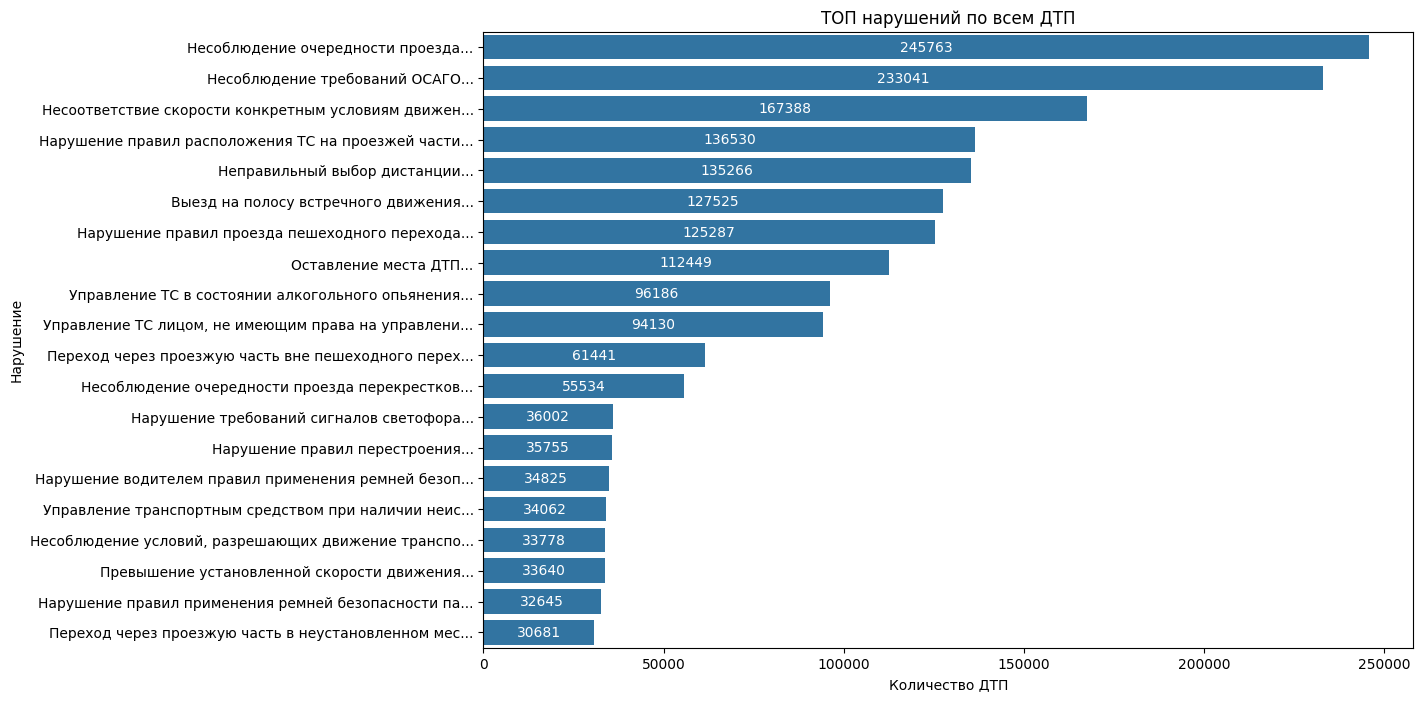

In [104]:
vd = vd.sort_values(by = 'dtp_count', ascending=False).head(20)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=vd['dtp_count'], y=vd['violations'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('ТОП нарушений по всем ДТП')
plt.ylabel('Нарушение')
plt.xlabel('Количество ДТП')
plt.show()

Проезд прекрестков, превышенеи скорости, неправильная дистанция, неправильное расположение на проезжей части - вот нарушения ПДД которые чаще становятся причиной ДТП

Интересно, что на втором месте нарушений при ДТП - несоблюдение требований ОСАГО

### Как много водителей попавших в ДТП были без ОСАГО

In [105]:
print('Доля водителей попавших в ДТП без ОСАГО %',
        round(100 * partic.query('violations.str.contains("ОСАГО", regex=False)')['dtp_id'].nunique()
         / partic.query('role == "Водитель"')['dtp_id'].nunique(), 2))

Доля водителей попавших в ДТП без ОСАГО % 15.74


In [106]:
notosago = set(partic.query('violations.str.contains("ОСАГО", regex=False)')['dtp_id'].unique())

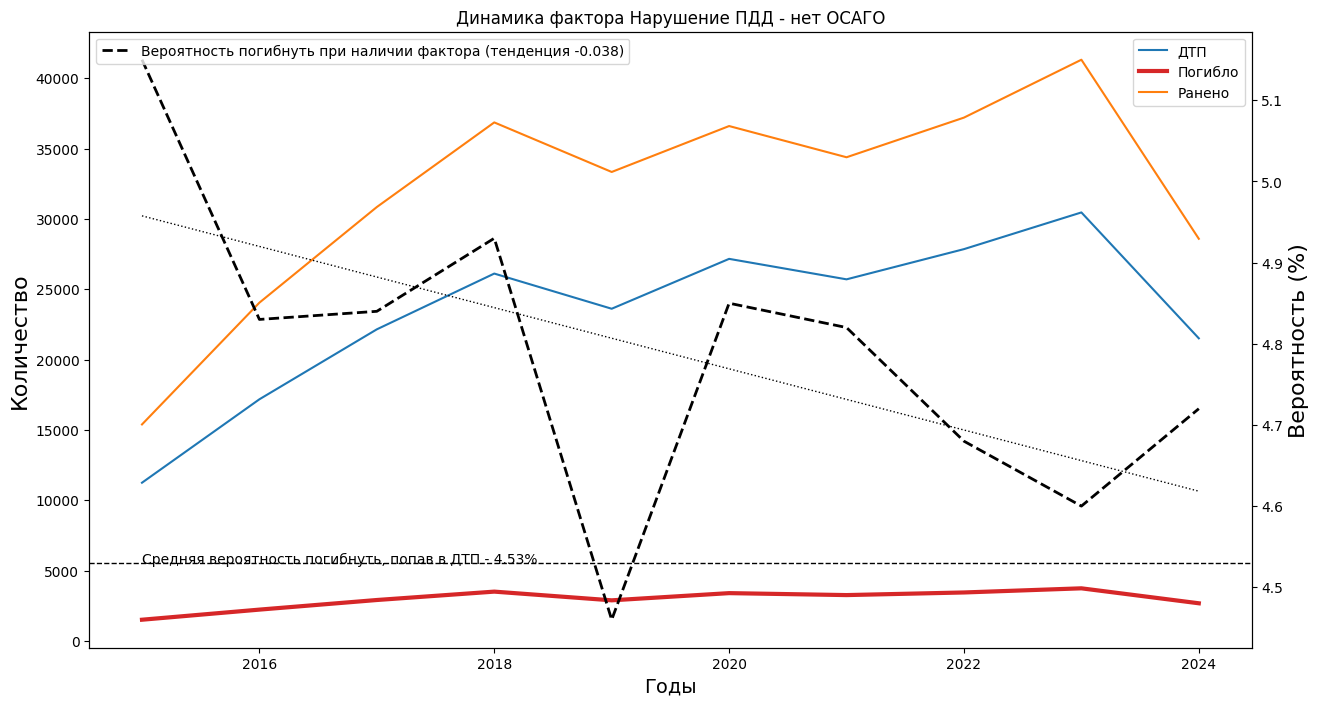

In [107]:

dd = data[data['dtp_id'].isin(notosago)].groupby('year').agg({'dtp_id': 'count',
                               'dead_count' : 'sum',
                               'injured_count' : 'sum',
                               'participants_count' : 'sum'})

factor_dynamics(dd, 'violations', 'нет ОСАГО')

И как видно из графика, идет рост таких ДТП, а вместе с этим и тендеция к росту вероятностb погибнуть в таком ДТП

In [108]:
notosago = None

### Доля погибших относительно времени приезда скорой на место ДТП

Счиатется, что современная медицина способная спасти раненых при ДТП, лишь бы пострадавшего довезли до больницы

In [109]:
dead_time = partic[partic['result'] == 'Погиб']['health_status'].value_counts()
dead_time = dead_time.reset_index()

In [110]:
dead_time.loc[dead_time['health_status'] == 'Скончался в течение 1 суток', 'health_status'] = 'Скончался в первые сутки'
dead_time.loc[dead_time['health_status'] == 'Скончался в течение 2 суток', 'health_status'] = 'Скончался во вторые сутки'
dead_time.loc[dead_time['health_status'].str.contains('Скончался в течение'), 'health_status'] = 'Скончался позже'
dead_time.loc[dead_time['health_status'].str.contains('до приезда скорой'), 'health_status'] = 'Скончался до приезда скорой'
dead_time.loc[dead_time['health_status'].str.contains('до транспортировки'), 'health_status'] = 'Скончался до транспортировки'
dead_late = dead_time.loc[dead_time['health_status'] == 'Скончался позже']['count'].sum()
dead_time.loc[dead_time['health_status'] == 'Скончался позже', 'count'] = dead_late
dead_time = dead_time.drop_duplicates()

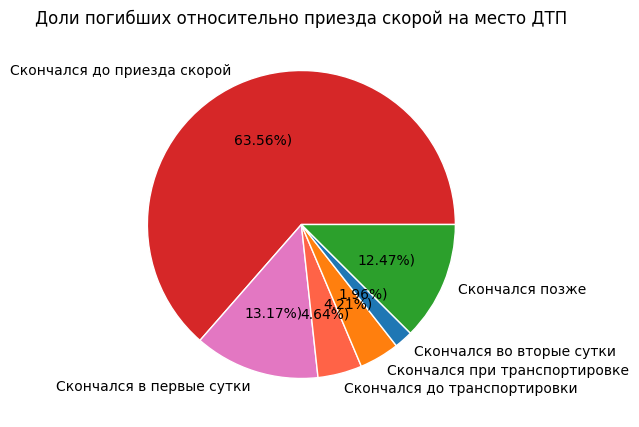

In [111]:
plt.figure(figsize=(12,5))

dd = dead_time
dd['color'] = dd['health_status'].replace({'Скончался до приезда скорой' : 'tab:red',
                    'Скончался до транспортировки' : 'tomato',
                    'Скончался при транспортировке' : 'tab:orange',
                    'Скончался в первые сутки' : 'tab:pink',
                    'Скончался во вторые сутки' : 'tab:blue',
                    'Скончался позже' : 'tab:green'
                    }, regex=False)

plt.pie(x = dd['count'], labels = dd['health_status'], colors = dd['color'], wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли погибших относительно приезда скорой на место ДТП')


plt.show()

Большинство жертв ДТП гибнет еще до приезда скорой помощи

### Динамика "пьяных" ДТП и последствий от них

Оценим динамику "пьяных" ДТП. Очевидно, их количество должно снижаться с общей тенденцией снижения количества аварий и после введения более жестких штрафов. Поэтому "оценим" пьяные ДТП еще и по накопителной тяжести последсвий от таких  ДТП.

Накопительная тяжесть последствий ДТП рассчитывается как сумма баллов, в зависимости от тяжести одно ДТП "Легкий" - 1, "Тяжелый" - 2, "С погибшими" - 3

In [112]:
alco_dtp_all = partic.query('violations.str.contains("опьянения")')['dtp_id'].unique()

In [113]:
alco_dtp_by_month = data[data['dtp_id'].isin(alco_dtp_all)].groupby(['year','month']).agg({'dtp_id': 'count', 'severity_id': 'sum'})
notalco_dtp_by_month = data[~data['dtp_id'].isin(alco_dtp_all)].groupby(['year','month']).agg({'dtp_id': 'count', 'severity_id': 'sum'})

In [114]:
alco_dtp_by_month.columns = ['dtp_count', 'severity_sum']
notalco_dtp_by_month.columns = ['dtp_count', 'severity_sum']
alco_dtp_by_month['severity_1dtp'] = alco_dtp_by_month['severity_sum'] / alco_dtp_by_month['dtp_count']
notalco_dtp_by_month['severity_1dtp'] = notalco_dtp_by_month['severity_sum'] / notalco_dtp_by_month['dtp_count']

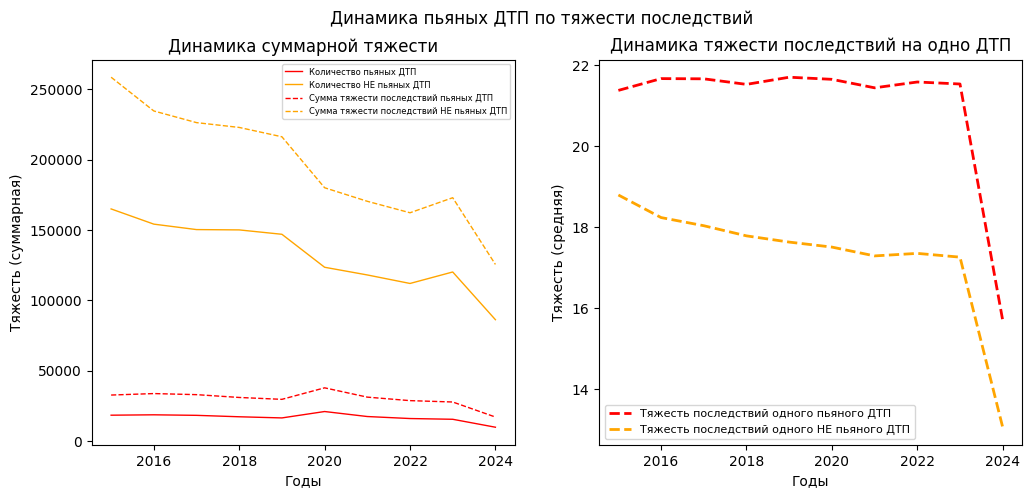

In [115]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

alco_dtp_by_month.groupby(['year'])['dtp_count'].sum().plot(ax=axes[0],
                label = "Количество пьяных ДТП", color='red', linestyle = 'solid', linewidth = 1)
notalco_dtp_by_month.groupby(['year'])['dtp_count'].sum().plot(ax=axes[0],
                label = "Количество НЕ пьяных ДТП", color='orange', linestyle = 'solid', linewidth = 1)
alco_dtp_by_month.groupby(['year'])['severity_sum'].sum().plot(ax=axes[0],
                label = "Сумма тяжести последствий пьяных ДТП", color='red', linestyle = '--',  linewidth = 1)
notalco_dtp_by_month.groupby(['year'])['severity_sum'].sum().plot(ax=axes[0],
                label = "Сумма тяжести последствий НЕ пьяных ДТП", color='orange',linestyle = '--',  linewidth = 1)
axes[0].set_xlabel('Годы')
axes[0].set_ylabel('Тяжесть (суммарная)')
axes[0].legend(loc='upper right', fontsize = 6)
axes[0].set_title('Динамика суммарной тяжести')

axes[1] = alco_dtp_by_month.groupby(['year'])['severity_1dtp'].sum().plot(ax=axes[1],
              label = "Тяжесть последствий одного пьяного ДТП", color='red', linewidth = 2, linestyle = '--')
axes[1] = notalco_dtp_by_month.groupby(['year'])['severity_1dtp'].sum().plot(ax=axes[1],
               label = "Тяжесть последствий одного НЕ пьяного ДТП", color='orange', linewidth = 2, linestyle = '--')
axes[1].set_xlabel('Годы')
axes[1].set_ylabel('Тяжесть (средняя)')
axes[1].legend(loc='lower left', fontsize = 8)
axes[1].set_title('Динамика тяжести последствий на одно ДТП')
plt.suptitle('Динамика пьяных ДТП по тяжести последствий')
plt.show()


Пьяных ДТП значительно меньше обычных, и они также имеют тенденцию к снижению, НО тяжесть последствий пьяных ДТП больше, и она держиться из года в год на одном уровне, тогда как тяжесть последсвий остальных ДТП снижается.

## *Промежуточные итоги*

*Основные параметры ДТП имеют тенденцию к снижению. 4.5% от всех попавших в ДТП людей - погибает, больше половины - получается травмы. Чаще всего в ДТП участвуют одно-два транспортных средства. Наибоеле распространенные сценарие ДТП - столкновение и наезд на пехеодов. Среди водителей, попавших в ДТП больше мужчн, а вот среди пешеходв доли мужчин и женщин почти одинаковы. Самые распросраненные нарушения, харакретные для аварий - "пьянка", "скорость", нарушения при проезде перекрестков. Количество пьяных ДТП снижается как и обычных, но тяжесть их последствий остается на одном уровне*

# **Факторы, при которых вероятность погибнуть, попав в ДТП, выше среднего**

**Оценим факторы, при которых высокая вероятность погибнуть, попав в ДТП. Напомним, имеется ввиду вероятность при условии уже случившегося ДТП. Вероятность погибнуть рассчитывается как количество погибших в ДТП при определенном факторе деленное на количество всех людей, которые участвовали в ДТП при данном факторе. Затем эту вероятность сравним с уровнем вероятности погибнуть, попав в ДТП, для всей выборке (около 4.5%). Для оценки статистической значимости различий двух вероятностей, по сути двух пропорций, используем Z-тест**

## *Внешние факторы повышенной вероятности смертельных ДТП (погода, дорожное покрытие, произошло рядом с ... )*

Формируем таблицу факторов

In [116]:
%%time
factors_all = factors('nearby')
factors_all = pd.concat([factors_all, factors('weather')])
factors_all = pd.concat([factors_all, factors('road_conditions')])
factors_all = factors_all.reset_index(drop = True)

Фактор nearby уникальных значений 50
Выполнено - 100.0 %-------------
Фактор weather уникальных значений 9
Выполнено - 100.0 %-------------
Фактор road_conditions уникальных значений 41
Выполнено - 100.0 %-------------
CPU times: user 1min 34s, sys: 640 ms, total: 1min 34s
Wall time: 1min 36s


Заносим в таблицу присущие факторам показатели ДТП

In [117]:
factors_all['dtp_per'] = round(100 * factors_all['dtp_count'] / all_dtp_count, 2)
factors_all['injured_per'] = round(100 * factors_all['injured_count'] / all_injured_count, 2)
factors_all['dead_per'] = round(100 * factors_all['dead_count'] / all_dead_count, 2)
factors_all['dead_p'] = round(100 * factors_all['dead_count'] / factors_all['participants_count'], 2)
factors_all['injured_p'] = round(100 * factors_all['injured_count'] / factors_all['participants_count'], 2)

Рассчитывает значения pvalue z-теста для каждого фактора

In [118]:
zkrit_to_all(factors_all)

Выполнено - 100.0 %


### ТОП внешних факторов по доли погибших при ДТП

Получилась таблица внешних факторов, при которых вероятность погибнуть, попав в ДТП, выше среднего. Оранжевым подсвечивается z-критерий, для которого p-value < 0.05. То есть превышение средней вероятности смерти для фактора этой строчки - стастический достоверно

In [119]:
top_dead_factors = factors_all[(factors_all['factor'] != 'Не заполнено')\
            & (factors_all['dtp_count'] > 100)\
            & (factors_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop = True)

factor_dead_table(top_dead_factors[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

В топе внешних факторов повышенной вероятности смертельных ДТП часто встречаются факторы связанные с видимостью - отсутствие освещения, отсутствие световозвращателей, природные ограничения (туман). Посмотрим, кого чаще попадает в ДТП с таким внешним фактором

In [120]:
dark_dtp = set(data.query('road_conditions.str.contains("освещен") | road_conditions.str.contains("световозвращ")')['dtp_id'])
dark_dtpresult = partic[partic['dtp_id'].isin(dark_dtp)].groupby(['role', 'result'], as_index = False)['partic_id'].count()

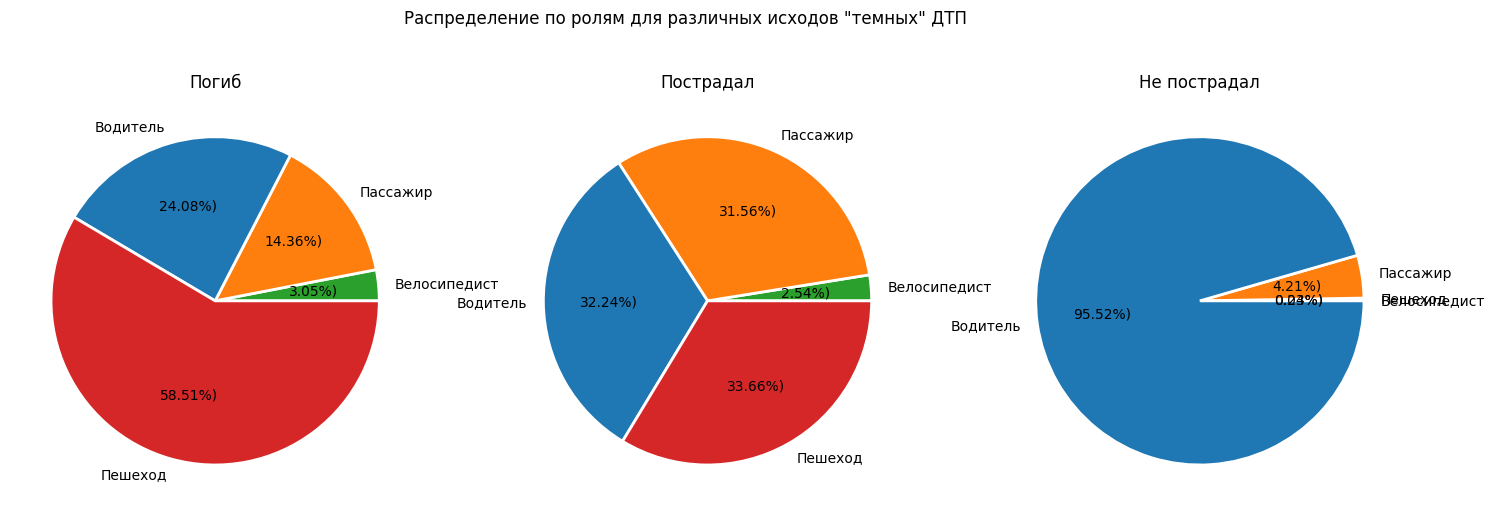

In [121]:
f, ax = plt.subplots(1, 3, figsize=(18,6))
x = 0
results = ('Погиб', 'Пострадал', 'Не пострадал')
for r in results:
    dd = dark_dtpresult.query('result == @r').sort_values(by = 'partic_id')


    dd['color'] = dd['role'].replace({'Водитель' : 'tab:blue',
                    'Пассажир' : 'tab:orange',
                    'Пешеход' : 'tab:red',
                    'Велосипедист' : 'tab:green'}, regex=True)

    ax[x].pie(x = dd['partic_id'], labels = dd['role'], colors = dd['color'],
              wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
              autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x].set_title(r)

    x +=1

plt.suptitle('Распределение по ролям для различных исходов "темных" ДТП')
plt.show()

В "темных" ДТП больше всего погибают или получают ранения пешеходы. Хотя таких ДТП относительно мало, работы по обеспечению освещеноости дорог - большая возможность по скрашению аварийности и смертности на дорогах.

Интересно, что в топе факторов повышенной вероятности погибнуть при ДТП присуствует соседство с кладбищем. Наверно, этому есть какое-то рациональное объяснение, но что-то на ум приходят только мистические

In [122]:
dark_dtp = None
dark_dtpresult = None

### Динамика ТОП внешних факторов по доли погибших в ДТП по годам

Посмотрим динамику основных показателей ДТП в разрезе топа факторов повышенной вероятности погибнуть при ДТП. Какието из них имеют тенденцию к снижению, а какието к повышению

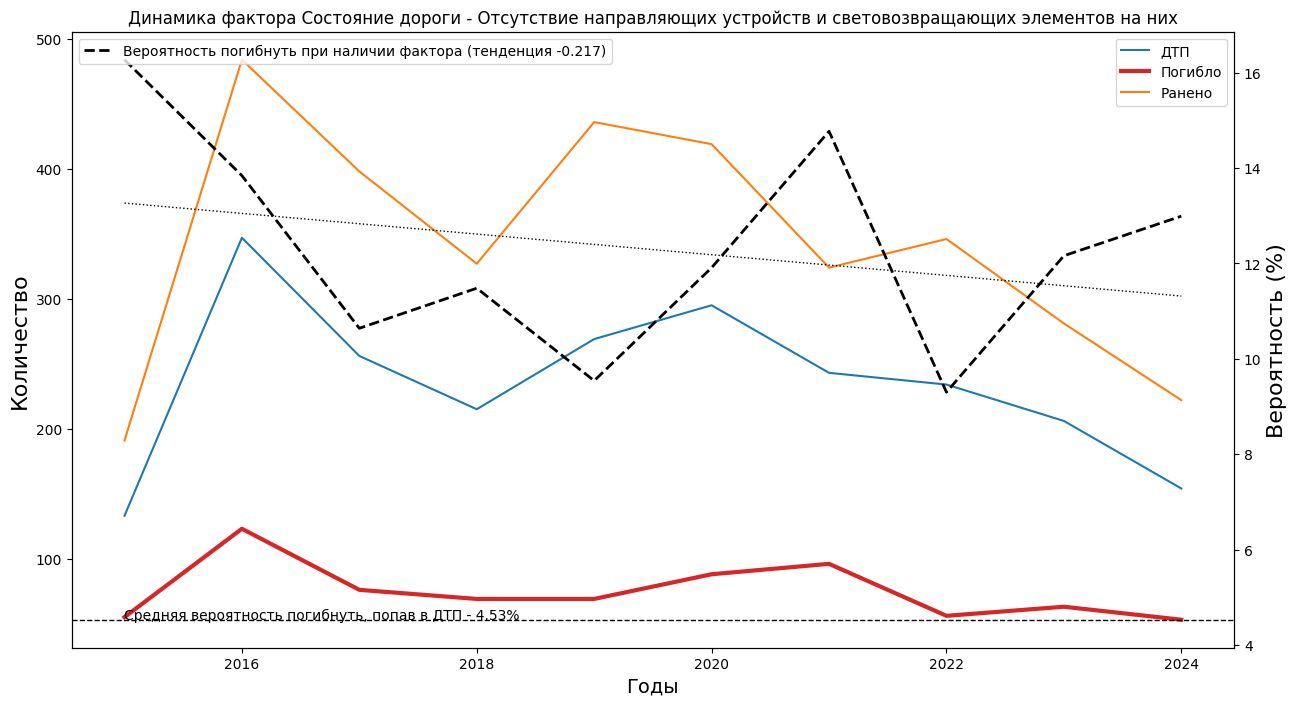

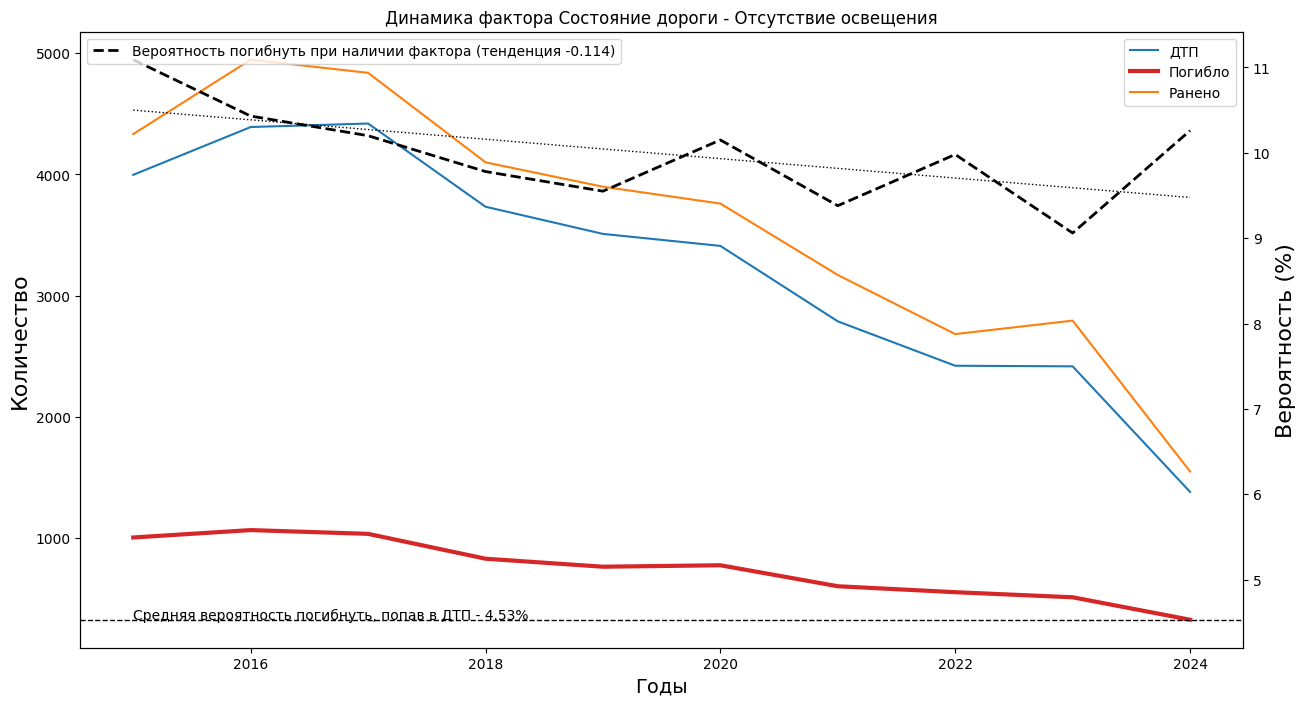

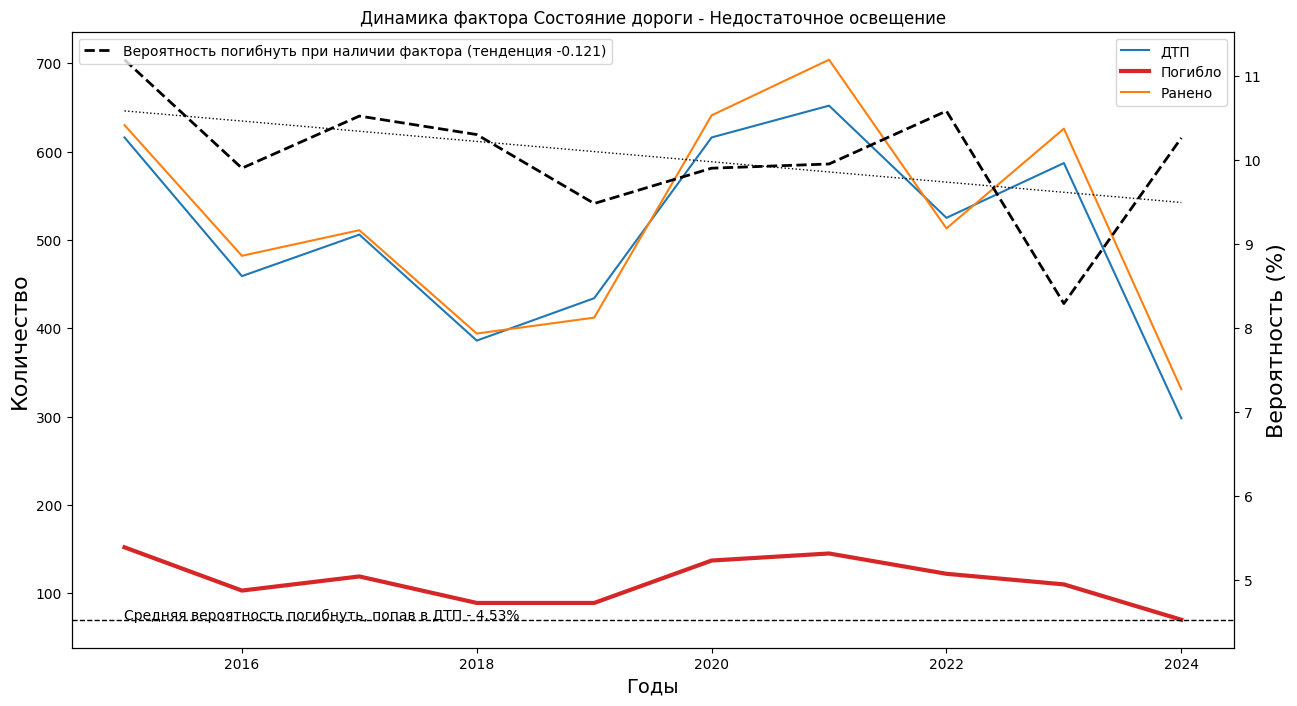

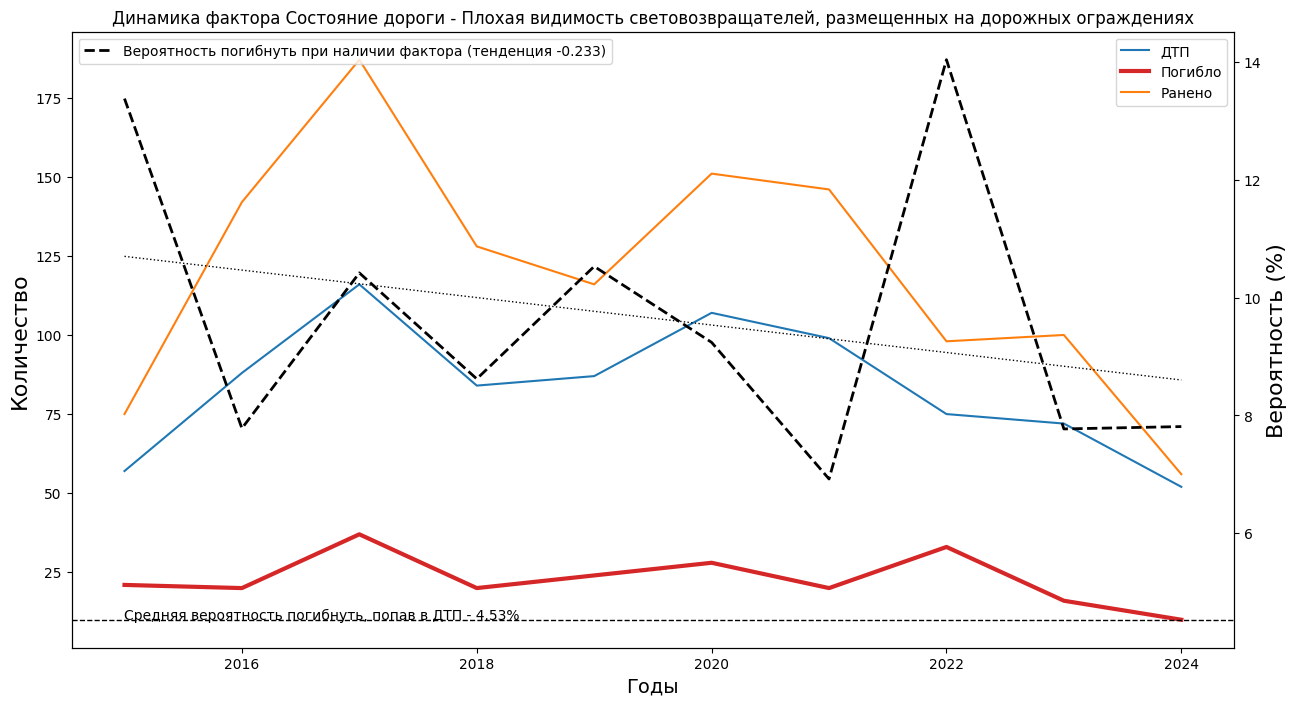

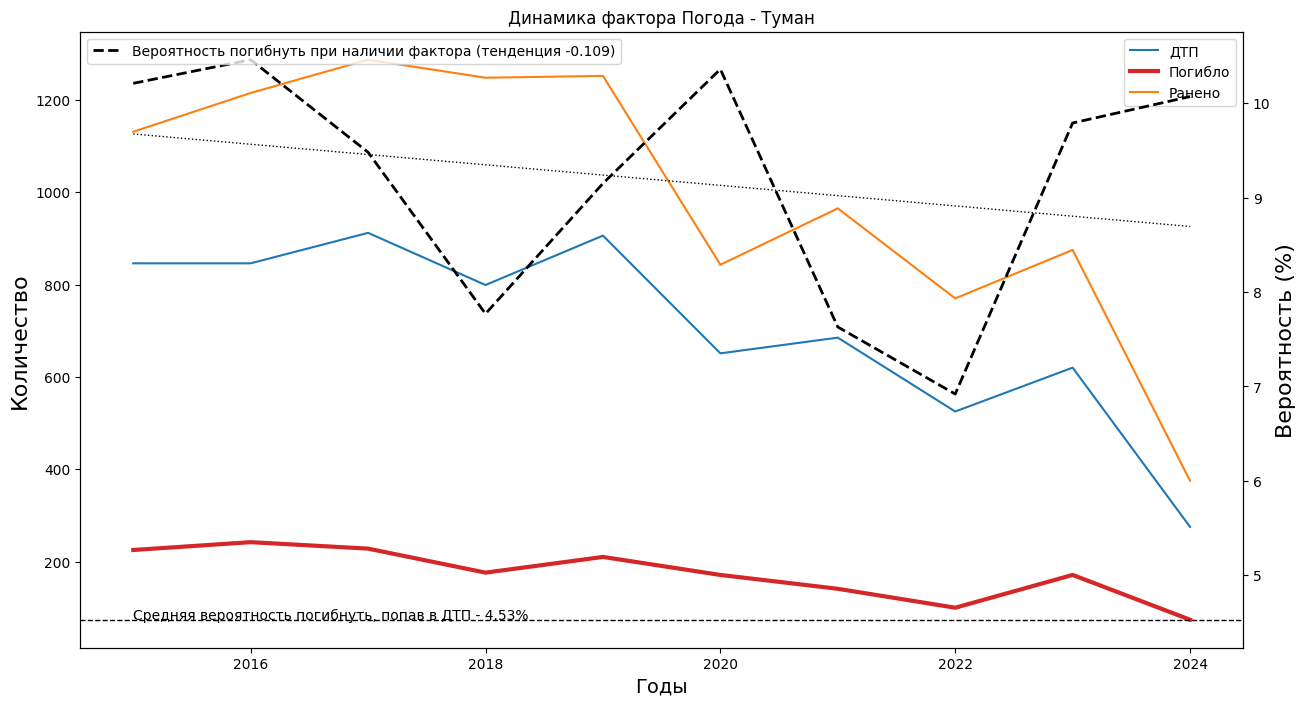

In [123]:
for i in range(0, len(top_dead_factors)):
    if (top_dead_factors.loc[i, 'zkrit_dead'] < 0.05) & (top_dead_factors.loc[i, 'dead_count'] > 100):
        col = top_dead_factors.loc[i, 'type']
        fact = top_dead_factors.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data.query( q_str).groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})

        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break


## *Транспортные средства, участвовавшие в ДТП, как фактор повышенной вероятности смертельных ДТП*

Аналогичным методом оценим траспортные средства как фактор повышенной вероятности погибнуть, попав в ДТП

### ТОП марок и категорий ТС, попавших в ДТП, по вероятности смертельного ДТП

**Сначала оценим сам факт попадания того или иного ТС в ДТП для всех участников ДТП. Далее будет оценка ТС для водителей и пассажиров внитри**

In [124]:
group_car_cat = ('Легковые', 'Автобусы', 'грузовые', 'спецтехн')

In [125]:
%%time
cars_all = cars_factors('brand', 100)
#cars_all = pd.concat([cars_all, cars_factors('model')])
cars_all = pd.concat([cars_all, cars_factors('category')])
cars_all = cars_all[cars_all['dtp_count'] > 100]
cars_all = cars_all.reset_index(drop = True)

Фактор brand уникальных значений 168
Выполнено - 100.0 %-------------
Фактор category уникальных значений 99
Выполнено - 100.0 %-------------
CPU times: user 5min 58s, sys: 3.11 s, total: 6min 1s
Wall time: 6min 7s


In [126]:
cars_all['dtp_per'] = round(100 * cars_all['dtp_count'] / all_dtp_count, 2)
cars_all['injured_per'] = round(100 * cars_all['injured_count'] / all_injured_count, 2)
cars_all['dead_per'] = round(100 * cars_all['dead_count'] / all_dead_count, 2)
cars_all['dead_p'] = round(100 *cars_all['dead_count'] / cars_all['participants_count'], 2)
cars_all['injured_p'] = round(100 *cars_all['injured_count'] / cars_all['participants_count'], 2)

In [127]:
zkrit_to_all(cars_all)

Выполнено - 100.0 %


Рассматриваются все ТС, участвовавшие в ДТП, как бы в сумме для всех участников ДТП

In [128]:
top_dead_cars = cars_all[(cars_all['dtp_count'] > 100) & (cars_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_cars[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

В ТОПе фуры, грузовики, поезда, сельхозтехника. Логично: при ДТП с большой и тяжелой "дурой" увеличивает вероятность погибнуть в такой аварии. Как показано выше: в 3-4 раза.

Динамика фактора ТС по доли погибших в ДТП по годам

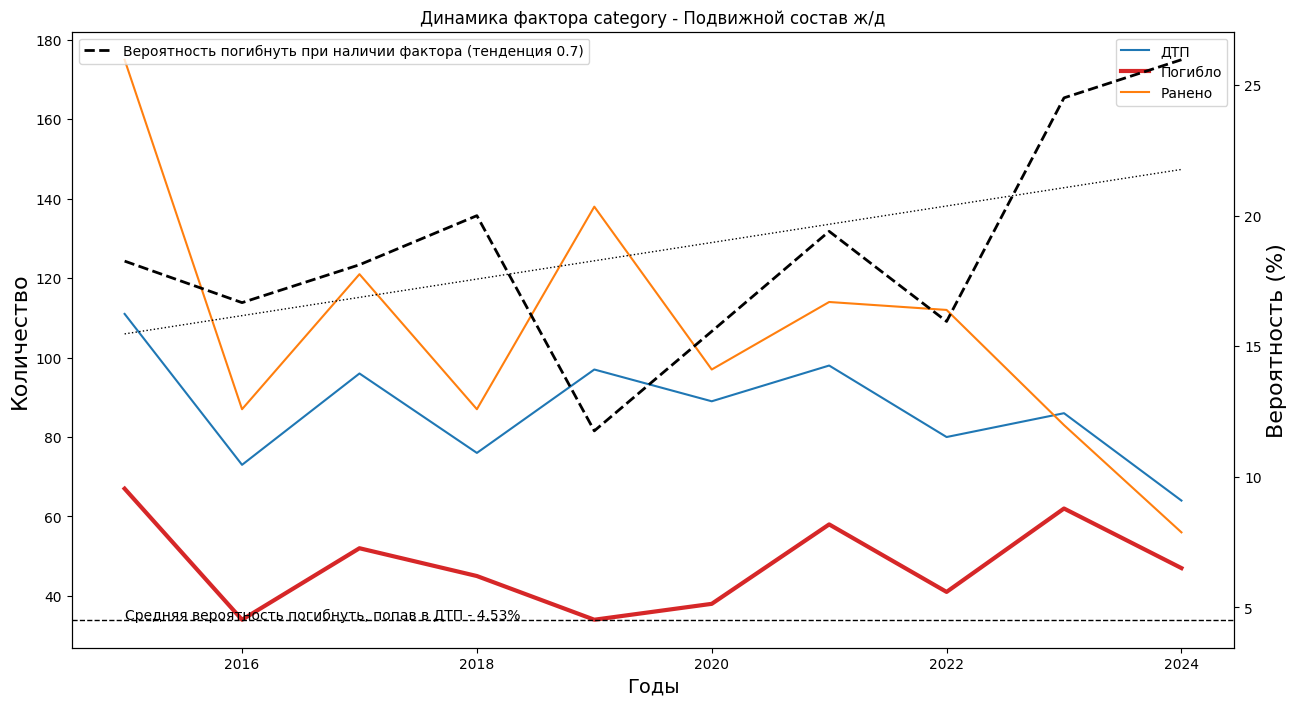

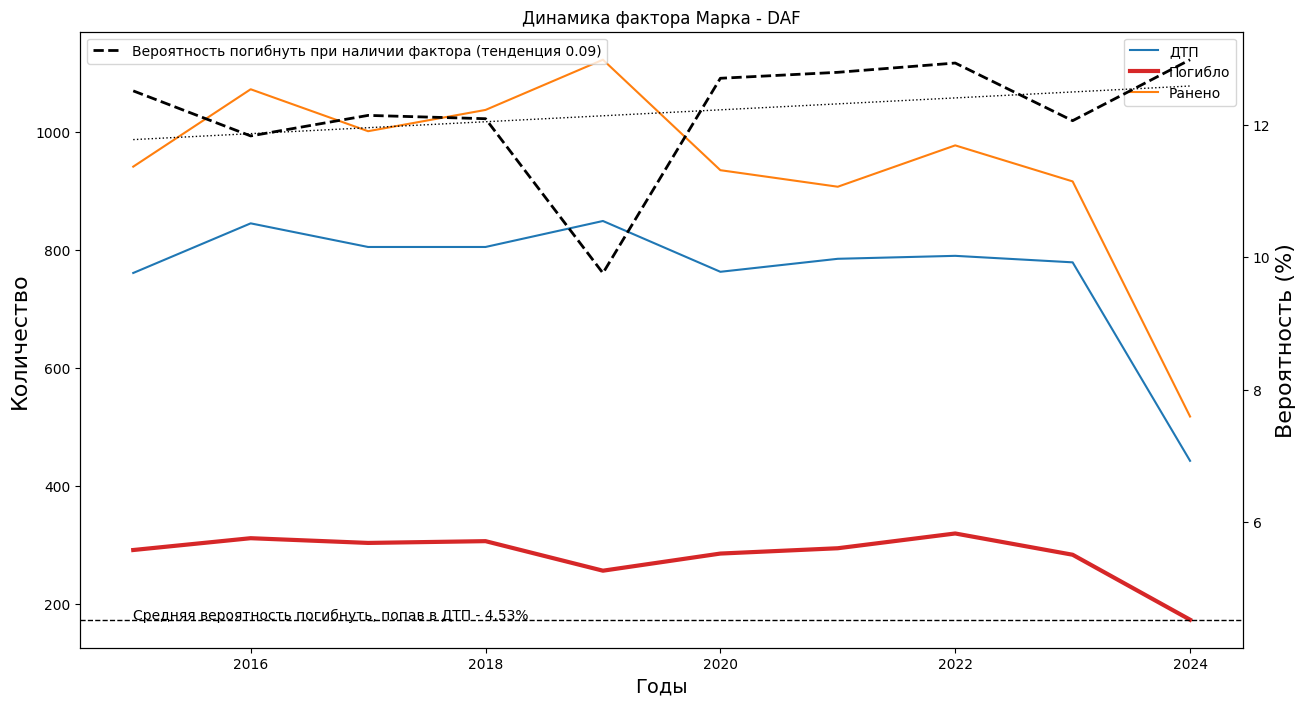

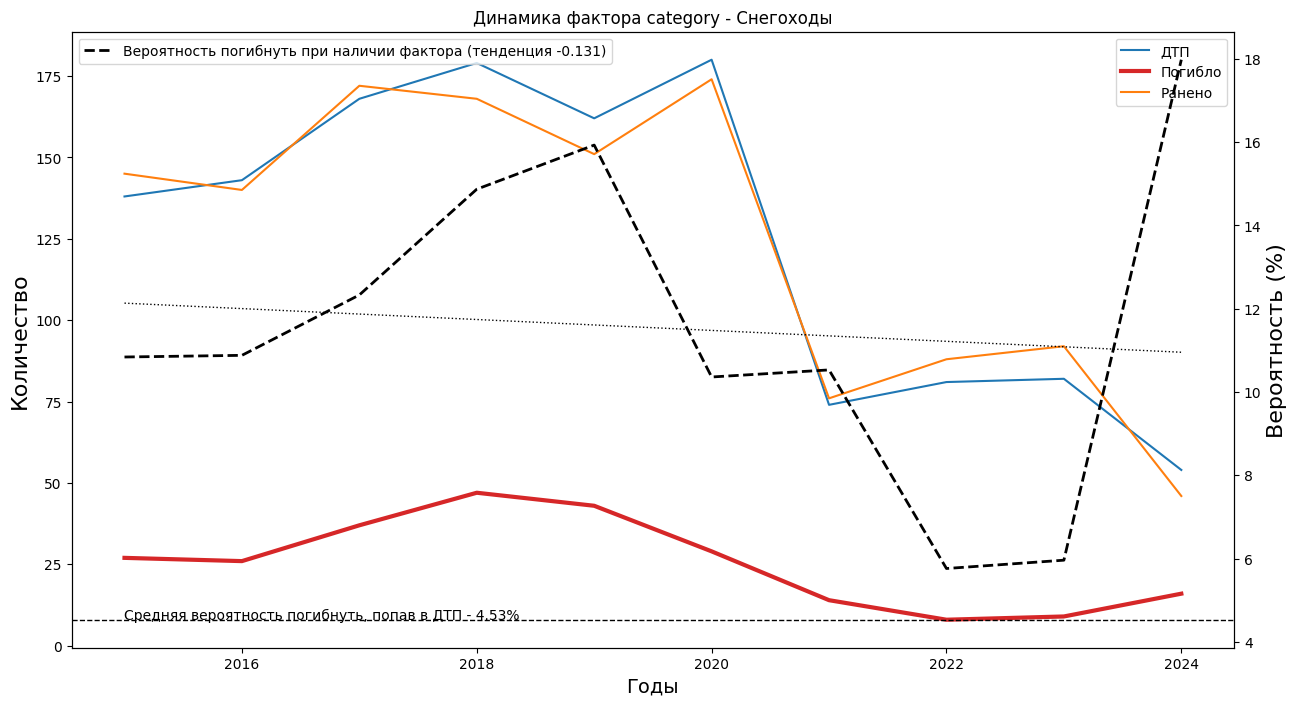

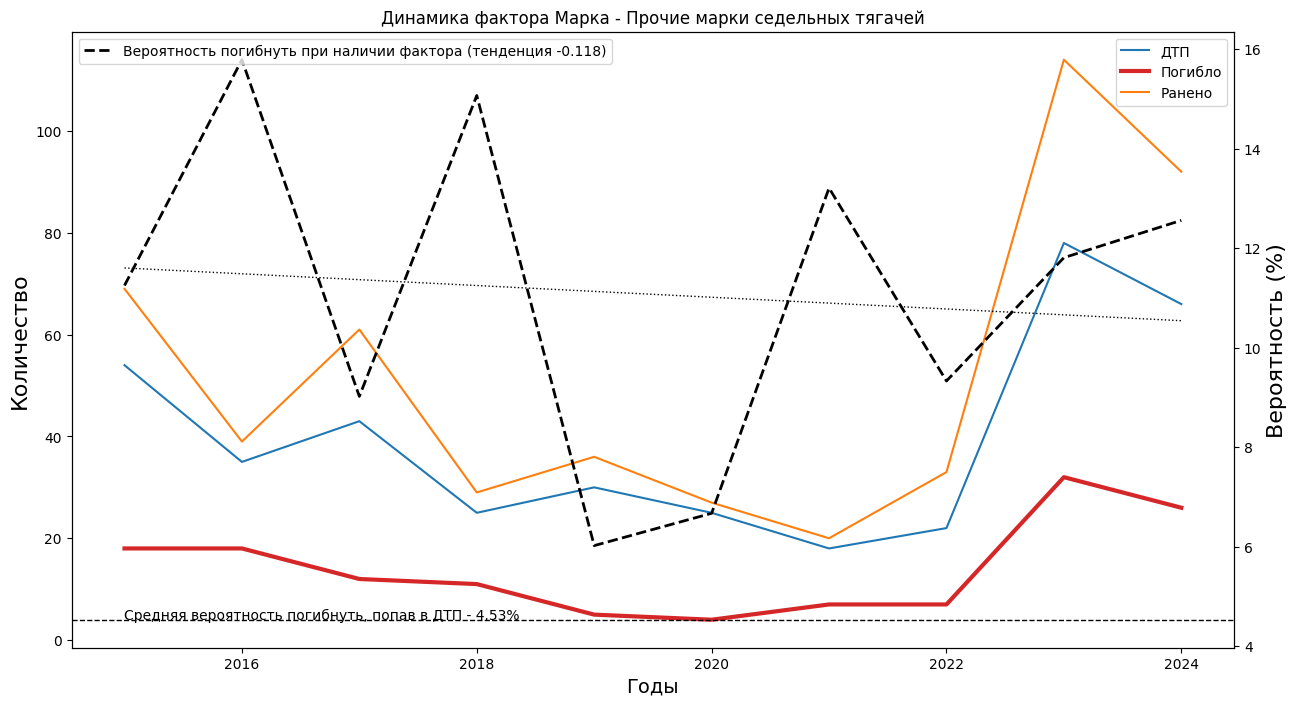

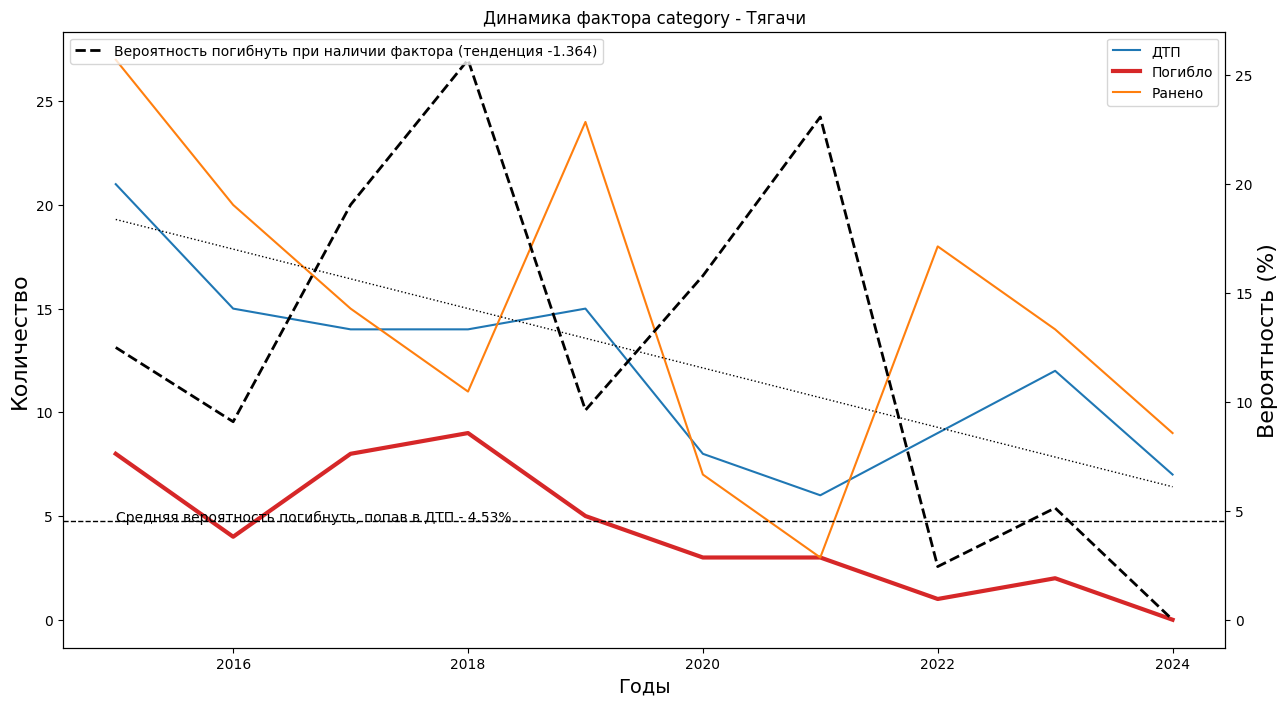

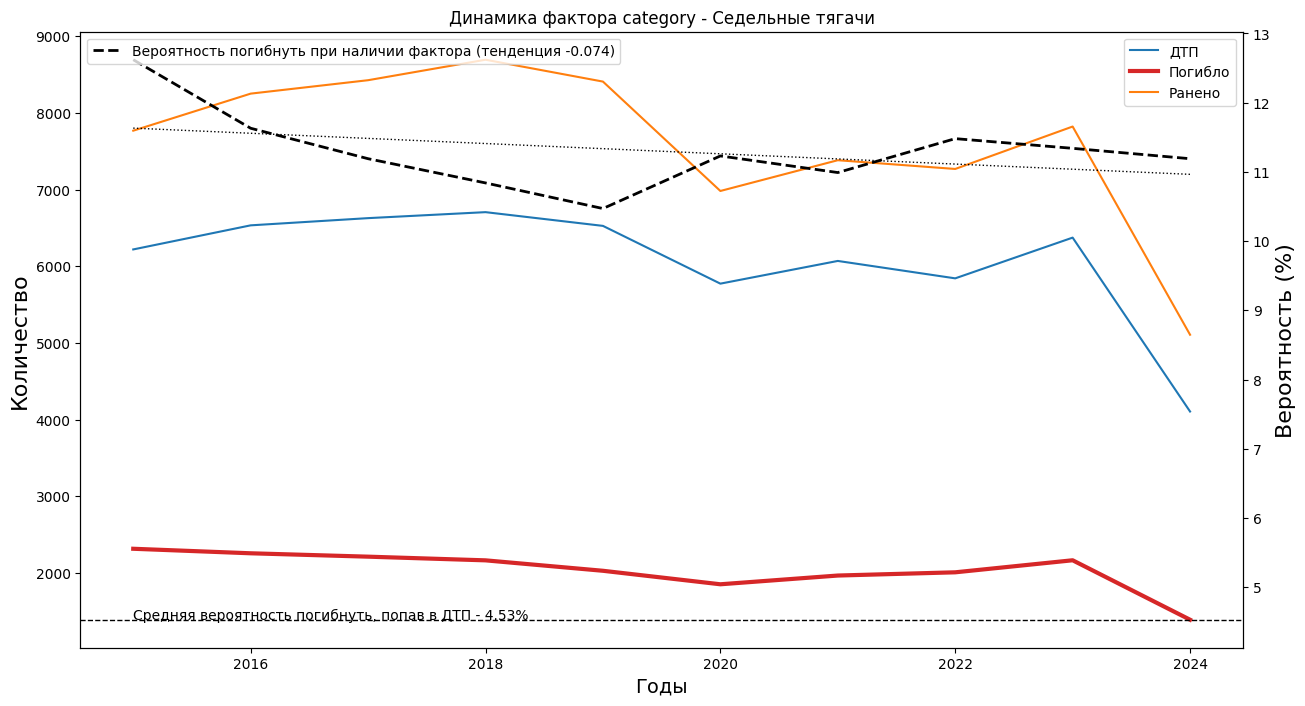

In [129]:
for i in range(0, len(top_dead_cars)):
    if (top_dead_cars.loc[i, 'zkrit_dead'] < 0.05) & (top_dead_cars.loc[i, 'dead_count'] > 100):
        col = top_dead_cars.loc[i, 'type']
        fact = top_dead_cars.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data[data['dtp_id'].isin(cars.query(q_str)['dtp_id'])].groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})
        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break


**Далее будут оценки ТС для водителей и пассажиров внитри. Своеобразный показатель небезопасности ТС категория, марок и моделей**

### Категории ТС, для водителей и пассажиров которых вероятность погибнуть, попав в ДТП - выше среднего

In [130]:
dead_cat = cars.groupby('category', as_index = False).agg({'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)
dead_cat = dead_cat[dead_cat['dtp_id'] > 100].head(75)
dead_cat = dead_cat.reset_index(drop=True)

In [131]:
group_car_cat = ('Легковые', 'Автобусы', 'грузовые', 'спецтехн')
dead_cat.reset_index(drop = True)
for gr in group_car_cat:
    gg = cars.query('category.str.contains(@gr)').agg({'car_id': 'count', 'dtp_id' : 'nunique'})
    dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]

<ipython-input-131-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-131-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-131-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-131-e1da6e8c7dd8>:5: FutureW

In [132]:
%%time
l = len(dead_cat)
print(f'Всего категорий ТС {l}')
for i in range(0, l):
    print('\r' + f'Выполнено - {str(round(100 * (i + 1) /l, 2))} %', end='')
    mdl = dead_cat.loc[i, 'category']

    cars_in_seg = set(cars[cars['category'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_cat.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_cat.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_cat.loc[i, 'dead_count'] = daed_in_cars_seg
print()

Всего категорий ТС 77
Выполнено - 100.0 %
CPU times: user 6min 25s, sys: 2.69 s, total: 6min 27s
Wall time: 6min 31s


In [133]:
dead_cat.columns = ['category', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
dead_cat['dead_p'] = round(100 * dead_cat['dead_count'] / dead_cat['participants_count'], 2)
dead_cat['dtp_per'] = round(100 * dead_cat['dtp_count'] / all_dtp_count, 2)
dead_cat['dead_per'] = round(100 * dead_cat['dead_count'] / all_dead_count, 2)
dead_cat['injured_per'] = round(100 * dead_cat['injured_count'] / all_injured_count, 2)

In [134]:
zkrit_to_all(dead_cat)

Выполнено - 100.0 %


In [135]:
top_dead_cat = dead_cat[(dead_cat['dtp_count'] > 100) & (dead_cat['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending = False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_cat[['category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

В ТОПе небезопасности категорий ТС для их владельцев напротив - "малыши". Мотоциклы, квадроциклы, снегоходы, велосипеды и автомобили микролитражки

### Марки ТС, для водителей и пассажиров которых вероятность погибнуть, попав в ДТП - выше среднего

In [136]:
dead_brand = cars.groupby('brand', as_index = False).agg({'category' : 'first', 'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)
dead_brand = dead_brand[dead_brand['dtp_id'] > 100].head(75)
dead_brand = dead_brand.reset_index(drop=True)

In [137]:
%%time
l = len(dead_brand)
print(f'Всего марок ТС {l}')
for i in range(0, l):
    print('\r' + f'Выполнено - {str(round(100*(i+1)/l, 2))} %', end='')
    mdl = dead_brand.loc[i, 'brand']

    cars_in_seg = set(cars[cars['brand'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_brand.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_brand.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_brand.loc[i, 'dead_count'] = daed_in_cars_seg
print()

Всего марок ТС 75
Выполнено - 100.0 %
CPU times: user 6min 3s, sys: 1.98 s, total: 6min 5s
Wall time: 6min 7s


In [138]:
dead_brand.columns = ['brand','category', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
dead_brand['dead_p'] = round(100 * dead_brand['dead_count'] / dead_brand['participants_count'], 2)
dead_brand['dtp_per'] = round( 100 * dead_brand['dtp_count'] / all_dtp_count, 2)
dead_brand['dead_per'] = round( 100 * dead_brand['dead_count'] / all_dead_count, 2)
dead_brand['injured_per'] = round( 100 * dead_brand['injured_count'] / all_injured_count, 2)

In [139]:
zkrit_to_all(dead_brand)

Выполнено - 100.0 %


In [140]:
top_dead_brand = dead_brand[(dead_brand['dtp_count'] > 100) & (dead_brand['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending = False).head(50)

top_dead_brand= top_dead_brand.reset_index()

factor_dead_table(top_dead_brand[['brand', 'category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])


Оценка вероятности погибнуть, попав в ДТП, по маркам ТС показывает тоже самое - мотоциклы никак не защищают своих наездников.

### Модели  ТС, для водителей и пассажиров которых вероятность погибнуть, попав в ДТП - выше среднего

In [141]:
dead_model = cars.groupby('model', as_index = False).agg({'category' : 'first', 'brand' : 'first', 'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)
# берем первые 100 моделей с наибольшим количествов ДТП в датсете,
# либо которые попали более чем в 100 ДТП
dead_model = dead_model[dead_model['dtp_id'] > 100].head(100)
dead_model = dead_model.reset_index(drop=True)

In [142]:
%%time
l = len(dead_model)
print(f'Всего моделей ТС {l}')
for i in range(0, l):
    print('\r' + f'Выполнено - {str(round(100 * (i + 1) / l, 2))} %', end='')
    mdl = dead_model.loc[i, 'model']

    cars_in_seg = set(cars[cars['model'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_model.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_model.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_model.loc[i, 'dead_count'] = daed_in_cars_seg
print()

Всего моделей ТС 100
Выполнено - 100.0 %
CPU times: user 7min 33s, sys: 2.09 s, total: 7min 35s
Wall time: 7min 38s


In [143]:
dead_model.columns = ['model', 'category', 'brand', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
dead_model['dead_p'] = round(100 * dead_model['dead_count'] / dead_model['participants_count'], 2)
dead_model['dtp_per'] = round(100 * dead_model['dtp_count'] / all_dtp_count, 2)
dead_model['dead_per'] = round(100 * dead_model['dead_count'] / all_dead_count, 2)
dead_model['injured_per'] = round(100 *dead_model['injured_count'] / all_injured_count, 2)

In [144]:
zkrit_to_all(dead_model)

Выполнено - 100.0 %


In [145]:
top_dead_model = dead_model[(dead_model['dtp_count'] > 100) & (dead_model['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending = False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_model[['model', 'brand', 'category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

В ТОПе небезопасности - уже устаревшие модели отечественных легковушек, в которых, очевидно, было не так хорошо реализованы системы безопасности

Расчет вероятности погибнуть, попав в ДТП, в зависимости по модели ТС подтверждает сделанные выше выводы - водители и пассажиры мотоциклов микро- и малолитражек при попадании в ДТП имеют более высокий шанс попрощаться с жизнью





## *Нарушения ПДД, роли и категории людей, попавших в ДТП, как фактор повышенной вероятности смертельного ДТП*

**Теперь аналогичным методом оценим людей участников ДТП: нарушения ПДД, роли, категории - как фактор повышенной вероятности погибнусть в ДТП**

In [146]:
group_violat = ('скорост', 'ремней', 'опьянения', 'перекрестк', 'Неожидан', 'пешеход', 'велосипед', 'неисправ')

In [147]:
%%time
partic_all = partic_factors('violations')
partic_all = pd.concat([partic_all, partic_factors('role')])
partic_all = pd.concat([partic_all, factors('participant_categories')])
partic_all = partic_all.reset_index(drop=True)

Фактор violations уникальных значений 113
Выполнено - 100.0 %-------------
Фактор role уникальных значений 4
Выполнено - 100.0 %-------------
Фактор participant_categories уникальных значений 6
Выполнено - 100.0 %-------------
CPU times: user 5min 23s, sys: 1.51 s, total: 5min 25s
Wall time: 5min 28s


In [148]:
partic_all['dtp_per'] = round(100 * partic_all['dtp_count'] / all_dtp_count, 2)
partic_all['injured_per'] = round(100 * partic_all['injured_count'] / all_injured_count, 2)
partic_all['dead_per'] = round(100 * partic_all['dead_count'] / all_dead_count, 2)
partic_all['dead_p'] = round(100 *partic_all['dead_count'] / partic_all['participants_count'], 2)
partic_all['injured_p'] = round(100 *partic_all['injured_count'] / partic_all['participants_count'], 2)

In [149]:
zkrit_to_all(partic_all)

Выполнено - 100.0 %


In [150]:
top_partic = partic_all[(partic_all['dtp_count'] > 100) & (partic_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop=True)

factor_dead_table(top_partic[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

Снова в лидерах фактор связанный с видимостью - "Отсутствие световозвращающих элементов" в 6 раз повышает вероятность погибнуть при ДТП! Также в лидерах "ремни", "пьянка", ходьба вдоль и поперек дороги

Исходы участников, для которых зафикисировано нарушение использования ремней безопасности, при ДТП

In [151]:
print('Доля ДТП в которых нарушались правила использования ремней (%)', round(100 * partic.query('(violations.str.contains("ремней"))')['dtp_id'].nunique() / all_dtp_count, 2))
print('Доля погибших в таких ДТП от всех погибших (%)', round(100 * partic.query('(violations.str.contains("ремней")) & (result == "Погиб")')['partic_id'].nunique() / all_dead_count, 2))

Доля ДТП в которых нарушались правила использования ремней (%) 3.91
Доля погибших в таких ДТП от всех погибших (%) 9.5


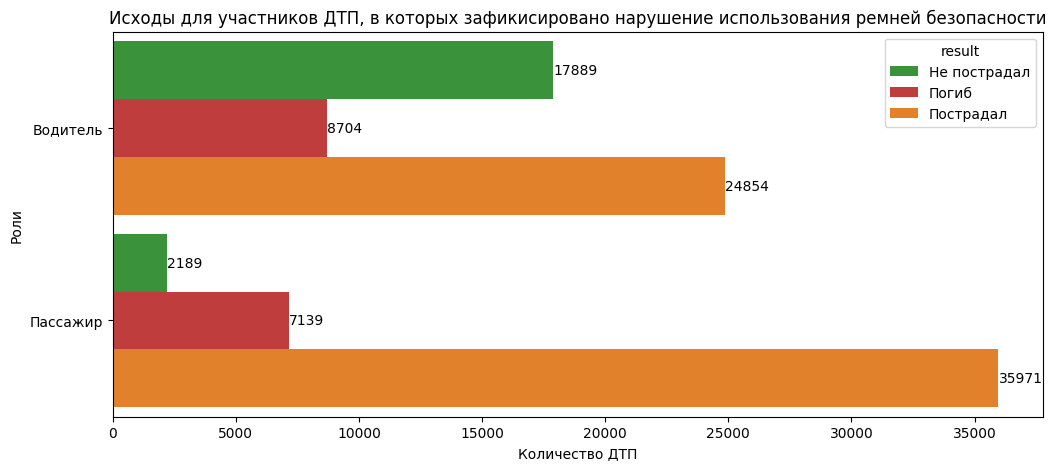

In [152]:
plt.figure(figsize=(12,5))

dd = partic.query('(violations.str.contains("ремне")) & (result != "Не заполнено")').groupby(['role', 'result'], as_index = False)['partic_id'].count()

color = ['tab:green', 'tab:red', 'tab:orange']

ax = sns.barplot(y='role', x='partic_id', hue="result", palette = color, width=0.9, data=dd)

ax.bar_label(ax.containers[0], fontsize=10, label_type='edge')
ax.bar_label(ax.containers[1], fontsize=10, label_type='edge')
ax.bar_label(ax.containers[2], fontsize=10, label_type='edge')

plt.title('Исходы для участников ДТП, в которых зафикисировано нарушение использования ремней безопасности')
plt.ylabel('Роли')
plt.xlabel('Количество ДТП')
plt.show()

Динамика основных показателей ДТП по факторам

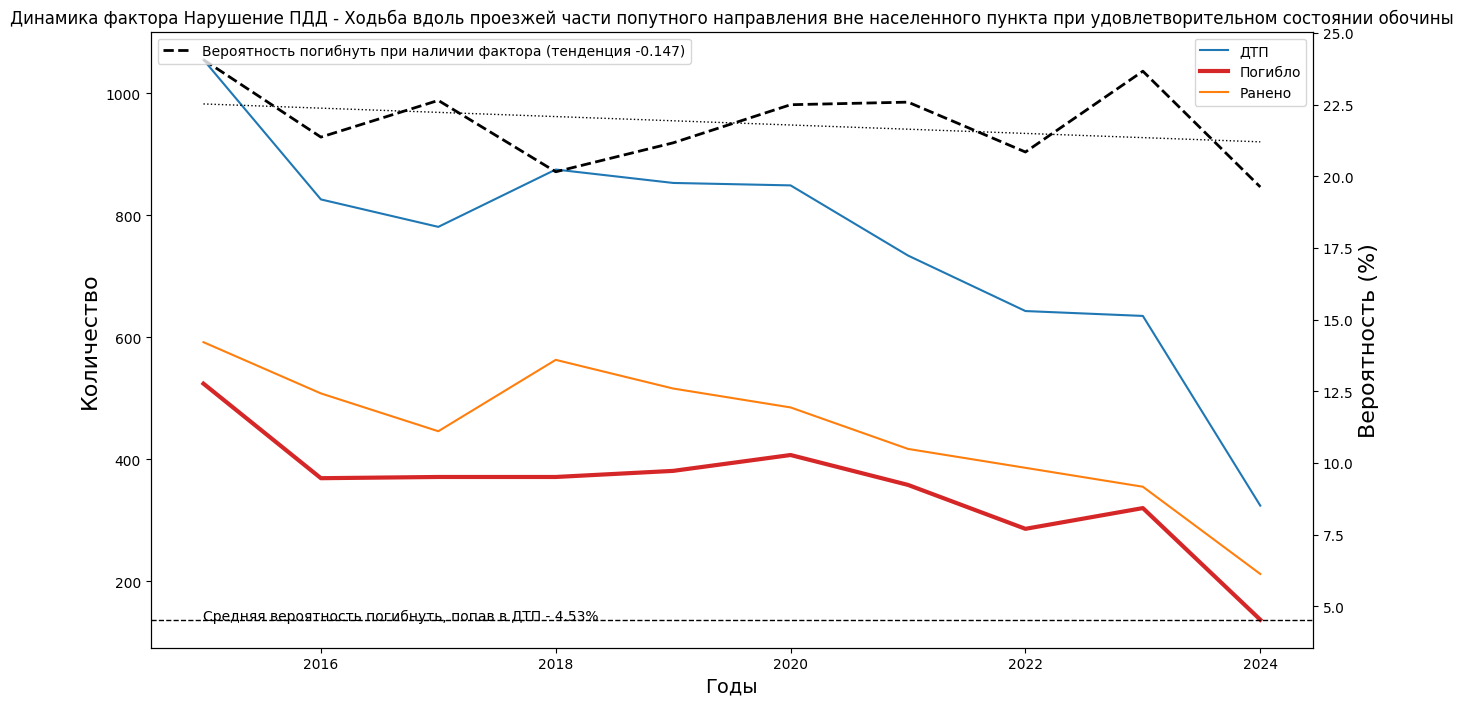

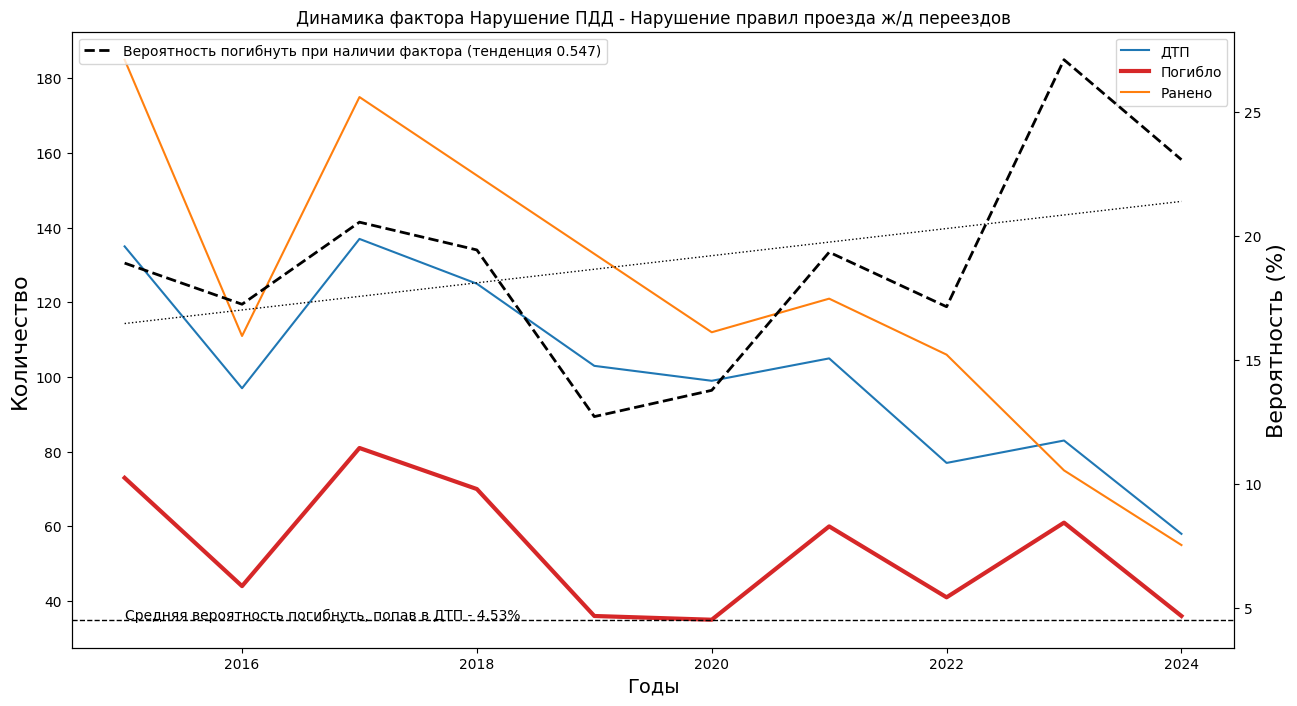

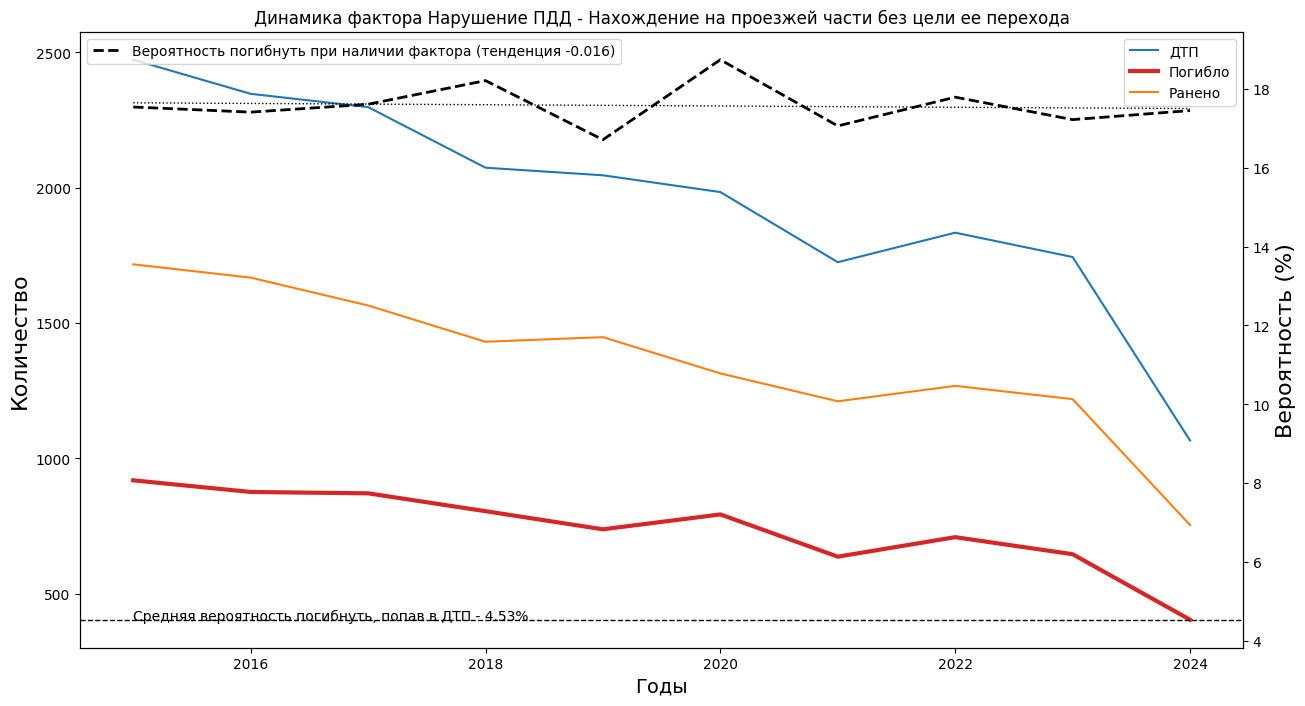

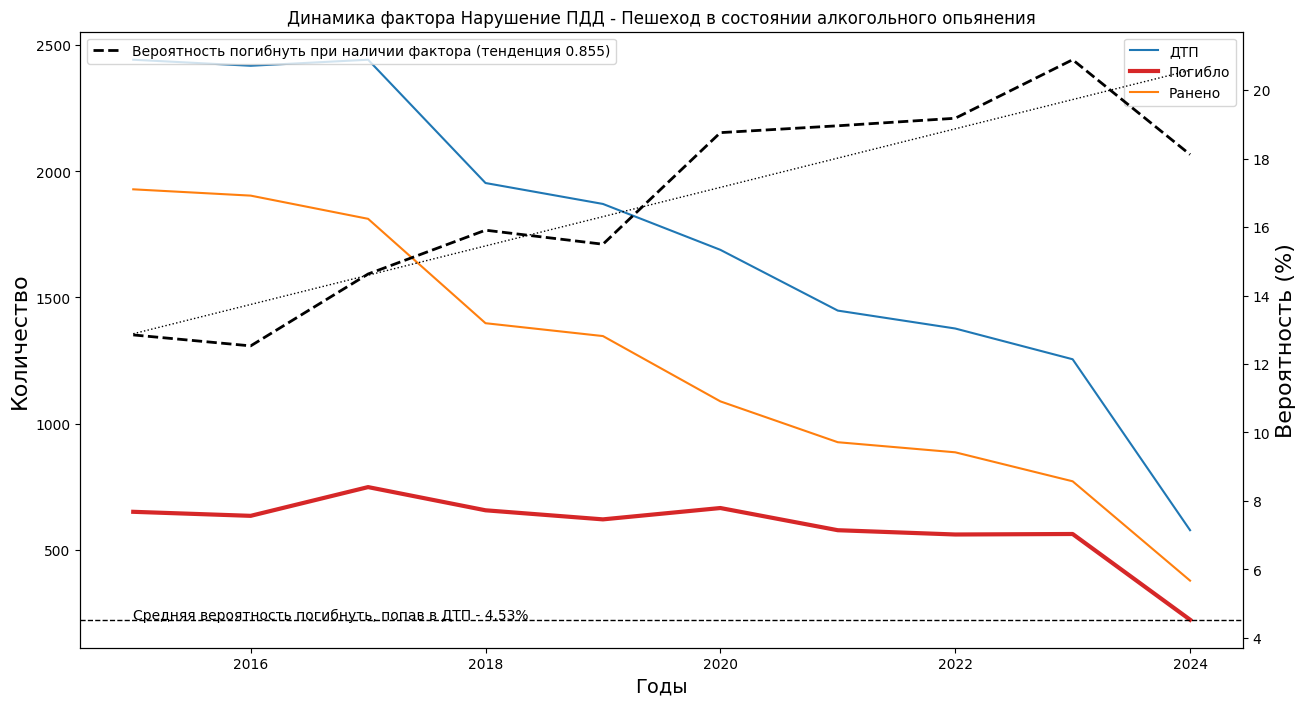

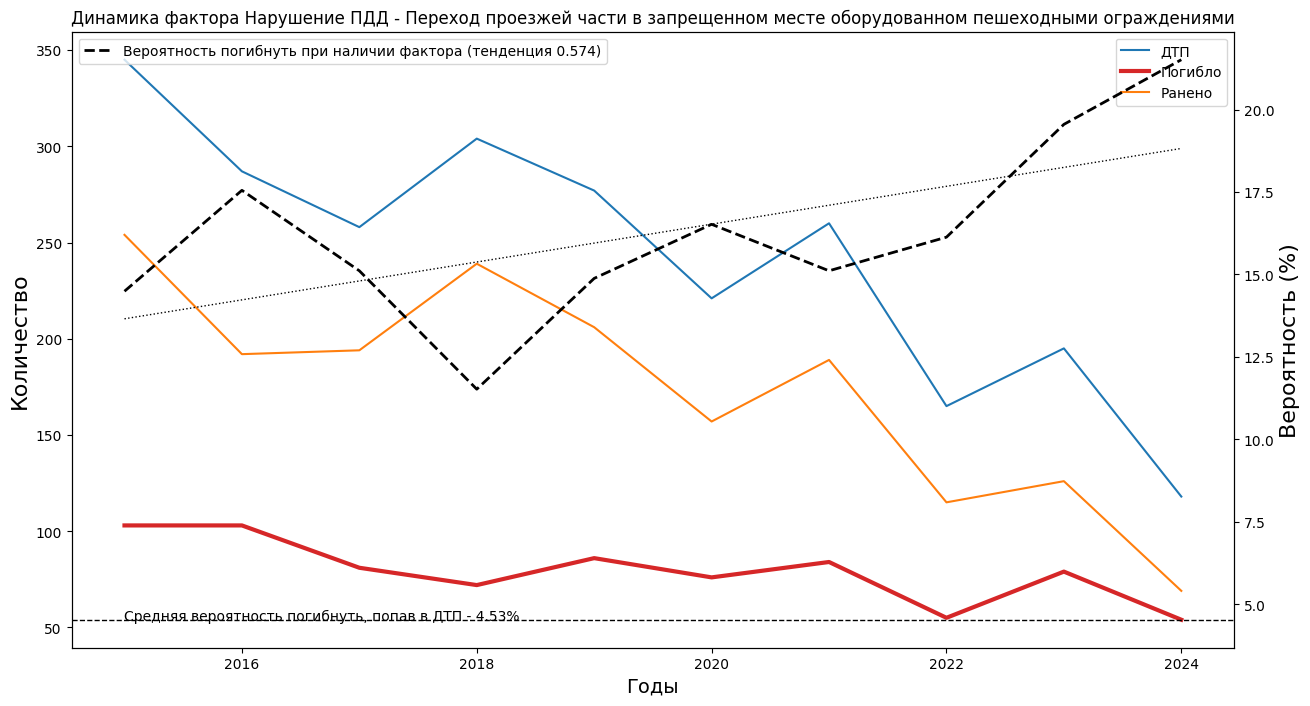

In [153]:
for i in range(0, len(top_dead_cars)):
    if (top_partic.loc[i, 'zkrit_dead'] < 0.05) & (top_partic.loc[i, 'dead_count'] > 100):
        col = top_partic.loc[i, 'type']
        fact = top_partic.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data[data['dtp_id'].isin(partic.query(q_str)['dtp_id'])].groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})
        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break

### Нарушения ПДД как фактор повышенной вероятности ДТП с пострадавшими (не смертельные)

Для сравнения, оценка вероятности получить травмы

In [154]:
partic_all[(partic_all['dtp_count'] > 100) & (partic_all['injured_p'] > injured_p)]\
        .sort_values(by='injured_p', ascending=False).head(30)\
        [['factor', 'type', 'dtp_count', 'dtp_per', 'injured_count', 'injured_per', 'injured_p', 'zkrit_injured']]\
        .style.apply(highlight_stat, subset='zkrit_injured')\
        .format({'dtp_count': '{:.0f}'.format, 'dtp_per': '{:,.2f}'.format, 'injured_count': '{:.0f}'.format, 'injured_per': '{:,.2f}'.format, 'injured_p': '{:,.2f}'.format, 'zkrit_injured': '{:.4f}'.format})

## *Промежуточные итоги*

Определили факторы повышенной вероятности погибнуть, попав в ДТП. Среди самых опасных внешних факторов - не работающее освещение, отсутсвие тротуаров,нерегулируемый жд переезд.

Наибольшая вероятность погибуть, попав в ДТП, если это стокновение с участием грузовика или фуры. Мотоциклисты, водители микролитражек и пешеходы без световозвращающих элементов - имеют повышеную веростяность погибнуть, попав в ДТП.

# **Проверка гипотез**

**В этом разделе различными статискими методами будут проверены гипотезы, которые появились в ходе исследовательнокого нализа и поиска факторов повышенной вероятности погибнуть при ДТП**

## *За рулем ПДД больше нарушают мужчины, чем женщины*

Гипотеза: водители мужчины чаще нарушают

С учетом того, что водителей-мужчин больше, для проверки гипотезы надо сравнивать долю нарушителей среди мужчин и женщщин. Это сравнение пропорций проводится z-тестом

In [155]:
men_driver = partic.query('role == "Водитель" & gender == "Мужской"')['partic_id'].count()
women_driver = partic.query('role == "Водитель" & gender == "Женский"')['partic_id'].count()

men_driver_violat = partic.query('role == "Водитель" & gender == "Мужской" & violations != "Не заполнено"')['partic_id'].count()
women_driver_violat = partic.query('role == "Водитель" & gender == "Женский" & violations != "Не заполнено"')['partic_id'].count()

In [156]:
print ('Доля нарушающих водителей женщин %', round(100 * women_driver_violat / women_driver, 2))
print ('Доля нарушающих водителей мужчин %', round(100 * men_driver_violat / men_driver, 2))

Доля нарушающих водителей женщин % 62.84
Доля нарушающих водителей мужчин % 65.5


In [157]:
pavl = z_krit(men_driver_violat, women_driver_violat, men_driver, women_driver, 'larger')

pval_print(pavl,
           h0 = 'Водители мужчины и женщины нарушают одинакого',
           h1 = 'Водители мужчины нарушают больше женщин' )

В результате теста получено p-value 0.0
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Водители мужчины нарушают больше женщин 


## *Среди пешеходов, попавших в ДТП, одинакова доля мужчин и женщин*


Гипотеза: у пешеходов гендерное разделенеи одинаково

Как было показано в исследовательном анали, доля мужчин и женщин среди пешеходов практически одинаковая, поэтому для проверки этой гипоты можем принять методы сравнения выборок

In [158]:
mendtp = partic.query('role == "Пешеход" & gender == "Мужской"')['dtp_id']
womendtp = partic.query('role == "Пешеход" & gender == "Женский"')['dtp_id']

In [159]:
mendtp_dtp_by_month = data[data['dtp_id'].isin(mendtp)].groupby(['year','month']).agg({'dtp_id': 'count'})
womendtp_dtp_by_month = data[data['dtp_id'].isin(womendtp)].groupby(['year','month']).agg({'dtp_id': 'count'})

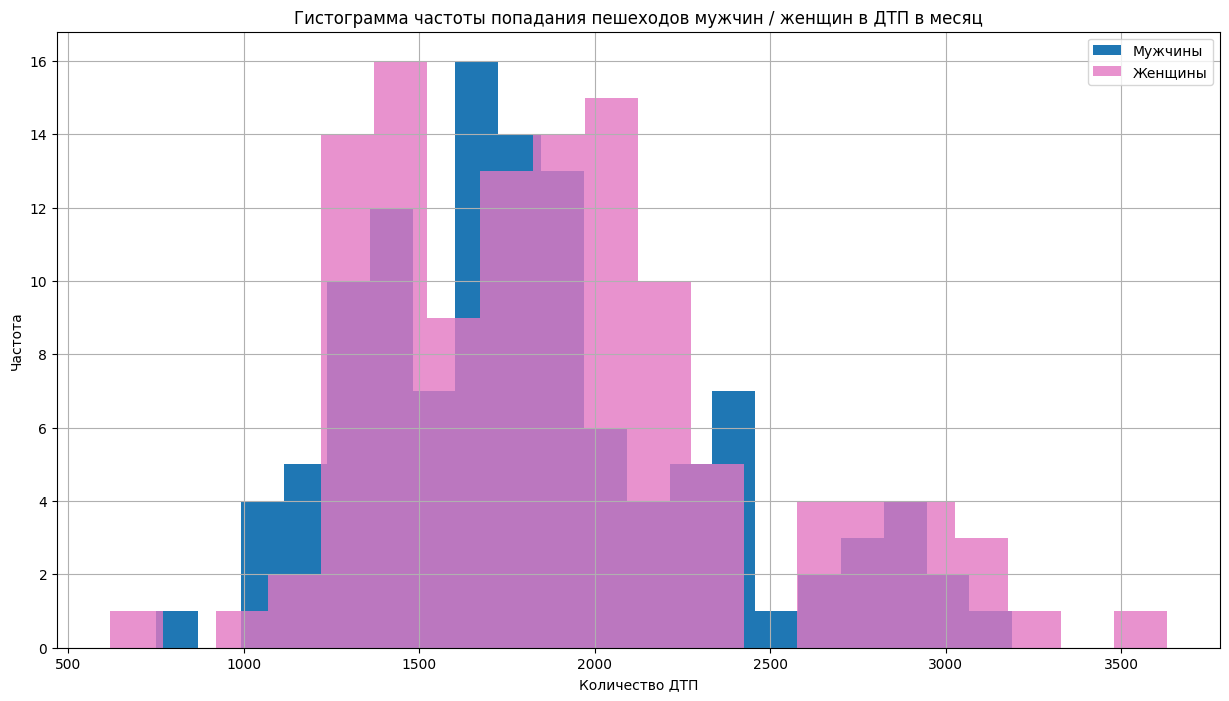

In [160]:
plt.figure(figsize=(15,8))

mendtp_dtp_by_month['dtp_id'].hist(bins = 20, color = 'tab:blue', label = 'Мужчины')
womendtp_dtp_by_month['dtp_id'].hist(bins = 20, alpha = 0.8, color = 'tab:pink', label = 'Женщины')
plt.title('Гистограмма частоты попадания пешеходов мужчин / женщин в ДТП в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()

In [161]:
test_selection(
    womendtp_dtp_by_month['dtp_id'], mendtp_dtp_by_month['dtp_id'],
    side='greater',
    h0 = 'Гендерное разделение пешеходов, попавших в ДТП - одинаково',
    h1 = 'Среди пешеходов, попавших в ДТП, больше женщин')

Первая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.0036704232269941105
Вторая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.027279831703056902
Дисперсии выборок близки. pval = 0.4018908142230224. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.1293563374985488
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Гендерное разделение пешеходов, попавших в ДТП - одинаково 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.12543914264368333
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Гендерное разделение пешеходов, попавших в ДТП - одинаково 


Итоги тестов на разных выборках могут отличатся. Но учитывая ненормальность распределения, больше доверия тесту Манна-Уитни

In [162]:
mendtp = None
womendtp = None

Интересно теперь посмотреть, кто нарушает больше среди пешеходов

In [163]:
men_wallker = partic.query('role == "Пешеход" & gender == "Мужской"')['partic_id'].count()
women_wallker = partic.query('role == "Пешеход" & gender == "Женский"')['partic_id'].count()

men_wallker_violat = partic.query('role == "Пешеход" & gender == "Мужской" & violations != "Не заполнено"')['partic_id'].count()
women_wallker_violat = partic.query('role == "Пешеход" & gender == "Женский" & violations != "Не заполнено"')['partic_id'].count()

In [164]:
print ('Доля нарушающих пешехожов женщин %', round(100 * women_wallker_violat / women_wallker, 2))
print ('Доля нарушающих пешеходов мужчин %', round(100 * men_wallker_violat / men_wallker, 2))

Доля нарушающих пешехожов женщин % 28.61
Доля нарушающих пешеходов мужчин % 49.23


In [165]:
pavl = z_krit(men_wallker_violat, women_wallker_violat, men_wallker, women_wallker, 'larger')

pval_print(pavl,
           h0 = 'Пешеходы мужчины и женщины нарушают одинакого',
           h1 = 'Пешеходы мужчины нарушают больше женщин' )

В результате теста получено p-value 0.0
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Пешеходы мужчины нарушают больше женщин 


Инетерсно, среди пешеходов нарушают больше мужчины, при этом в ДТП пешеходы мужчины и женщины попадают одинаково

## *В ДТП с пешеходами кто чаще нарушает - водители или пешеходы?*

В ДТП с пешеходами чаще виноваты пешеходы

In [166]:
walker_dtp = partic.query('role == "Пешеход"')['dtp_id']

print('Всего ДТП с пешеходами', len(walker_dtp))
print('Количество водителей, у которых НЕТ нарушений', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations == "Не заполнено"')))
print('Количество водитель, у которых есть нарушения', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations != "Не заполнено"')))
print('Количество пешеходов, которые НЕТ нарушений', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations == "Не заполнено"')))
print('Количество пешеходов, у которые есть нарушения', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations != "Не заполнено"')))

Всего ДТП с пешеходами 460538
Количество водителей, у которых НЕТ нарушений 111753
Количество водитель, у которых есть нарушения 331555
Количество пешеходов, которые НЕТ нарушений 282404
Количество пешеходов, у которые есть нарушения 178134


In [167]:
walker_dtp_violat_walker = set(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations != "Не заполнено"')['dtp_id'])
walker_dtp_violat_driver = set(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations != "Не заполнено"')['dtp_id'])

In [168]:
walker_dtp_violat_walker_ym = data[data['dtp_id'].isin(walker_dtp_violat_walker)].groupby(['year','month'], as_index=False).agg({'dtp_id': 'count'})
walker_dtp_violat_driver_ym = data[data['dtp_id'].isin(walker_dtp_violat_driver)].groupby(['year','month'], as_index=False).agg({'dtp_id': 'count'})

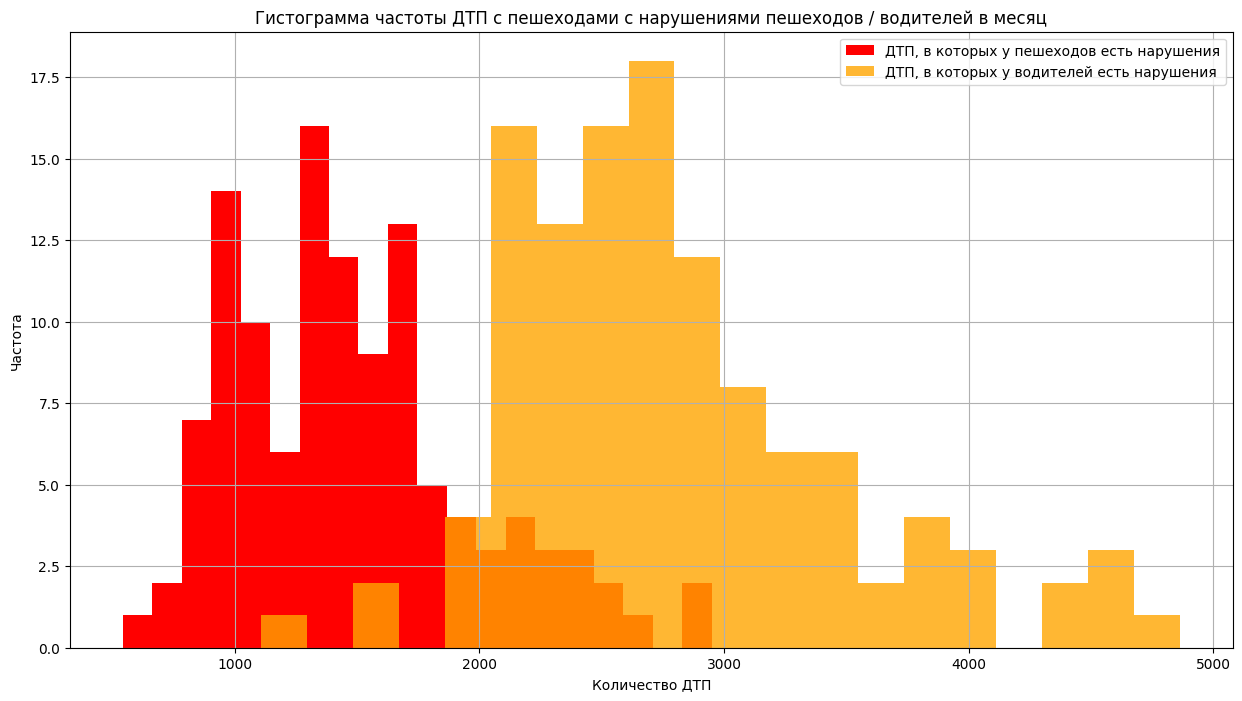

In [169]:

plt.figure(figsize=(15,8))

walker_dtp_violat_walker_ym['dtp_id'].hist(bins = 20, alpha = 1, color = 'red', label = 'ДТП, в которых у пешеходов есть нарушения')
walker_dtp_violat_driver_ym['dtp_id'].hist(bins = 20, alpha = 0.8,  color = 'orange', label = 'ДТП, в которых у водителей есть нарушения')
plt.title('Гистограмма частоты ДТП с пешеходами с нарушениями пешеходов / водителей в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()



Нулевая гипотеза, что у пешеходы и водители одинаково нарушают в ДТП с пешеходами, альтернитивная - что у водителей нарушений БОЛЬШЕ.

In [170]:
test_selection(
    walker_dtp_violat_driver_ym['dtp_id'], walker_dtp_violat_walker_ym['dtp_id'],
    side='greater',
    h0 = 'Пешеходы и водители одинаково нарушают в ДТП с пешеходами',
    h1 = 'У водителей в ДТП с пешеходами нарушений БОЛЬШЕ')

Первая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.000760033318933631
Вторая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.0034063935889028854
Дисперсии выборок НЕ близки. pval = 0.01216264940468023. Применяем equal_var=False

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 1.6451189896879106e-41
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У водителей в ДТП с пешеходами нарушений БОЛЬШЕ 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 9.145303289214868e-33
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У водителей в ДТП с пешеходами нарушений БОЛЬШЕ 


In [171]:
walker_dtp = None
walker_dtp_violat_walker = None
walker_dtp_violat_driver = None

## *Пьяных ДТП меньше, но они тяжелее по последствиям*

Гипотеза: Количество пьяных ДТП меньше, чем обычных

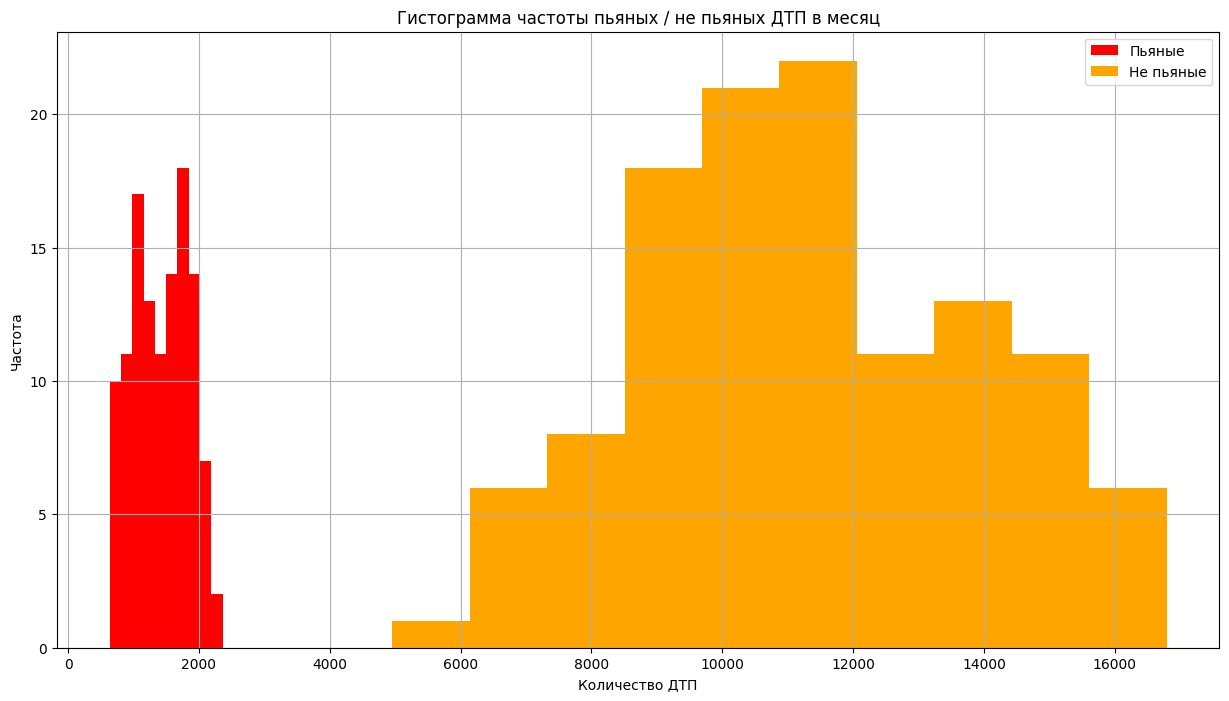

In [172]:
plt.figure(figsize=(15,8))

alco_dtp_by_month['dtp_count'].hist(bins = 10, color = 'red', label = 'Пьяные')
notalco_dtp_by_month['dtp_count'].hist(bins = 10, color = 'orange', label = 'Не пьяные')
plt.title('Гистограмма частоты пьяных / не пьяных ДТП в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()

Анализ показывает, что количество обычных ДТП больше, чем пьяных. Проверим это статистическими методами.
Проверим распределение на нормальность и равенство дисперсий


Нулевая гипотеза, что обычных и пьяных ДТП одинакого, альтернитивная - что обычных БОЛЬШЕ.

In [173]:
test_selection(
    notalco_dtp_by_month['dtp_count'], alco_dtp_by_month['dtp_count'],
    side='greater',
    h0 = 'Количество обычных и пьяных ДТП одинакого',
    h1 = 'Обычных ДТП больше, чем пьяных')

Первая выборка размером 117 прошла проверку на нормальное распределение. pval = 0.10102074799053032
Вторая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 3.905251263000044e-05
Дисперсии выборок НЕ близки. pval = 3.074182419223696e-27. Применяем equal_var=False

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 8.77778867678054e-74
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Обычных ДТП больше, чем пьяных 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 3.4322381365014663e-40
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Обычных ДТП больше, чем пьяных 


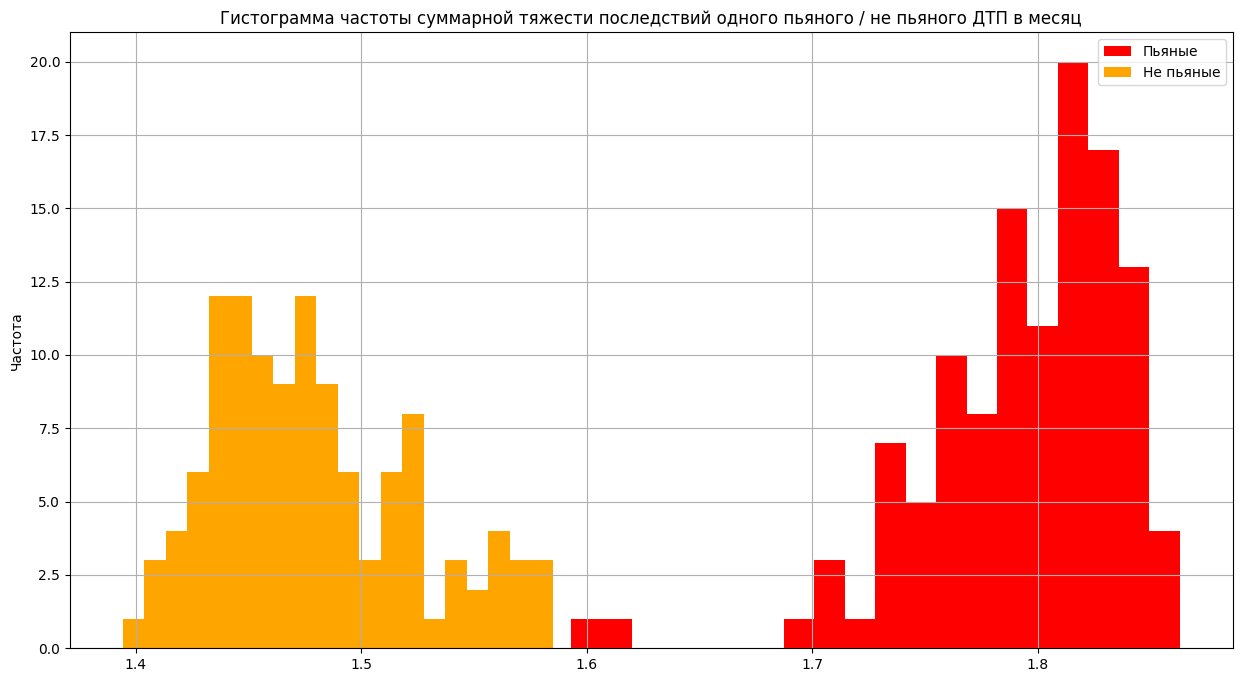

In [174]:
plt.figure(figsize=(15,8))
alco_dtp_by_month['severity_1dtp'].hist(bins = 20, color = 'red', label = 'Пьяные')
notalco_dtp_by_month['severity_1dtp'].hist(bins = 20, color = 'orange', label = 'Не пьяные')
plt.title('Гистограмма частоты суммарной тяжести последствий одного пьяного / не пьяного ДТП в месяц')
plt.ylabel('Частота')
plt.legend()
plt.show()


Нулевая гипотеза, что у обычных и пьяных ДТП тяжесть последствий одинакова, альтернитивная - что у пьяных ДТП тяжесть последствий БОЛЬШЕ.

In [175]:
test_selection(
    alco_dtp_by_month['severity_1dtp'], notalco_dtp_by_month['severity_1dtp'],
    side='greater',
    h0 = 'У обычных и пьяных ДТП тяжесть последствий одинакова',
    h1 = 'У пьяных ДТП тяжесть последствий БОЛЬШЕ')

Первая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 7.904387991346276e-11
Вторая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.031055841907498397
Дисперсии выборок близки. pval = 0.6067289444862689. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 1.87008442410488e-133
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У пьяных ДТП тяжесть последствий БОЛЬШЕ 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 3.4328030320866593e-40
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У пьяных ДТП тяжесть последствий БОЛЬШЕ 


## *При ДТП в темное время суток без освещения погибает больше, чем при работающем освещениии*

Гипотеза: В ДТП, произошедших в темное время суток и при остуствии освещения, больше погибшем, чем при наличии освещения

In [176]:
dtp_light = data.query('light.str.contains("освещение включено")').groupby(['year', 'month'])['dead_count'].sum()
dtp_nolight = data.query('light.str.contains("освещение не включено") | light.str.contains("освещение отсутствует")').groupby(['year', 'month'])['dead_count'].sum()

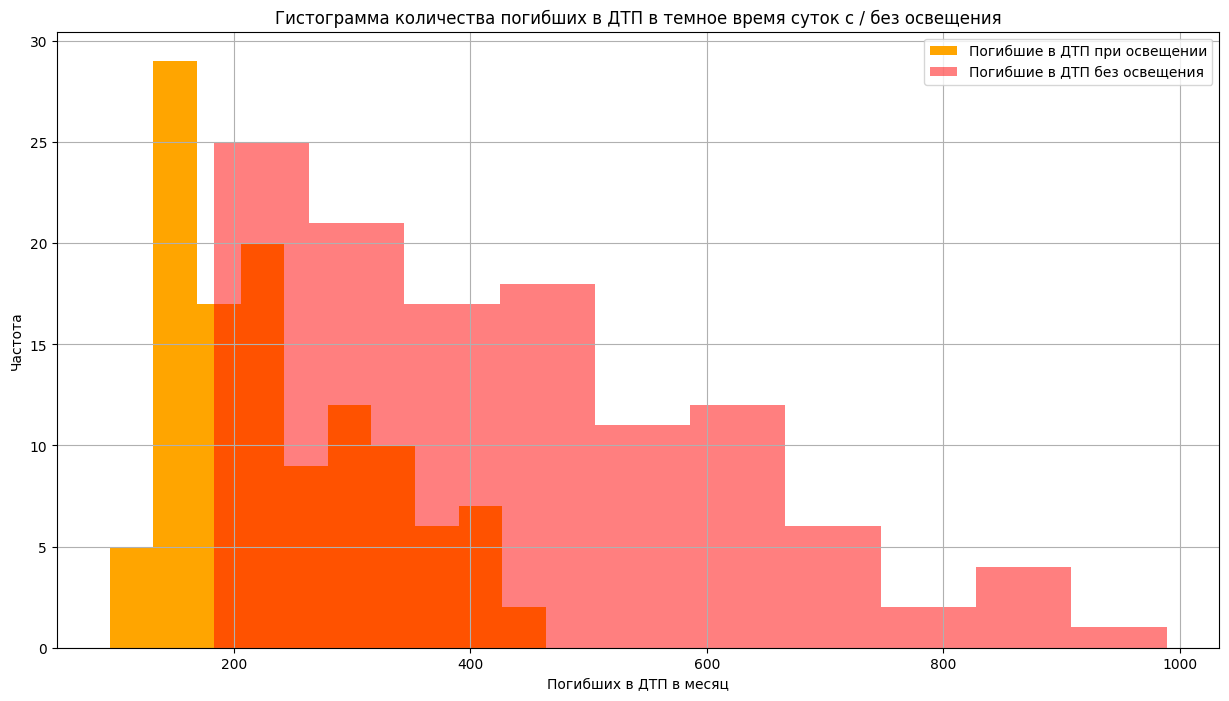

In [177]:

plt.figure(figsize=(15,8))

dtp_light.hist(bins = 10, alpha = 1, color = 'orange', label = 'Погибшие в ДТП при освещении')
dtp_nolight.hist(bins = 10, alpha = 0.5,  color = 'red', label = 'Погибшие в ДТП без освещения')
plt.title('Гистограмма количества погибших в ДТП в темное время суток с / без освещения')
plt.ylabel('Частота')
plt.xlabel('Погибших в ДТП в месяц')
plt.legend()
plt.show()


In [178]:
test_selection(
    dtp_nolight, dtp_light,
    side='greater',
    h0 = 'Количество погибших в ДТП в темное время суток при освещении и без - одинаково',
    h1 = 'Погибших в ДТП в темное время суток без освещения больше')

Первая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.005792139087084607
Вторая выборка размером 117 НЕ прошла проверку на нормальное распределение. pval = 0.007243525273516555
Дисперсии выборок НЕ близки. pval = 1.2925053415351068e-09. Применяем equal_var=False

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 4.035455751099221e-20
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Погибших в ДТП в темное время суток без освещения больше 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 1.037811159886465e-19
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Погибших в ДТП в темное время суток без освещения больше 


## *Что опаснее дождь или снегопад?*

Гипотеза: снегопад более опасный, чем дождь

В топе факторов также встречаются погодные факторы Дождь и Снегопад. Интересно, что из них опаснее? Оценим не поколичеству ДТП, а по сумме тяжести последствий, как оценивали "пьяные" ДТП. Не берем в анализ 2024 год, так как по нему доступны только данные по сентябрь

In [179]:
snow_rain_dtp = data.query('weather == "Дождь" & year < 2024').groupby(['year'], as_index = False)['severity_id'].sum()
snow_rain_dtp['snow'] = data.query('weather == "Снегопад"').groupby(['year'], as_index = False)['severity_id'].sum()['severity_id']
snow_rain_dtp = snow_rain_dtp.rename(columns={'severity_id':'rain'})

<Figure size 1200x800 with 0 Axes>

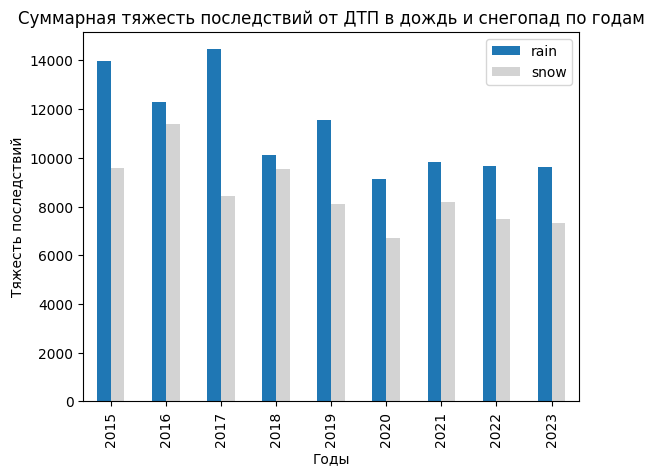

In [180]:
plt.figure(figsize=(12,8))
snow_rain_dtp.set_index('year')[['rain', 'snow']].plot.bar(color = ['tab:blue', 'lightgrey'])
plt.title('Суммарная тяжесть последствий от ДТП в дождь и снегопад по годам')
plt.ylabel('Тяжесть последствий')
plt.xlabel('Годы')
plt.show()

In [181]:
test_selection(
    snow_rain_dtp['snow'], snow_rain_dtp['rain'],
    side='greater',
    h0 = 'Дождь и снегопад одинаково опасны по тяжести последствий',
    h1 = 'В снегопад ДТП происходят более тяжкие ДТП')

Первая выборка размером 9 прошла проверку на нормальное распределение. pval = 0.3710037958113032
Вторая выборка размером 9 прошла проверку на нормальное распределение. pval = 0.42964314193243236
Дисперсии выборок близки. pval = 0.4191592496491161. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!

--- Проводим TTest ---
В результате теста получено p-value 0.9974155450350792
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.9986601427915892
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


Выборки маловаты для ttestа и Mann-Whitneyu, увеличим выборку за счет разбивки на области

In [182]:
snow_rain_dtp_big = data.query('weather == "Дождь" & year < 2024').groupby(['year', 'parent_region'], as_index = False)['severity_id'].sum()
snow_rain_dtp_big['snow'] = data.query('weather == "Снегопад" & year < 2024').groupby(['year', 'parent_region'], as_index = False)['severity_id'].sum()['severity_id']
snow_rain_dtp_big = snow_rain_dtp_big.rename(columns={'severity_id':'rain'})

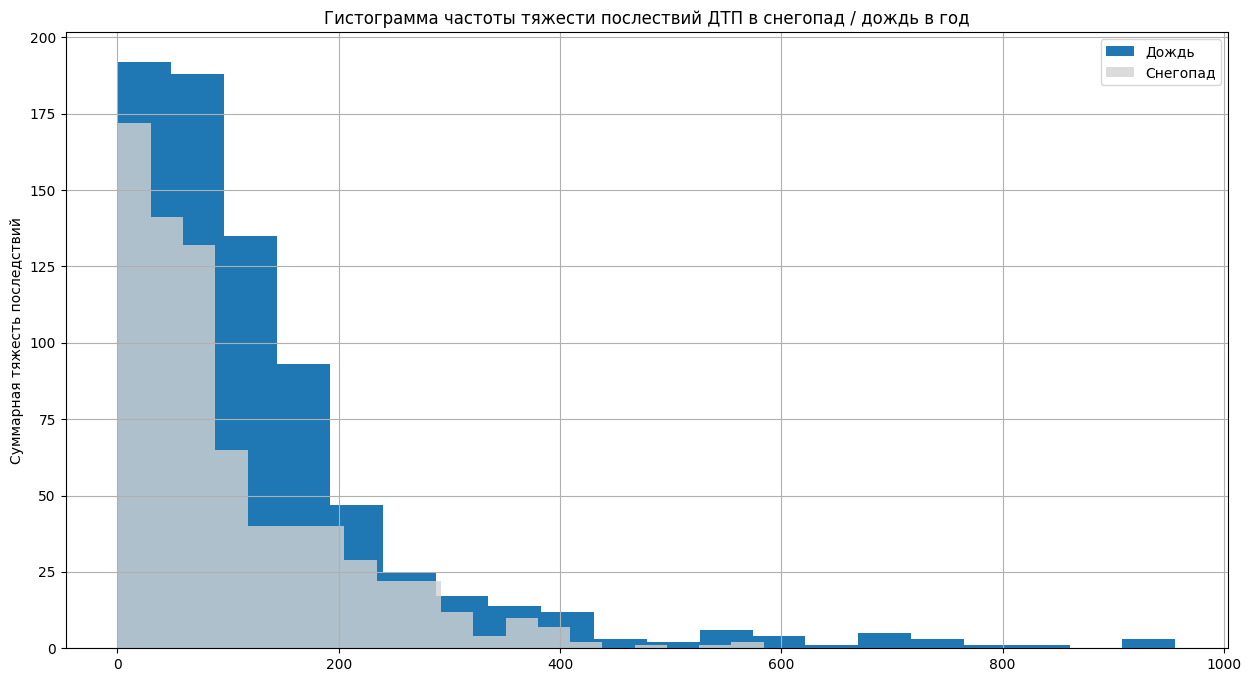

In [183]:
plt.figure(figsize=(15,8))
snow_rain_dtp_big['rain'].hist(bins = 20, color = 'tab:blue', label = 'Дождь')
snow_rain_dtp_big['snow'].hist(bins = 20, alpha = 0.8, color = 'lightgrey', label = 'Снегопад')
plt.title('Гистограмма частоты тяжести послествий ДТП в снегопад / дождь в год')
plt.ylabel('Частота')
plt.ylabel('Суммарная тяжесть последствий')
plt.legend()
plt.show()

In [184]:
test_selection(
    snow_rain_dtp_big['snow'], snow_rain_dtp_big['rain'],
    side='greater',
    h0 = 'Дождь и снегопад одинаково опасны по тяжести последствий',
    h1 = 'В снегопад ДТП происходит более тяжкие ДТП')

Первая выборка размером 752 прошла проверку на нормальное распределение. pval = nan
Вторая выборка размером 752 НЕ прошла проверку на нормальное распределение. pval = 8.679141856854088e-98
Дисперсии выборок близки. pval = nan. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value nan
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value nan
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 


## *С каким стажем водители чаще попападют в ДТП*

Гипотеза: На 2-3 годы вождения водители попадают в ДТП реже

Для анализа возьмем 1-10 года водительского стажа

In [185]:
stag_dtp_by_month = []
for y in range(1, 11):
    d = partic.query('(role == "Водитель") & (years_of_driving_experience == @y)')['dtp_id'].unique()
    stag_dtp_by_month.append(data[data['dtp_id'].isin(d)].groupby(['year','month'])['dtp_id'].count())

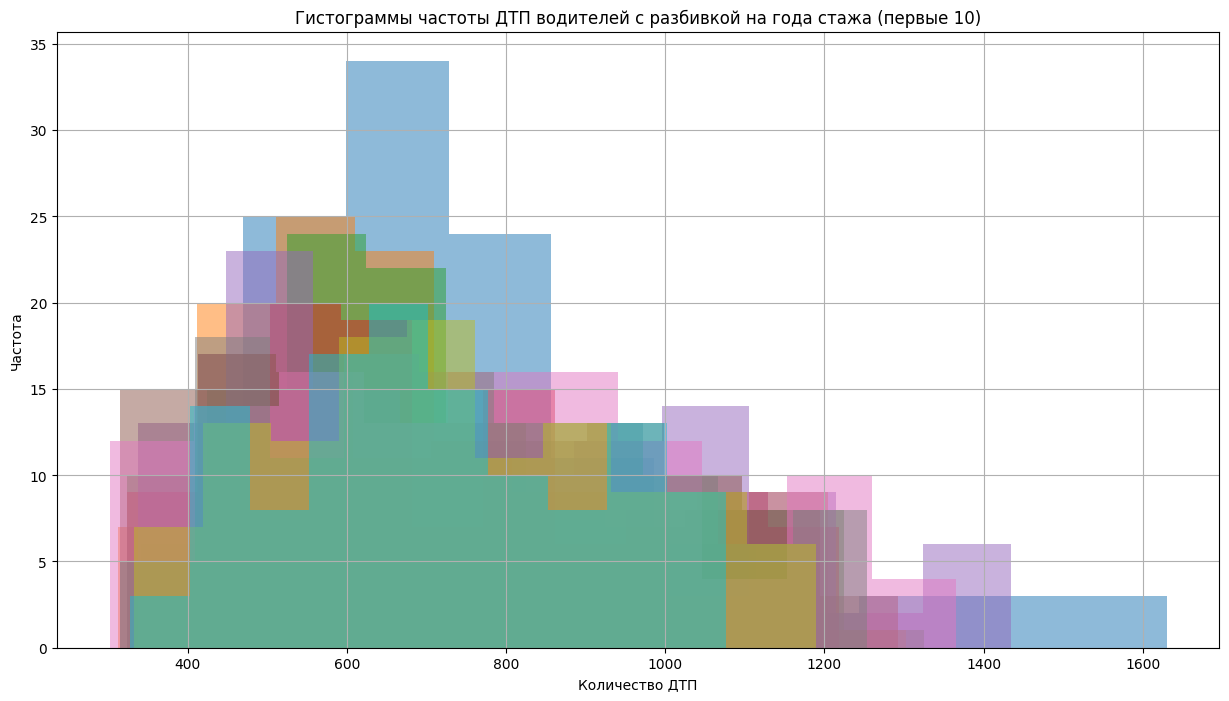

In [186]:
plt.figure(figsize=(15,8))
for y in range(0, 10):
    stag_dtp_by_month[y].hist(bins=10, alpha = 0.5)
plt.title('Гистограммы частоты ДТП водителей с разбивкой на года стажа (первые 10)')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.show()

Проверка на нормальное распределение. В ячейцках значения p-value для распределени года стажа.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.

In [187]:
stag_dtp_by_month_norm = pd.DataFrame(columns=[])
for y in range(0, 10):
        pval = stats.normaltest(stag_dtp_by_month[y])[1]
        stag_dtp_by_month_norm.loc['norm', y+1] = pval
stag_dtp_by_month_norm.style.apply(highlight_stat, color='tomato')

Распределение количества ДТП по месяцам с разбивкой на годы стажа не имеют нормального распределения, но выборка достаточно большая, чтобы применить Центральную предельную теорему и использовать Т-тест

In [188]:
len(stag_dtp_by_month[0])

117

Проверка на равенства дисперсий. В ячейцках значения p-value для теста сравнения выборок в год стажа по вертикали Y и в год стажа по горизонтали X.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [189]:
stag_dtp_by_month_leneve = pd.DataFrame(columns=[])
for y1 in range(0, 10):
    for y2 in range(0, 10):
        #if y1 == y2: continue
        pval = stats.levene(stag_dtp_by_month[y1], stag_dtp_by_month[y2])[1]
        stag_dtp_by_month_leneve.loc[y1+1, y2+1] = pval
stag_dtp_by_month_leneve.style.apply(highlight_stat, color='tomato')

По парное сравнение ДТП для годов стажа. В ячейках - p-value гипозеты, что в год стажа по вертикали Y происходит столько же ДТП, сколько в год стажа по горизонтали X, альтернативная гипотеза - что ДТП происходит МЕНЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

На разных датасетов не всегда проходит проверка на нормальность распределения, поэтому проводим и ТТ-Тест, и тест Манн-Уитни.

Для подкрашенной ячейки читается так: в год стажа, отмеченный по вертикали, происходит меньше ДТП, чем в год, отмеченный по горизонтали.

In [190]:
stag_test = pd.DataFrame(columns = [])
for y1 in range(0, 10):
    for y2 in range(0, 10):
        stag_test.loc[y1+1, y2+1] = stats.ttest_ind(stag_dtp_by_month[y1], stag_dtp_by_month[y2], alternative = 'less', equal_var=False)[1]
stag_test.style.apply(highlight_stat, color='lime')

In [191]:
stag_test_manwh = pd.DataFrame(columns = []) #
for y1 in range(0, 10):
    for y2 in range(0, 10):
        stag_test_manwh.loc[y1+1, y2+1] = stats.mannwhitneyu(stag_dtp_by_month[y1], stag_dtp_by_month[y2], alternative = 'less')[1]
stag_test_manwh.style.apply(highlight_stat, color='lime')

Интересно, что результаты этого тестирования меняются в зависитмости от выбранных регионов. Например, только для Самарской области дает четкое превышение ДТП в первый год. Данные по всему ПФО и всей России показывают, что во второй год вождения ДТП меньше, чем в остальные годы стажа.

## *Есть дни недели, в которые ДТП происходят чаще*

Гипотеза: В пятницу происходит больше ДТП

Гипотеза: Количество ДТП одинаково распределно по дням недели.

In [192]:
weekday_dtp_by_month = []
for wd in range(0, 7):
    weekday_dtp_by_month.append(data[data['weekday'] == wd].groupby(['year','month'])['dtp_id'].count())

In [193]:
weekday_name = {1: 'Пн', 2 : 'Вт', 3 : 'Ср', 4 : 'Чт', 5 : 'Пт', 6 : 'Сб', 7 : 'Вс'}

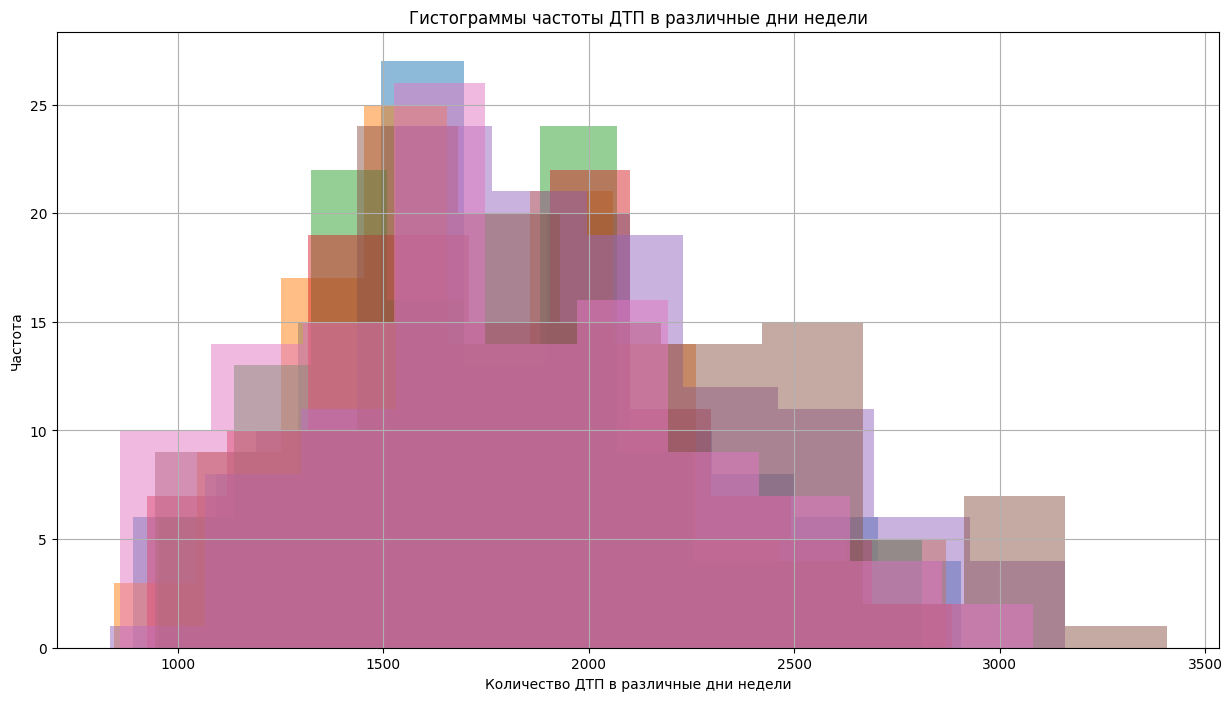

In [194]:
plt.figure(figsize=(15,8))
for i in range(0, 7):
  weekday_dtp_by_month[i].hist(alpha = 0.5)

plt.title('Гистограммы частоты ДТП в различные дни недели')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП в различные дни недели')
plt.show()

Проверка гипотезы статистическими методами.
надо, чтобы данные были независимы, нормально распределены (но с учетом Предельной теоремы можно и нет), равны дисперсии (иначе оказать)

Проверка на нормальное распределение. В ячейцках значения p-value для распределени аварий в этот день.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения не пройдена.

In [195]:
weekday_dtp_norm = pd.DataFrame(columns=[])
for wd in range(0, 7):
        pval = stats.normaltest(weekday_dtp_by_month[wd])[1]
        weekday_dtp_norm.loc['norm', weekday_name[wd+1]] = pval
weekday_dtp_norm.style.apply(highlight_stat, color='tomato')

Проверка на равенства дисперсий. В ячейцках значения p-value для теста сравнения выборок в номер дня по вертикали Y и в номер дня недели по горизонтали X.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий не пройдена.

In [196]:
weekday_dtp_levene = pd.DataFrame(columns=weekday_name.values())
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.levene(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2])[1]

        weekday_dtp_levene.loc[weekday_name[wd+1], weekday_name[wd2+1]] = pval
weekday_dtp_levene.style.apply(highlight_stat, color='tomato')

По парное сравнение ДТП в день недели. В ячейках - p-value гипозеты, что в номер дня по вертикали Y происходит столько же ДТП, сколько в номер дня недели по горизонтали X, альтернативная гипотеза - что ДТП происходит БОЛЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

На разных датасетов не всегда проходит проверка на нормальность распределения, поэтому провожу и Т-Тест, и тест Манн-Уитни.

In [197]:
weekday_dtp_prob = pd.DataFrame(columns=weekday_name.values())
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.ttest_ind(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2],
                                               alternative = 'greater',\
                                               equal_var=False)[1]
        weekday_dtp_prob.loc[weekday_name[wd+1], weekday_name[wd2+1]] = pval
weekday_dtp_prob.style.apply(highlight_stat)

In [198]:
weekday_dtp_prob = pd.DataFrame(columns=weekday_name.values())
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.mannwhitneyu(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2], alternative = 'greater')[1]
        weekday_dtp_prob.loc[weekday_name[wd+1], weekday_name[wd2+1]] = pval
weekday_dtp_prob.style.apply(highlight_stat)


Для подкрашенной ячейки читается так: в Y день недели происходит больше ДТП, чем в X. В пятницу и субботу происходит статистически значимо больше ДТП, чем в другие дни недели

Проверим эту гипотезу еще критерием oneway

In [199]:
pval = stats.f_oneway(weekday_dtp_by_month[0],
               weekday_dtp_by_month[1],
               weekday_dtp_by_month[2],
               weekday_dtp_by_month[3],
               weekday_dtp_by_month[4],
               weekday_dtp_by_month[5],
               weekday_dtp_by_month[6])[1]

pval_print(pval,
           h0='Количество ДТП в разные дни недели - однаково',
           h1='Количество ДТП разные дни недели - отличается')

В результате теста получено p-value 3.045860580158547e-05
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Количество ДТП разные дни недели - отличается 


In [200]:
pval = stats.f_oneway(weekday_dtp_by_month[0],
               weekday_dtp_by_month[1],
               weekday_dtp_by_month[2],
               weekday_dtp_by_month[3],
               weekday_dtp_by_month[6])[1]

pval_print(pval,
           h0='Количество ДТП в дни недели, кроме пятницы и субботы - однаково',
           h1='Количество ДТП разные дни недели, кроме пятницы и субботы - отличается')

В результате теста получено p-value 0.9055624150086754
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Количество ДТП в дни недели, кроме пятницы и субботы - однаково 


## *Происходит ли в "несчастливую" пятницу 13го больше ДТП*

Гипотеза: Пятница 13-ое - самая аварийная даже среди пятниц

In [201]:
friday_dtp = data.query('weekday == 4 & day != 13').groupby(['date'])['dtp_id'].count()
friday13_dtp = data.query('weekday == 4 & day == 13').groupby(['date'])['dtp_id'].count()

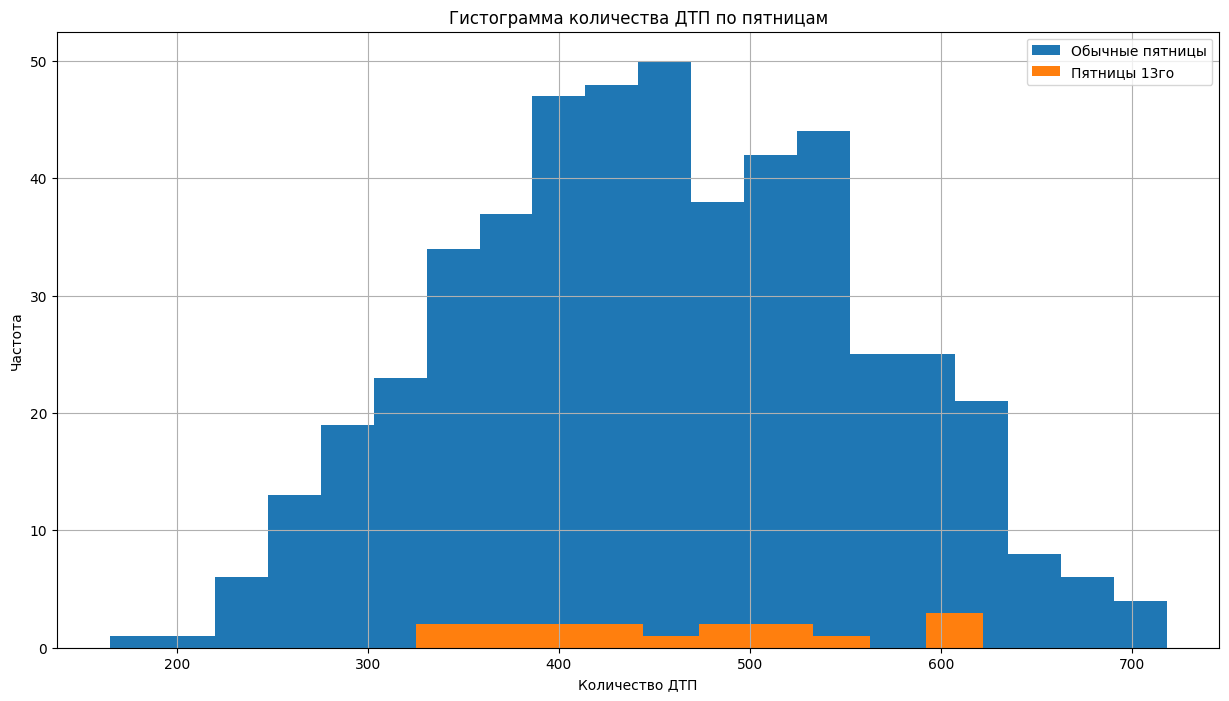

In [202]:
plt.figure(figsize=(15,8))
friday_dtp.hist(bins = 20, label = 'Обычные пятницы')
friday13_dtp.hist(label = 'Пятницы 13го')
plt.title('Гистограмма количества ДТП по пятницам')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()

In [203]:
print(f'В обычные пятницы в среднем происходит {round(friday_dtp.mean(), 2)} ДТП')
print(f'В пятницы 13го в среднем происходит {round(friday13_dtp.mean(), 2)} ДТП')

В обычные пятницы в среднем происходит 453.42 ДТП
В пятницы 13го в среднем происходит 466.24 ДТП


In [204]:
test_selection(
    friday13_dtp, friday_dtp,
    side = 'greater',
    h0 = 'В любые пятницы происходит одинаковое количество ДТП',
    h1 = 'В пятницу 13го ДТП происходит больше')

Первая выборка размером 17 прошла проверку на нормальное распределение. pval = 0.5477145218685806
Вторая выборка размером 492 НЕ прошла проверку на нормальное распределение. pval = 0.0066566611070450485
Дисперсии выборок близки. pval = 0.6041327696226448. Применяем equal_var=True 


--- Проводим TTest ---
В результате теста получено p-value 0.30971815122221097
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  В любые пятницы происходит одинаковое количество ДТП 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.33871836338152095
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  В любые пятницы происходит одинаковое количество ДТП 


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


Похоже "пятница 13ое" в аварийности на дорогах никак не прояляется

## *Распределение ДТП по месяцам не одинаково*

Гипотеза: Количество ДТП одинаково распределно по месяцам

Формируем выборки по месяцам. Берем только даты до 28 включительно, чтобы нивелировать разницу в днях.

In [205]:
dtp_by_month = []
for m in range(1, 13):
    dtp_by_month.append(data.query('month == @m & day <= 28').groupby(['day'])['dtp_id'].count())

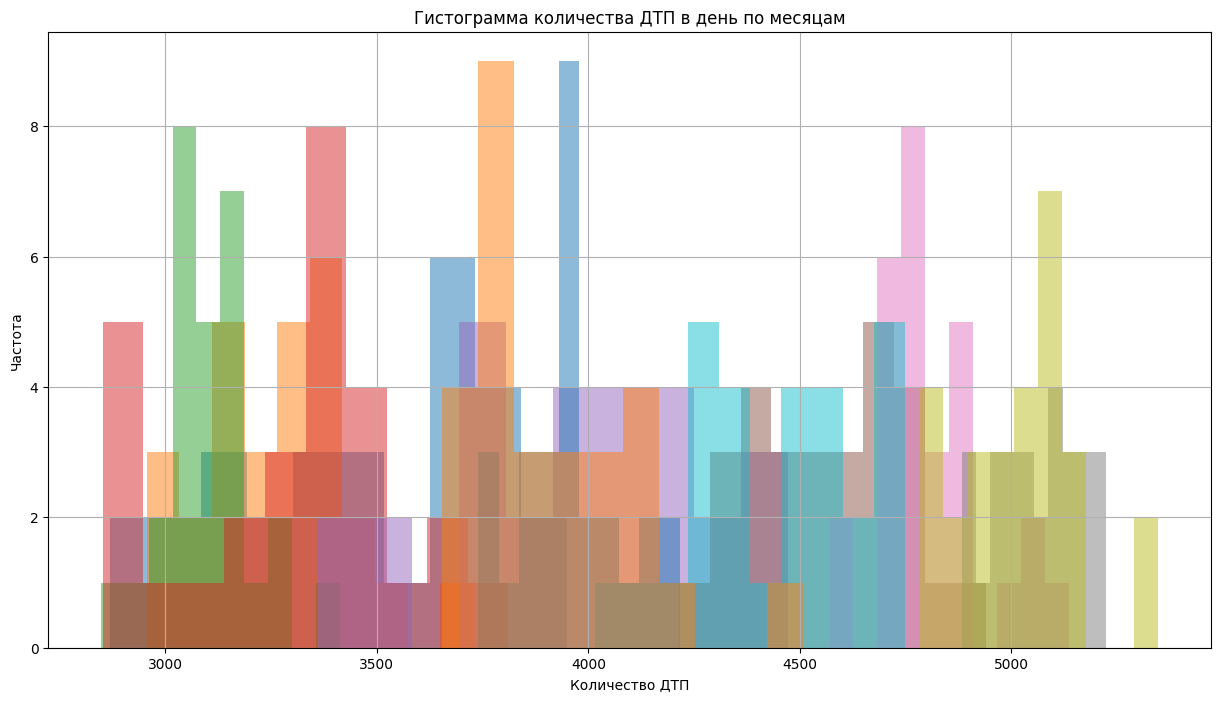

In [206]:
plt.figure(figsize=(15,8))
for i in range(0, 12):
  dtp_by_month[i].hist(alpha = 0.5)
plt.title('Гистограмма количества ДТП в день по месяцам')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.show()

In [207]:
month_dtp_norm = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    pval = stats.normaltest(dtp_by_month[wd])[1]
    month_dtp_norm.loc['norm', wd+1] = pval
month_dtp_norm.style.apply(highlight_stat, color='tomato')

In [208]:
month_dtp_leneve = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.levene(dtp_by_month[wd], dtp_by_month[wd2])[1]

        month_dtp_leneve.loc[wd+1, wd2+1] = pval
month_dtp_leneve.style.apply(highlight_stat, color='tomato')

Таблица по парного сравнения ДТП по месяцам. В ячейках p-value гипозеты, что в номер месяца по вертикали происходит столько же ДТП, сколько в номер месяца по горизонтали, альтернативная гипотеза - что происходит ДТП больше. Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

In [209]:
month_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.ttest_ind(dtp_by_month[wd], dtp_by_month[wd2],\
                               alternative = 'greater',\
                               equal_var=False)[1]
        month_dtp_prob.loc[wd+1, wd2+1] = pval
month_dtp_prob.style.apply(highlight_stat)

In [210]:
month_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.mannwhitneyu(dtp_by_month[wd], dtp_by_month[wd2],\
                                               alternative = 'greater')[1]
        month_dtp_prob.loc[wd+1, wd2+1] = pval
month_dtp_prob.style.apply(highlight_stat)

Для подкрашенной ячейки читается так: в Y месяц происходит больше ДТП, чем в X.

In [211]:
pval = stats.f_oneway(dtp_by_month[0],
               dtp_by_month[1],
               dtp_by_month[2],
               dtp_by_month[3],
               dtp_by_month[4],
               dtp_by_month[5],
               dtp_by_month[6],
               dtp_by_month[7],
               dtp_by_month[8],
               dtp_by_month[9],
               dtp_by_month[10],
               dtp_by_month[11],
                      )[1]

pval_print(pval, h0='Количество ДТП в день для разных месяцев - однаково', h1='Количество ДТП в день для разных месяцев - отличается')

В результате теста получено p-value 6.582444992102274e-172
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Количество ДТП в день для разных месяцев - отличается 


## *Промежуточные итоги*

*Проверили ряд гипотез о ДТП. В частности подтвердилось, часто мужчины водители нарушают чаще, а женщины-пешеходы чаше попадают в ДТП. Снегопад и дождь одинаково опасны. Начинающие водители попадают в ДТП также как и опытные. Пятница субботы - самые аварийные дни*

# **География ДТП - самые опасные районы, самые аварийные места на карте**

## *Регионы, в которых вероятность погибнуть, попав в ДТП, выше среднего*

In [212]:
regions_dtp = data.groupby('region', as_index=False)\
  .agg({'parent_region' : 'first', 'dtp_id' : 'count', 'participants_count' : 'sum', 'injured_count' : 'sum', 'dead_count' : 'sum'})

In [213]:
regions_dtp = regions_dtp.rename(columns = {'dtp_id' : 'dtp_count'})
regions_dtp['dtp_per'] = round(100 * regions_dtp['dtp_count'] / all_dtp_count, 2)
regions_dtp['injured_per'] = round(100 * regions_dtp['injured_count'] / all_injured_count, 2)
regions_dtp['dead_per'] = round(100 * regions_dtp['dead_count'] / all_dead_count, 2)
regions_dtp['dead_p'] = round(100 * regions_dtp['dead_count'] / regions_dtp['participants_count'], 2)
regions_dtp['injured_p'] = round(100 * regions_dtp['injured_count'] / regions_dtp['participants_count'], 2)

In [214]:
zkrit_to_all(regions_dtp)

Выполнено - 100.0 %


In [215]:
top_regions_dtp = regions_dtp[
            (regions_dtp['dtp_count'] > 100)\
            & (regions_dtp['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop = True)

factor_dead_table(top_regions_dtp[['parent_region', 'region', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

## *Карта очагов аварийности*

**Для определения очагов аварийности проведем округление коррдинат точек ДТП до 3 знака после запятой. Таким образом уменьшим точность определения места ДТП до 100-200 метров. Затем найдем количество ДТП, которые происходили в одном таком "укрупненном квадрате"**

In [216]:
data['lat_r'] = round(data['lat'], 3)
data['lng_r'] = round(data['lng'], 3)

In [217]:
#Сегментация

qq = 'region != ""'
#qq = 'region == "Сызранский район" or region == "Шигонский район" or region == "Октябрьск"'
#qq = 'region == "Сызранский район"'

In [218]:
dtp_points = pd.DataFrame(columns=['lat_r', 'lng_r', 'dtp_id', 'participants_count', 'injured_count', 'dead_count', 'oblast', 'address', 'year'])

oblast = (data['parent_region'].unique())
for o in oblast:
  qq = 'parent_region == "' + o + '"'
  dtp_points_oblast = data.query(qq).groupby(['lat_r', 'lng_r'], as_index=False)\
    .agg({'dtp_id': 'count', 'participants_count' : 'sum', 'injured_count' : 'sum',
          'dead_count' : 'sum', 'parent_region': 'first', 'address': 'first', 'year': 'max'})\
    .sort_values(by = 'dtp_id', ascending = False).head(10)
  dtp_points = pd.concat([dtp_points, dtp_points_oblast])

<ipython-input-218-f5e341bc2c6e>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dtp_points = pd.concat([dtp_points, dtp_points_oblast])


In [219]:
dtp_points = dtp_points[dtp_points['lat_r'] != round(dtp_points['lat_r'])]
dtp_points = dtp_points[dtp_points['year'] > 2022]
dtp_points = dtp_points.reset_index(drop=True)

Опредение тенденций количества ДТП в очагах аварийности

In [220]:
for i in range(0, len(dtp_points)):
    qsrt = 'lat_r == (' + str(dtp_points.loc[i, 'lat_r']) + ') & (lng_r == ' + str(dtp_points.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})

    kline = k_linear(dd[['year']], dd['dtp_id'])

    dtp_points.loc[i, 'k_line'] = round(kline, 3)

Очаги аварийности с самой большой тенеднций на снижение количества аварий за последение годы

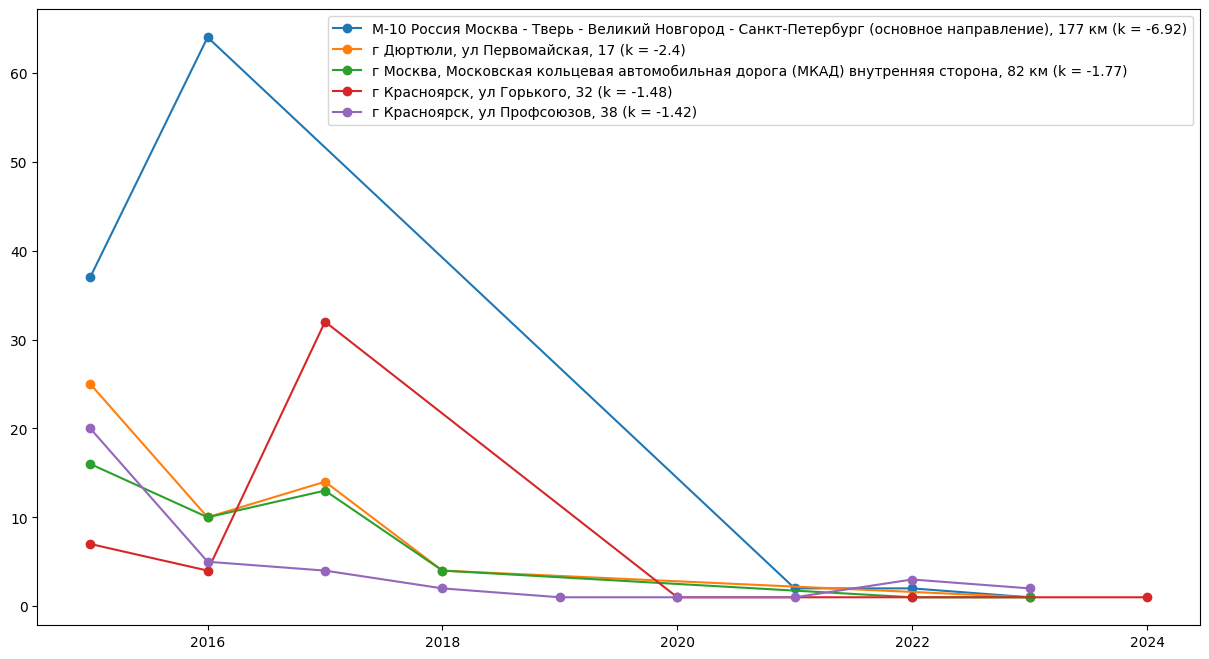

In [221]:
plt.figure(figsize=(15,8))
positive_point = dtp_points.query('(k_line < -0.2)').sort_values(by='k_line').head(5)
positive_point = positive_point.reset_index(drop=True)
for i in range(0, len(positive_point)):
    lg = positive_point.loc[i, 'address'] + ' (k = ' + str(round(positive_point.loc[i, 'k_line'], 2)) + ')'
    qsrt = 'lat_r == (' + str(positive_point.loc[i, 'lat_r']) + ') & (lng_r == ' + str(positive_point.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})
    x = dd['year']
    y = dd['dtp_id']
    plt.plot(x, y, linestyle="solid", marker="o", label=lg)
plt.legend()
plt.show()

Очаги аварийности с самой большой тенеднций на рост количества аварий за последение годы

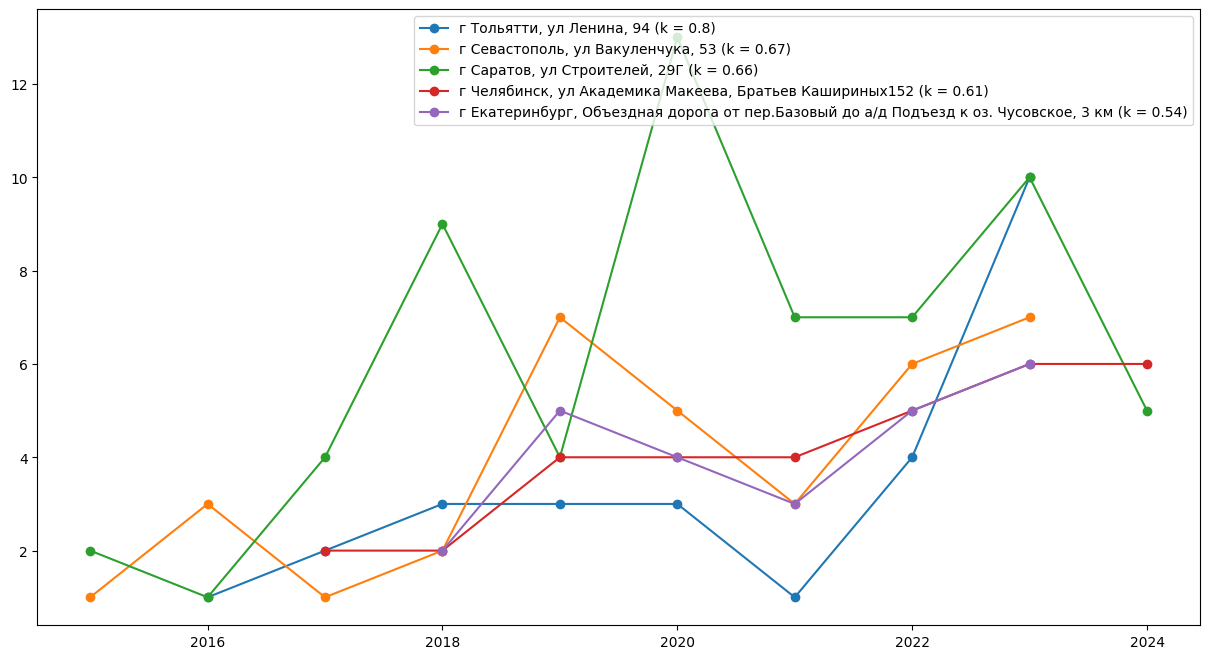

In [222]:
plt.figure(figsize=(15,8))
positive_point = dtp_points.query('(k_line > 0.2) & (lat_r != 53)').sort_values(by='k_line', ascending=False).head(5)
positive_point = positive_point.reset_index(drop=True)
for i in range(0, len(positive_point)):
    lg = positive_point.loc[i, 'address'] + ' (k = ' + str(round(positive_point.loc[i, 'k_line'], 2)) + ')'
    qsrt = 'lat_r == (' + str(positive_point.loc[i, 'lat_r']) + ') & (lng_r == ' + str(positive_point.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})
    x = dd[['year']]
    y = dd['dtp_id']
    plt.plot(x, y, linestyle="solid", marker="o", label=lg)
plt.legend()
plt.show()

Нанесем очаги аварийности на карту. Очаги с тенденцией на рост количества ДТП - отмечены красными маркерами, на снижение - зелеными, а где тендеци не меняется - синими.

In [223]:
map = folium.Map(location=[dtp_points['lat_r'].median(), dtp_points['lng_r'].median()],  tiles='Cartodb Positron')


for i in range(0, len(dtp_points)):
    text = f"{dtp_points.loc[i,'address']} ----> Количество ДТП {dtp_points.loc[i,'dtp_id']}. Погибло {dtp_points.loc[i,'dead_count']}. Ранено {dtp_points.loc[i,'injured_count']}. Тенденция {dtp_points.loc[i,'k_line']}"
    cl = 'blue'
    if dtp_points.loc[i,'k_line'] < -0.2: cl = 'green'
    if dtp_points.loc[i,'k_line'] > 0.2: cl = 'red'

    folium.Marker(location=[dtp_points.loc[i,'lat_r'], dtp_points.loc[i,'lng_r']],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color=cl, icon=''),
            ).add_to(map)

sw = dtp_points[['lat_r', 'lng_r']].min().values.tolist()
ne = dtp_points[['lat_r', 'lng_r']].max().values.tolist()

map.fit_bounds([sw, ne])
map

# **Общие выводы**

Исследование не закончено, поэтому пока итоговых выводов нет......

In [224]:
print(f"Расчет начат в {start}, закончен в {datetime.datetime.now(tz)}\r\nЗатрачено времени {(datetime.datetime.now(tz) - start)}")

Расчет начат в 2024-12-19 16:33:30.289872+04:00, закончен в 2024-12-19 17:20:26.333785+04:00
Затрачено времени 0:46:56.043947
